# Imports and Loading Data
check for TODO comments to help you get started

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colormaps
import pandas as pd
from google.colab import drive
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.optimize import Bounds
from tabulate import tabulate
from scipy.interpolate import splrep, BSpline
drive.mount('/mnt/drive') # mount google drive - MUST AGREE TO POPUPS

Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).


In [ ]:
# # fix Mingyu W.cal
# # mingyu_df = mingyu_df.drop(columns=["W"])
# mingyu_df["W.cal"] = W_cal(mingyu_df["Q2"], mingyu_df["x"])
# mingyu_df.head(10)
# mingyu_df.to_csv(dir + 'mingyu_g1f1_g2f1_dis.csv', index=False)

In [3]:
# Load csv files into data frames
dir = '/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/' # TODO: change to the path to wherever you keep the csv files
e06014_df = pd.read_csv(dir + 'dflay_e06014.csv')
e94010_df = pd.read_csv(dir + 'e94010.csv')
e97110_df = pd.read_csv(dir + 'e97110.csv')
psolva1a2_df = pd.read_csv(dir + 'psolv_e01012_a1a2.csv')
psolvg1g2_df = pd.read_csv(dir + 'psolv_e01012_g1g2.csv')
zheng_df = pd.read_csv(dir + 'zheng_thesis_pub_e99117.csv')
hermes_df = pd.read_csv(dir + 'hermes_2000.csv')
e142_df = pd.read_csv(dir + 'slac_e142.csv')
e154_df = pd.read_csv(dir + 'slac_e154.csv')
e97103_df = pd.read_csv(dir + 'kramer_e97103.csv')

mingyu_df = pd.read_csv(dir + 'mingyu_g1f1_g2f1_dis.csv') # mingyu thesis DIS


# Saikat's data tables for interpolation
# caldata = pd.read_csv(dir + 'saikat_tables/XZ_table_3He_JAM_smeared_kpsv_onshell_ipol1_ipolres1_IA14_SF23_AC11.csv') #  0.1<Q2<15.0 GeV2
# caldata = pd.read_csv(dir + 'saikat_tables/table_3He_JAM_smeared_kpsv_onshell_ipol1_ipolres1_IA14_SF23_AC11.csv') #  0.001<Q2<5.0 GeV2

# combined g1f1, g2f1, a1, a2 tables
g1f1_df = pd.read_csv(dir + 'g1f1_comb.csv')
g2f1_df = pd.read_csv(dir + 'g2f1_comb.csv')
a1_df = pd.read_csv(dir + 'a1_comb.csv')
a2_df = pd.read_csv(dir + 'a2_comb.csv')

# Useful Functions

In [4]:
def x_to_W(x, Q2):
  """ convert x to W for constant Q2"""
  Mp = 0.93870319 # average nucleon mass in 3He
  return np.sqrt(Mp**2 + Q2*((1/x)+1))

def W_to_x(W, Q2):
  """ convert W to x for constant Q2"""
  Mp = 0.93870319 # average nucleon mass in 3He
  return Q2/(W**2 + Q2 - Mp**2)

#TODO: reformulate this function so k_new is the peak height
def breit_wigner_res(w, M, k, gamma):
  """fit for constant Q2"""
  return k/((w*w - M*M)**2 + M*M*gamma*gamma)

def breit_wigner_wrapper(M_test):
  """for fitting with constant M"""
  def temp_func(w, k, gamma, M=M_test):
    return breit_wigner_res(w, M, k, gamma)
  return temp_func

def lin_curve(x, a, b):
  """simple line function for fitting"""
  return a*x + b

def quad_curve(x, a, b, c):
  """quadratic fit function"""
  return a + b*x + c*x**2

def quadconstr_curve(x, x0, y0, c):
  """quadratic fit function to constrain minimum"""
  return c*(x-x0)**2 + y0

def cubic_curve(x, a, b, c, d):
  """cubic fit function"""
  return a + b*x + c*x**2 + d*x**3

def exp_curve(x, a, b, c):
  """exponential fit function
  y = a * Exp[b * x] + c
  """
  return a*np.exp(b*x) + c

def cub_exp_curve(x, c0, c1, c2, c3, e0, e1):
  """cubic * exponential curve fit function"""
  return cubic_curve(x, c0, c1, c2, c3) * exp_curve(x, e0, e1, c=0)

def quadconstr_exp_curve(x, x0, y0, c, e0, e1):
  """cubic * exponential curve fit function"""
  return quadconstr_curve(x, x0, y0, c) * exp_curve(x, e0, e1, c=0)

def nucl_potential(x, p0, p1, p2, y0):
  """
  nuclear potential form from Xiaochao
  p0: depth of potential
  p1: jump point of potential
  p2: width of potential
  y0: constant value after jump
  """
  return y0 + p0/(1.0 + np.exp((x-p1)/p2))


def quad_nucl_curve(x, a, b, c, y0, p0, p1, p2, y1):
  """
  quadratic * nucl potential form
  x: independent data
  a, b, c: quadratic curve parameters
  c: quadratic parameter
  y0: constant value term for after decay
  p0: depth of nucl potential
  p1: jump point of nucl potential
  p2: width of nucl potential
  y1: final constant value of nuclear potential
  """
  return quad_curve(x, a, b, c) * nucl_potential(x, p0, p1, p2, y1) + np.ones(x.size)*y0

def quad_nucl_curve_constp(x, a, b, c, y0):
  """
  quadratic * nucl potential form
  x: independent data
  a, b, c: quadratic curve parameters
  y0: term to have curve end at a constant value
  """
  return quad_nucl_curve(x, a, b, c, y0, P0, P1, P2, Y1)

# from Xiaochao's thesis
def g1f1_quad_DIS(x_q2, a, b , c, beta):
  return (a+b*x_q2[0]+c*x_q2[0]*x_q2[0])*(1+(beta/x_q2[1]))

# different form for quadratic to constrain the minimum
# y = c*(x-x0)^2 + y0 where (x0, y0) is the minimum
def g1f1_quad2_DIS(x_q2, x0, y0, c, beta):
  return (c*(x_q2[0]-x0)**2+y0)*(1+(beta/x_q2[1]))

# guess form for downward trend at high x - a cubic!
def g1f1_cubic_DIS(x_q2, a, b , c, d, beta):
  return (a + b*x_q2[0] + c*x_q2[0]*x_q2[0] + d*x_q2[0]*x_q2[0]*x_q2[0])*(1+(beta/x_q2[1]))

def fit(func, x, y, y_err, params_init, param_names, constr=None, silent=False):
  """
  func: functional form to fit data with
  x: independent data
  y: dependent data
  y_err: uncertainties in dependent data
  params_init: a list of initial guesses for the parameters
  param_names: a list of the parameter names as strings
  constr: constraints on parameters - 2 tuple of bounds
  return: the parameters, covariance matrix, list of the
          uncertainties in the parameters, and chi_squared of the fit
  """
  # no specified bounds for params
  if constr is None:
    constr = ([-np.inf for x in param_names],
              [np.inf for x in param_names])

  params, covariance = curve_fit(func, x, y, p0=params_init, sigma=y_err, bounds=constr)
  param_sigmas = [np.sqrt(covariance[i][i]) for i in range(len(params))]
  table = [
    [f"{params[i]:.5f} ± {param_sigmas[i]:.5f}" for i in range(len(params))]
    ]

  # get reduced chi squared of fit
  nu = len(y) - len(param_names)
  args = [x] # list of args to give to func to get fitted curve
  args += [p for p in params]
  y_fit = func(*args)
  chi_2 = red_chi_sqr(y_fit, y, y_err, nu)

  if not silent:
    print(tabulate(table, param_names, tablefmt="fancy_grid"))
    print(f"$\chi_v^2$ = {chi_2:.2f}")

  return params, covariance, param_sigmas, chi_2

def red_chi_sqr(y_calc, y_obs, y_err, nu):
  """
  calculates reduced chi squared of fit (nu = n observations - m fitted parameters)
  """
  return np.sum(np.square((y_obs-y_calc)/y_err))/nu

def weighted_avg(y, w=1):
  """
  y: one dimensional array to average
  w: weights - array of ones if no weights are provided
     if using error as weight, w=1/error
  """
  if type(w) is int:
    w = np.ones(y.size)

  return np.sum(y*w)/np.sum(w)

# Model Building

## Fit $g_1/F_1$ Resonance data with Breit-Wigner distribution

TODO: substitute $k_{new}=k/(M^2 * \Gamma^2)$

\\
$g_1/F_1 = \frac{k}{(W^2-M^2)^2 + M^2  \Gamma^2}$

$k$, $\Gamma$ are functions of $Q^2$

$M$ is the mass of the peak (1232 MeV)

### Make dataframe with resonance data and assign labels for each Q2 bin

In [5]:
# make dataframe of Resonance values (1<W<2)
res_df = g1f1_df[g1f1_df['W']<2.0]
res_df = res_df[res_df['W']>1.0]

# drop Flay data
res_df = res_df.drop(res_df[res_df.Label == "Flay E06-014 (2014)"].index)

# drop Kramer data
res_df = res_df.drop(res_df[res_df.Label == 'Kramer E97-103 (2003)'].index)

In [6]:
q2_labels = []
# go through each experiment and divide into q2 bins
for name in res_df['Label'].unique():
  data = res_df[res_df['Label']==name]
  if name == "Flay E06-014 (2014)":
    # not using Flay data
    continue
    # # split Flay data into buckets
    # n_bins = 2
    # q2_ranges = np.linspace(data['Q2'].min(), data['Q2'].max(), n_bins+1)
    # print(q2_ranges)
    # for i in range(n_bins):
    #   max = q2_ranges[i+1]
    #   min = q2_ranges[i]
    #   bucket = data[data["Q2"]<=max]
    #   bucket = bucket[bucket["Q2"]>=min]
    #   mean_q2 = bucket['Q2'].mean()
    #   q2_labels += [f"{name} ${min:.2f} \leq Q^2 \leq {max:.2f}\ GeV^2$" for x in range(len(bucket))]

  else:
    for q2 in data['Q2'].unique():
      q2_labels += [f"{name} $Q^2={q2}\ GeV^2$" for x in range(len(data[data['Q2']==q2]))]
      print(name, q2, len(data[data['Q2']==q2]))

res_df['Q2_labels'] = q2_labels
# res_df = res_df.drop(labels=['Q2 Buckets'])
# res_df.head(1000)
n_bins = len(res_df['Q2_labels'])

E97-110 0.035 39
E97-110 0.057 39
E97-110 0.079 39
E97-110 0.1 39
E97-110 0.15 39
E97-110 0.2 39
E97-110 0.24 39
E94-010 0.1 32
E94-010 0.26 32
E94-010 0.42 26
E94-010 0.58 28
E94-010 0.74 27
E94-010 0.9 27
Solvg. E01-012 (2006) 1.2 8
Solvg. E01-012 (2006) 1.9 8
Solvg. E01-012 (2006) 2.6 8
Solvg. E01-012 (2006) 3.3 8


### Plot each Q2 bin

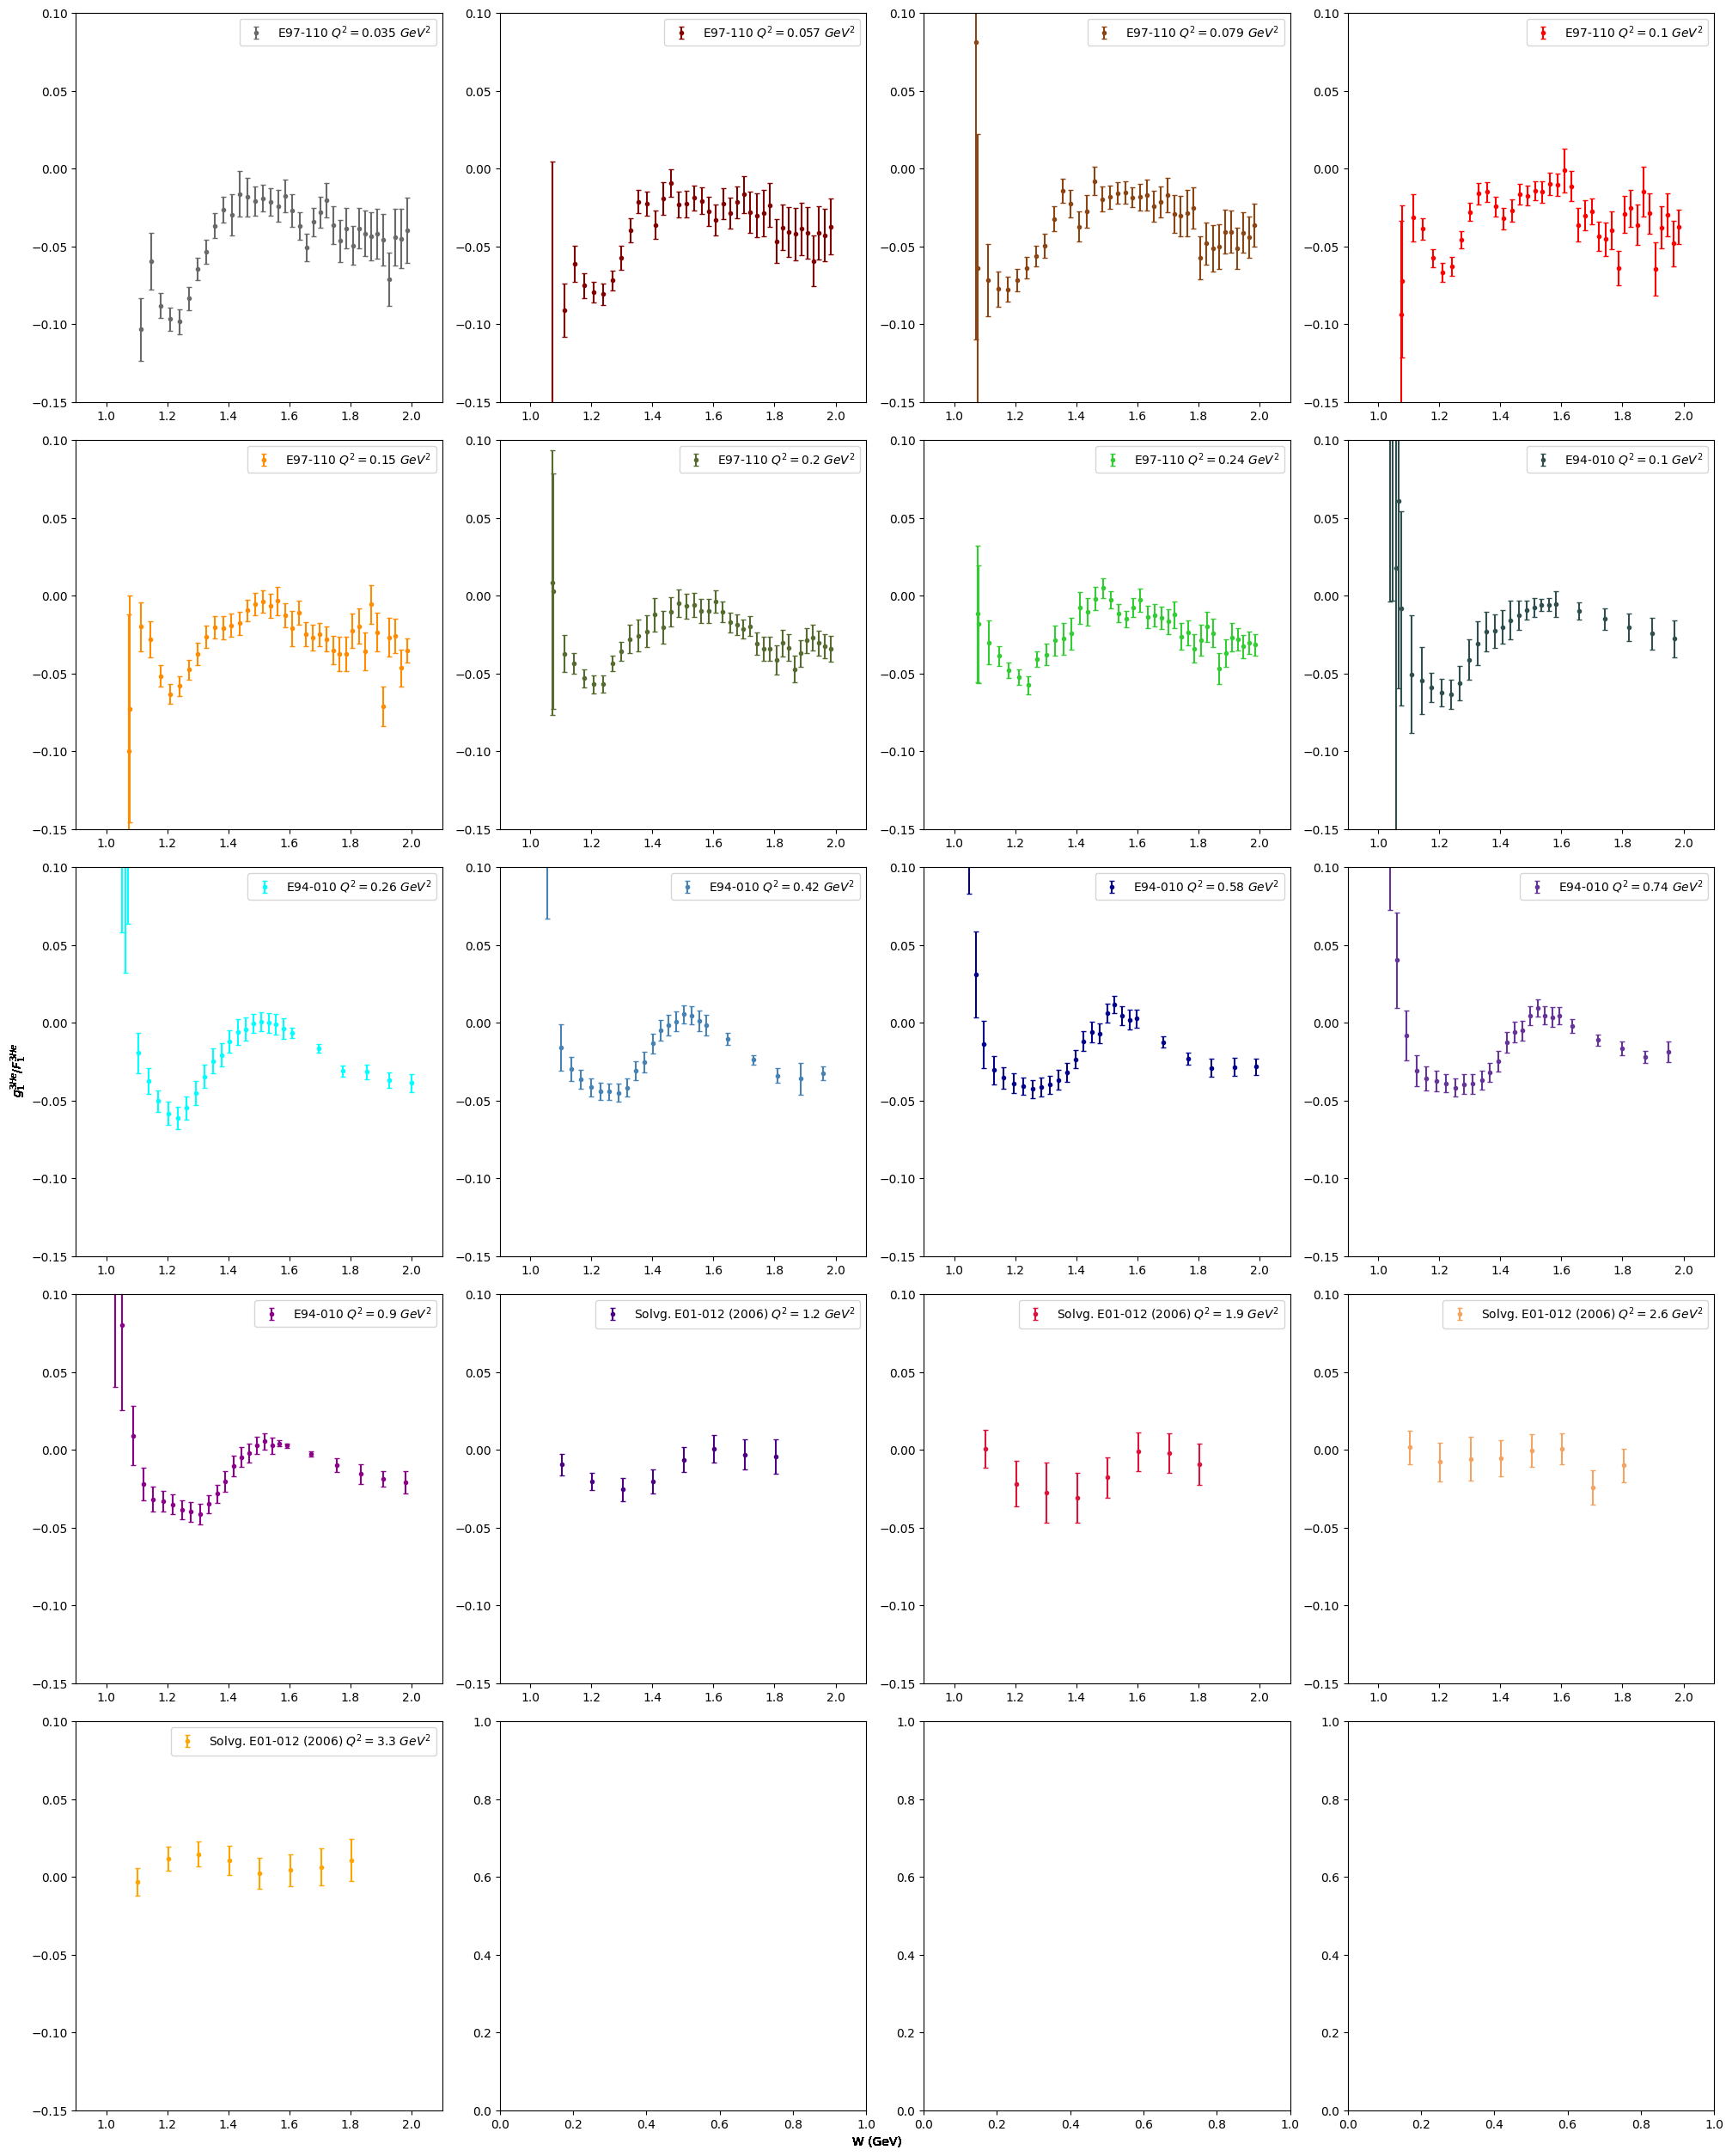

In [7]:
# formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
colors = ("dimgrey", "maroon", "saddlebrown", "red", "darkorange", "darkolivegreen",
          "limegreen", "darkslategray", "cyan", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta", "indigo", "crimson", "sandybrown", "orange", "teal", "mediumorchid")

# make figure
num_plots = len(res_df['Q2_labels'].unique())
n_rows = num_plots//4 + 1
fig, axs = plt.subplots(num_plots//4 + 1, 4, figsize=(20,n_rows*5))

# plot resonance w/ labels
for i,l in enumerate(res_df['Q2_labels'].unique()):
  row = i//4
  col = i%4
  axs[row, col].errorbar(res_df['W'][res_df['Q2_labels']==l],
              res_df['G1F1'][res_df['Q2_labels']==l],
              yerr=res_df['G1F1.err'][res_df['Q2_labels']==l],
              fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
              label=l, capthick=cap_thick)

  axs[row,col].legend()
  axs[row,col].set_ylim(-.15,0.1)
  axs[row,col].set_xlim(0.9,2.1)

  fig.tight_layout()
  fig.text(0.5, 0.001, "W (GeV)", ha='center', va='center')
  fig.text(0.0001, 0.5, "$g_1^{3He}/F_1^{3He}$", ha='center', va='center', rotation='vertical')
  # plt.savefig(f"/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1_q2buckets_resonance.png", bbox_inches = "tight")

### Resonance Fitting and Plotting Functions

In [11]:
## Plotting Function
def plot_res_fits(w_bounds, M, region_name, p_df):
  # formatting variables
  m_size = 6
  cap_size = 2
  cap_thick = 1
  m_type = '.'
  # colors = ("dimgrey", "maroon", "saddlebrown", "red", "darkorange", "darkolivegreen",
  #           "limegreen", "darkslategray", "cyan", "steelblue", "darkblue", "rebeccapurple",
  #           "darkmagenta", "indigo", "crimson", "sandybrown", "orange", "teal", "mediumorchid")

  colors = ("saddlebrown", "red", "darkorange", "darkolivegreen")

  # make figure
  n_col = 5
  num_plots = len(res_df['Q2_labels'].unique())
  n_rows = num_plots//n_col + 1
  fig, axs = plt.subplots(num_plots//n_col + 1, n_col, figsize=(n_col*6,n_rows*6))

  # make fit curves and plot with data
  for i,l in enumerate(res_df['Q2_labels'].unique()):
    row = i//n_col
    col = i%n_col

    # params for fit with 3 parameters M, k, gamma (variable mass)
    params = [p_df[p_df['Label']==l][f"{param_names[j]}"].unique()[0] for j in range(n_params)]

    # params for fit with 2 parameters k, gamma (fixed mass)
    params_constm = [p_df[p_df['Label']==l][f"{param_names[j+1]}_constM"].unique()[0] for j in range(n_params-1)]

    # Generate fitted curve using the fitted parameters
    w = np.linspace(w_bounds[i][0], w_bounds[i][1], 1000, dtype=np.double)

    # make fitted curve for all three parameter fit
    if 0 not in params:
      fit = breit_wigner_res(w, params[0], params[1], params[2])
      axs[row, col].plot(w, fit, color=colors[1], markersize=m_size,
                        label="Fit")

    # make fitted curve for two parameter fit (k, gamma)
    if 0 not in params_constm:
      fit_constm = breit_wigner_res(w, M, params_constm[0], params_constm[1])
      axs[row, col].plot(w, fit_constm, color=colors[2], markersize=m_size,
                        label=f"Fit M={M}", linestyle='dashed')


    # plot the data
    axs[row, col].errorbar(res_df['W'][res_df['Q2_labels']==l],
                  res_df['G1F1'][res_df['Q2_labels']==l],
                  yerr=res_df['G1F1.err'][res_df['Q2_labels']==l],
                  fmt=m_type, color=colors[0], markersize=m_size, capsize=cap_size,
                  capthick=cap_thick)

    axs[row,col].legend()
    # set axes limits
    axs[row,col].axhline(0, color="black", linestyle="--")
    axs[row,col].set_ylim(-.15,0.1)
    axs[row,col].set_xlim(0.9,2.1)
    axs[row,col].set_title(l)

  fig.tight_layout()
  fig.text(0.5, 0.001, "W (GeV)", ha='center', va='center', size = 14)
  fig.text(0.0001, 0.5, "$g_1^{3He}/F_1^{3He}$", ha='center', va='center', rotation='vertical', size=16)
  # plt.savefig(f"/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1_res_{region_name}_fits.png", bbox_inches = "tight")


## Fitting Function
def fit_breit_wigner(w_bounds, M, region_name):
  """
  w_bounds: list of bounds of W for fitting for each bin (ex: [(w min, w max),...])
  M: actual mass of resonance
  init: initial guesses for M, k, gamma
  region_name: unique name for resonance region that is being fitted

  returns a new dataframe with the parameters
  """
  # lists to make dataframe
  q2_list = []
  label_list = []
  exp_list = []
  # lists to hold k, gamma and their errors for constant M fits
  constM_par_lists = [[],[]]
  constM_par_err_lists = [[],[]]
  # lists to hold M, k, gamma and their errors
  par_lists = [[],[],[]]
  par_err_lists = [[],[],[]]



  # go through each experiment for constant Q2 and do a fit
  for i, name in enumerate(res_df['Q2_labels'].unique()):
    n_points = len(res_df['W'][res_df['Q2_labels']==name])
    init = (m_init[i], k_init[i], gamma_init[i])

    label_list.append(name) # add name to list of labels

    # get Q2 for this bin
    if "Flay" in name:
      q2 = res_df['Q2'][res_df['Q2_labels']==name].mean()
    else:
      q2 = res_df['Q2'][res_df['Q2_labels']==name].unique()[0]
    q2_list.append(q2)

    # add experiment name to list
    exp_list.append(res_df['Label'][res_df['Q2_labels']==name].unique()[0])

    # chop off data outside w_min and w_max
    w = res_df['W'][res_df['Q2_labels']==name][res_df['W']<w_bounds[i][1]][res_df['W']>w_bounds[i][0]]
    g1f1 = res_df['G1F1'][res_df['Q2_labels']==name][res_df['W']<w_bounds[i][1]][res_df['W']>w_bounds[i][0]]
    g1f1_err = res_df['G1F1.err'][res_df['Q2_labels']==name][res_df['W']<w_bounds[i][1]][res_df['W']>w_bounds[i][0]]

    # default bounds for parameters M, k, gamma
    par_bounds = ([-np.inf, -np.inf, -np.inf],
                    [np.inf, np.inf, np.inf])

    if "Solvg." in name:
      # bound gamma
      par_bounds = ([-np.inf, -np.inf, .15],
                    [np.inf, np.inf, .4])
    try:
      # fit for (M, k, gamma) and get parameters and covariance matrix
      params, pcov, perr, chi2 = fit(breit_wigner_res, w, g1f1, g1f1_err, init, ["M", "k", "gamma"], par_bounds, silent=True)
    except Exception as e:
      print(f"{name} Fit Failed\n   {e}")
      params = np.zeros(n_params)
      pcov = np.zeros((n_params, n_params))

    # add parameters and their errors to lists for M, k, gamma
    for j in range(len(params)):
      par_lists[j].append(params[j])
      par_err_lists[j].append(perr[j])

    try:
      # try fitting with constant M
      params_constm, pcov_constm, perr_constm, chi2_constm = fit(breit_wigner_wrapper(M), w, g1f1, g1f1_err, init[1:], ["k", "gamma"], [par_bounds[0][1:],par_bounds[1][1:]], silent=True)
    except Exception as e:
      print(f"{name} Constant M Fit Failed\n   {e}")
      params_constm = np.zeros(n_params-1)
      pcov_constm = np.zeros((n_params-1, n_params-1))

    # add parameters and their errors to lists for k & gamma for constant M fits
    for j in range(len(params_constm)):
      constM_par_lists[j].append(params_constm[j])
      constM_par_err_lists[j].append(perr_constm[j])

    table = [
        [f"{params[j]:.5f} ± {perr[j]:.5f}" for j in range(n_params)] + [f"{chi2:.2f}"],
        [f"{M}"] + [f"{params_constm[j]:.5f} ± {perr_constm[j]:.5f}" for j in range(n_params - 1)] + [f"{chi2_constm:.2f}"]
        ]

    # Print the table
    print(f"{name} Fit Parameters")
    # header is param_names
    print(tabulate(table, param_names + ["$\chi_v^2$"], tablefmt="fancy_grid"))

  # make lists into dataframe
  params_df = pd.DataFrame({"Q2": q2_list,
                            "Experiment": exp_list,
                            "Label": label_list,
                            "k_constM": constM_par_lists[0],
                            "k_constM.err": constM_par_err_lists[0],
                            "gamma_constM": constM_par_lists[1],
                            "gamma_constM.err": constM_par_err_lists[1],
                            "M": par_lists[0],
                            "M.err": par_err_lists[0],
                            "k": par_lists[1],
                            "k.err": par_err_lists[1],
                            "gamma": par_lists[2],
                            "gamma.err": par_err_lists[2]})

  # plot
  plot_res_fits(w_bounds=w_bounds, M=M, region_name=region_name, p_df=params_df)

  return params_df

### Fit and Plot 1232 MeV "Delta" Resonance - outputs fit parameters for each bin and plots them

E97-110 $Q^2=0.035\ GeV^2$ Fit Parameters
╒═══════════════════╤════════════════════╤═══════════════════╤══════════════╕
│ M                 │ k                  │ gamma             │   $\chi_v^2$ │
╞═══════════════════╪════════════════════╪═══════════════════╪══════════════╡
│ 1.20778 ± 0.01989 │ -0.01046 ± 0.00442 │ 0.27002 ± 0.06461 │         2.9  │
├───────────────────┼────────────────────┼───────────────────┼──────────────┤
│ 1.232             │ -0.00732 ± 0.00236 │ 0.22099 ± 0.04168 │         3.18 │
╘═══════════════════╧════════════════════╧═══════════════════╧══════════════╛
E97-110 $Q^2=0.057\ GeV^2$ Fit Parameters
╒═══════════════════╤════════════════════╤═══════════════════╤══════════════╕
│ M                 │ k                  │ gamma             │   $\chi_v^2$ │
╞═══════════════════╪════════════════════╪═══════════════════╪══════════════╡
│ 1.20622 ± 0.01569 │ -0.00784 ± 0.00283 │ 0.25400 ± 0.05207 │         2.12 │
├───────────────────┼────────────────────┼────────────────

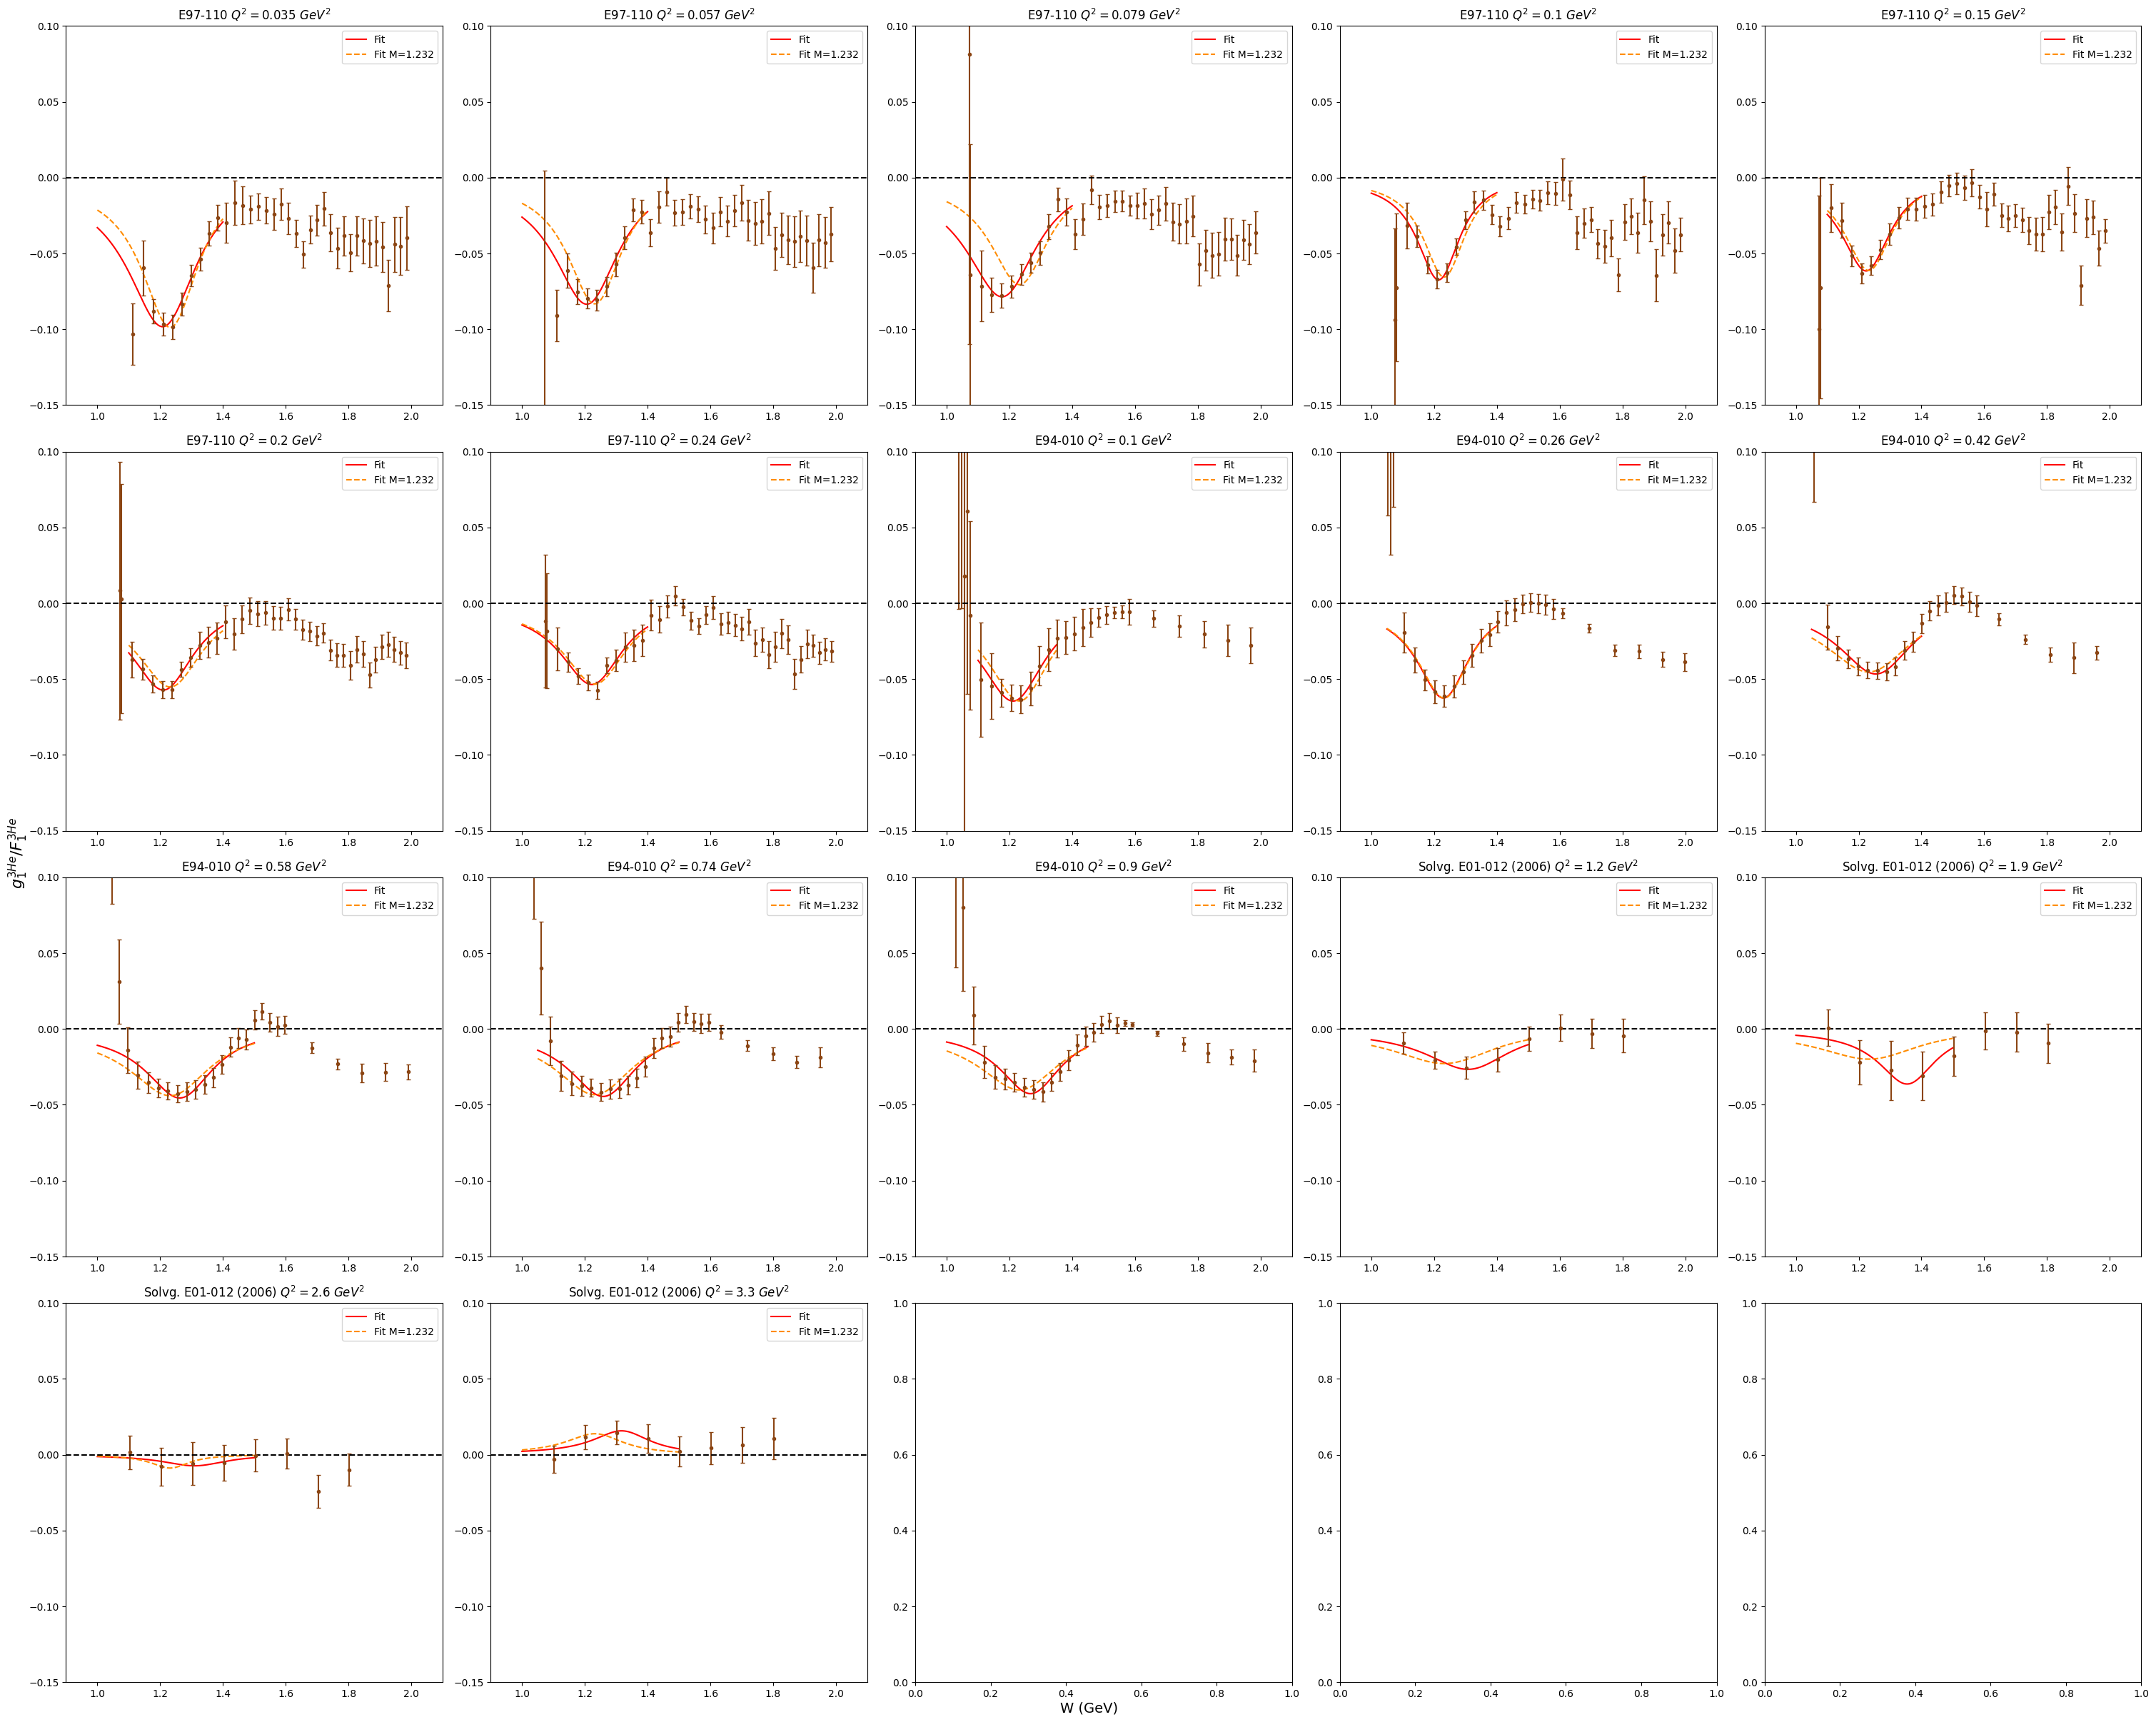

In [12]:
param_names = ["M", "k", "gamma"]
n_params = len(param_names)

## fit W=1.232 resonance
# initial guesses for k and M
k_init = [-.025, -.06, -.01, .02,
          -.1, -.08, -.08, -.07,
          -.06, -.06, -.05, -.2,
          -.2, -.15, -.14, -.13,
          -.13, -0.1, .01]

m_init = [1.3, 1.35, 1.2, 1.25,
          1.23, 1.23, 1.23, 1.23,
          1.2, 1.22, 1.22, 1.2,
          1.22, 1.25, 1.3, 1.3,
          1.3, 1.3, 1.5]

gamma_init = [0.1, 0.3, 0.1, 0.1,
          0.1, 0.1, 0.1, 0.1,
          0.1, 0.1, 0.1, 0.1,
          0.1, 0.2, 0.2, 0.2,
          0.2, 0.1, 0.1]

w_lims = [(1.0, 1.4), (1.0, 1.4), (1.0, 1.4), (1.0, 1.4),
          (1.1, 1.4), (1.1, 1.4), (1.0, 1.4), (1.1, 1.35),
          (1.05, 1.4), (1.05, 1.4), (1.0, 1.5), (1.05, 1.5),
          (1.0, 1.45), (1.0, 1.5), (1.0, 1.5), (1.0, 1.5),
          (1.0, 1.5), (1.0, 1.65), (1.0, 1.8)]

gamma_bounds = ()

delta_par_df = fit_breit_wigner(w_bounds=w_lims, M=1.232, region_name="1232MeV")
# delta_par_df.head(50)

### Delta peak visible in constant M fits for E94-010 and E97-110 - plot k and γ from these fits vs $Q^2$
add k's from Solvg. constrained gamma fits

In [9]:
# # delta_par_df.head(100)

# # reorder by increasing Q2
# df = delta_par_df.sort_values(by=['Q2'])
# df.head(20)

Text(0.53, 0.001, '$Q^2\\ ({GeV}^2)$')

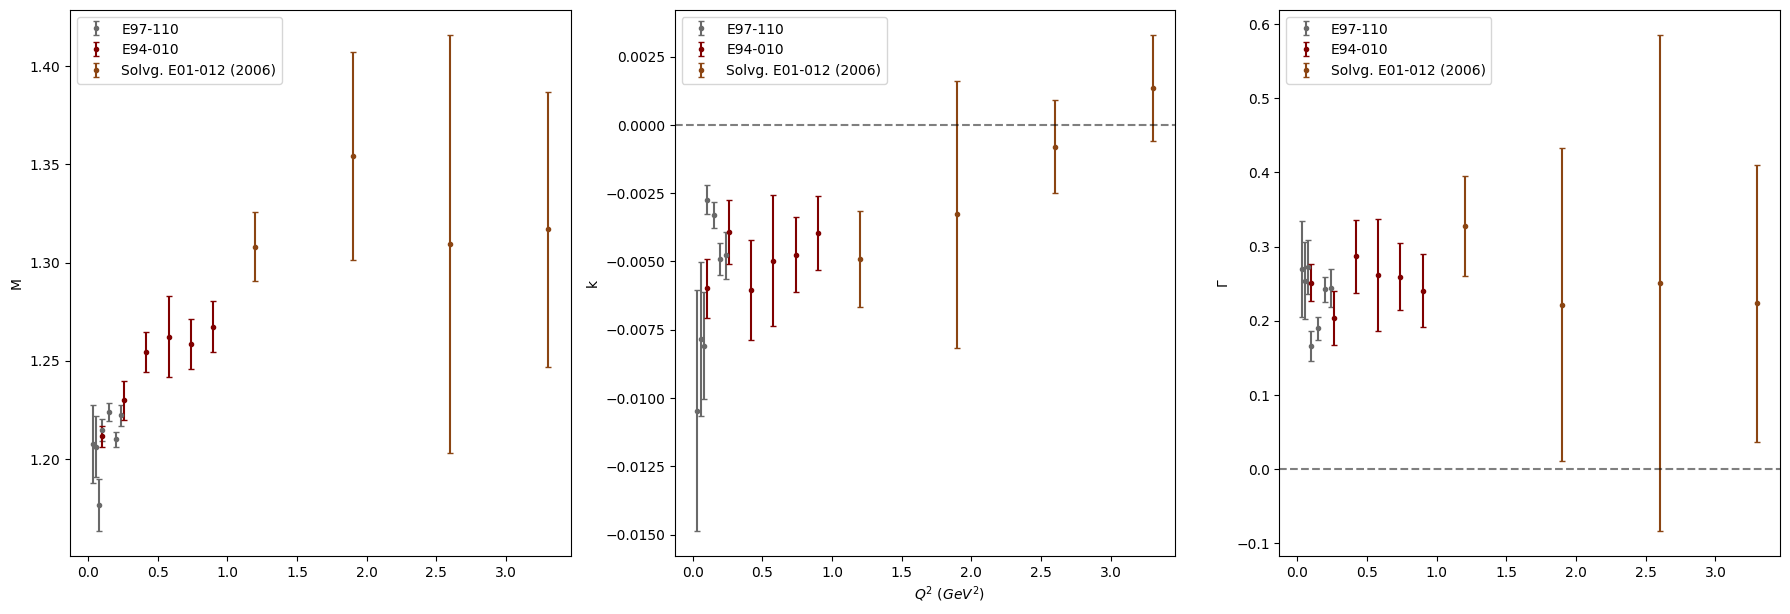

In [13]:
# plot M, k, gamma vs Q2 from variable M fit
fig, axs = plt.subplots(1, 3, figsize=(18,6))

# maintain distinct colors between plots by keeping track of the index in the color map
color_index = 0

# plot all the parameters vs Q2
for i, exp_name in enumerate(delta_par_df["Experiment"].unique()):
  axs[0].errorbar(delta_par_df[delta_par_df["Experiment"]==exp_name]["Q2"],
                  delta_par_df[delta_par_df["Experiment"]==exp_name]["M"],
                  yerr=delta_par_df[delta_par_df["Experiment"]==exp_name]["M.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=exp_name, capthick=cap_thick)

  axs[1].errorbar(delta_par_df[delta_par_df["Experiment"]==exp_name]["Q2"],
                  delta_par_df[delta_par_df["Experiment"]==exp_name]["k"],
                  yerr=delta_par_df[delta_par_df["Experiment"]==exp_name]["k.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=exp_name, capthick=cap_thick)

  axs[2].errorbar(delta_par_df[delta_par_df["Experiment"]==exp_name]["Q2"],
                  delta_par_df[delta_par_df["Experiment"]==exp_name]["gamma"],
                  yerr=delta_par_df[delta_par_df["Experiment"]==exp_name]["gamma.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=exp_name, capthick=cap_thick)

axs[0].set_ylabel("M")
axs[1].set_ylabel("k")
axs[2].set_ylabel("$\Gamma$")

axs[1].axhline(y=0,color="black", linestyle='--', alpha=0.5)
axs[2].axhline(y=0, color="black", linestyle='--', alpha=0.5)

axs[0].legend()
axs[1].legend()
axs[2].legend()

fig.tight_layout()
fig.text(0.53, 0.001, "$Q^2\ ({GeV}^2)$", ha='center', va='center')

Averaging points for spline - ignore EXCEPT for part adding fictitious points at high Q2

In [16]:

# x = list(df["Q2"].unique())
# k_unique = []
# k_err_unique = []
# gam_unique = []
# gam_err_unique = []

# # go through each unique Q2 value and do weighted average of the points
# # weight = 1/err
# for Q2 in x:
#   # average k's and their errors
#   k_avg = weighted_avg(df[df["Q2"]==Q2]["k_constM"], w=1/df[df["Q2"]==Q2]["k_constM.err"])
#   k_unique.append(k_avg)
#   k_avg_err = (1/len(df[df["Q2"]==Q2]["k_constM.err"])) * np.sqrt(np.sum(df[df["Q2"]==Q2]["k_constM.err"]**2))
#   k_err_unique.append(k_avg_err)

#   # average gammas and their errors
#   gam_avg = weighted_avg(df[df["Q2"]==Q2]["gamma_constM"], w=(1/df[df["Q2"]==Q2]["gamma_constM.err"]))
#   gam_unique.append(gam_avg)
#   gam_avg_err = (1/len(df[df["Q2"]==Q2]["gamma_constM.err"])) * np.sqrt(np.sum(df[df["Q2"]==Q2]["gamma_constM.err"]**2))
#   gam_err_unique.append(gam_avg_err)

#   # print(Q2)
#   # print(f"  {k_avg:.5f}±{k_avg_err:.5f}")
#   # print(f"  {gam_avg:.5f}±{gam_avg_err:.5f}")

# add fictitious end points to control behavior at high Q2 - TODO: determine adequate value for gamma from E94-010 points and apply to delta par df
# x0 = 4.0
# for i in range(7):
#   x.append(x0+i)
#   k_unique.append(0.0)
#   k_err_unique.append(.001)
#   gam_unique.append(0.2)
#   gam_err_unique.append(.1)

Text(0.53, 0.001, '$Q^2\\ ({GeV}^2)$')

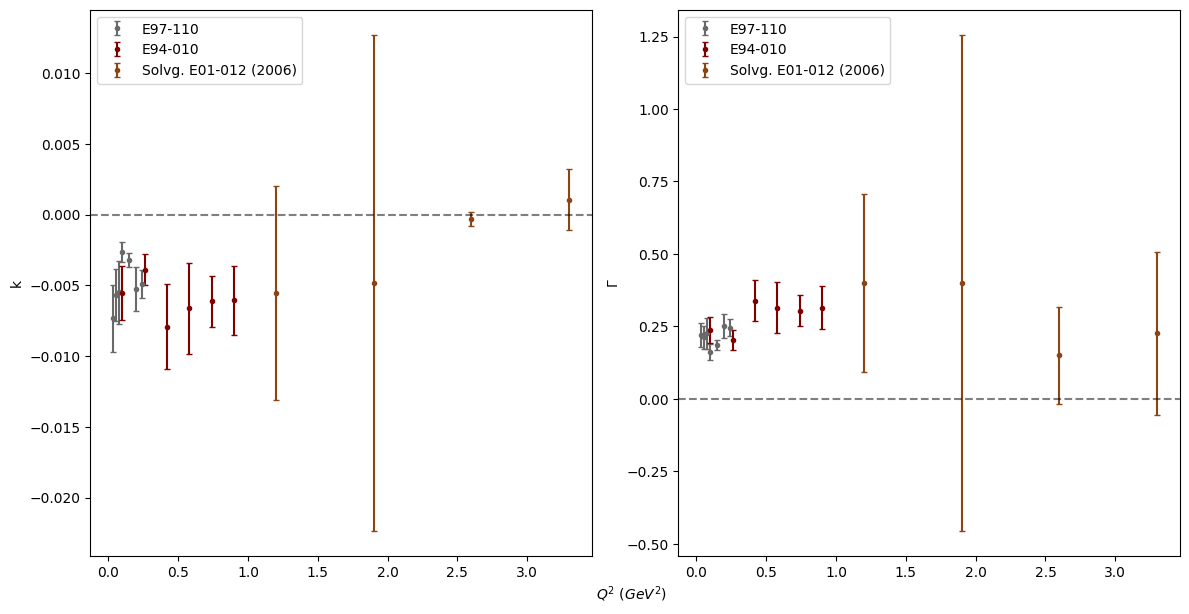

In [17]:
# plot k and gamma vs Q2 from variable M fit

fig, axs = plt.subplots(1, 2, figsize=(12,6))
k_list = []
k_err_list = []
gamma_list = []
gamma_err_list = []
q2_list = []
label_list = []

# maintain distinct colors between plots by keeping track of the index in the color map
color_index = 0

# # drop Q2 = 3.3 GeV2 fit for Solvg. since k shouldn't be positive
# delta_par_df = delta_par_df.drop(delta_par_df[delta_par_df.Label == "Solvg. E01-012 (2006) $Q^2=3.3\ GeV^2$"].index)

# plot all the parameters vs Q2
for i, exp_name in enumerate(delta_par_df["Experiment"].unique()):
  axs[0].errorbar(delta_par_df[delta_par_df["Experiment"]==exp_name]["Q2"],
                  delta_par_df[delta_par_df["Experiment"]==exp_name]["k_constM"],
                  yerr=delta_par_df[delta_par_df["Experiment"]==exp_name]["k_constM.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=exp_name, capthick=cap_thick)

  axs[1].errorbar(delta_par_df[delta_par_df["Experiment"]==exp_name]["Q2"],
                  delta_par_df[delta_par_df["Experiment"]==exp_name]["gamma_constM"],
                  yerr=delta_par_df[delta_par_df["Experiment"]==exp_name]["gamma_constM.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=exp_name, capthick=cap_thick)

# axs[0].errorbar(x[0:], k_unique[0:], yerr=k_err_unique[0:], fmt=m_type,
#                 markersize=m_size, capsize=cap_size,
#                 label="Combined for Spline", capthick=cap_thick, alpha=0.35)

# axs[1].errorbar(x[0:], gam_unique[0:], yerr=gam_err_unique[0:], fmt=m_type,
#                 markersize=m_size, capsize=cap_size,
#                 label="Combined for Spline", capthick=cap_thick, alpha=0.35)

axs[0].set_ylabel("k")
axs[1].set_ylabel("$\Gamma$")

axs[0].axhline(y=0,color="black", linestyle='--', alpha=0.5)
axs[1].axhline(y=0, color="black", linestyle='--', alpha=0.5)
# axs[0].set_xlim(-.1, 1.0)

# plot splines - run next cell before uncommenting this part
# q2 = np.linspace(0, 10.0, 1000, dtype=np.double)
# axs[0].plot(q2, BSpline(*tck_k)(q2), '-', label=f'Spline s={sk}')
# axs[1].plot(q2, BSpline(*tck_gamma)(q2), '-', label=f'Spline s={sg}')

axs[0].legend()
axs[1].legend()

fig.tight_layout()
fig.text(0.53, 0.001, "$Q^2\ ({GeV}^2)$", ha='center', va='center')

A bunch of different fits I tried... just keep Quad*Nucl Potential (I say nuclear potential but it's Woods-Saxon). TODO: fit M, k, gamma from the floating Delta fits

K Quad-Nucl Potential Fit Params
╒════════════════════╤════════════════════╤════════════════════╤═══════════════════╕
│ a                  │ b                  │ c                  │ y0                │
╞════════════════════╪════════════════════╪════════════════════╪═══════════════════╡
│ -0.00554 ± 0.00308 │ -0.00511 ± 0.00847 │ -0.00155 ± 0.00906 │ 0.00070 ± 0.00149 │
╘════════════════════╧════════════════════╧════════════════════╧═══════════════════╛
$\chi_v^2$ = 0.94
Gamma Quad-Nucl Potential Fit Params
╒═══════════════════╤═══════════════════╤════════════════════╤═══════════════════╕
│ a                 │ b                 │ c                  │ y0                │
╞═══════════════════╪═══════════════════╪════════════════════╪═══════════════════╡
│ 0.04200 ± 0.23078 │ 0.18898 ± 0.11260 │ -0.04140 ± 0.14282 │ 0.11743 ± 0.28244 │
╘═══════════════════╧═══════════════════╧════════════════════╧═══════════════════╛
$\chi_v^2$ = 0.71


Text(0.53, 0.001, '$Q^2\\ ({GeV}^2)$')

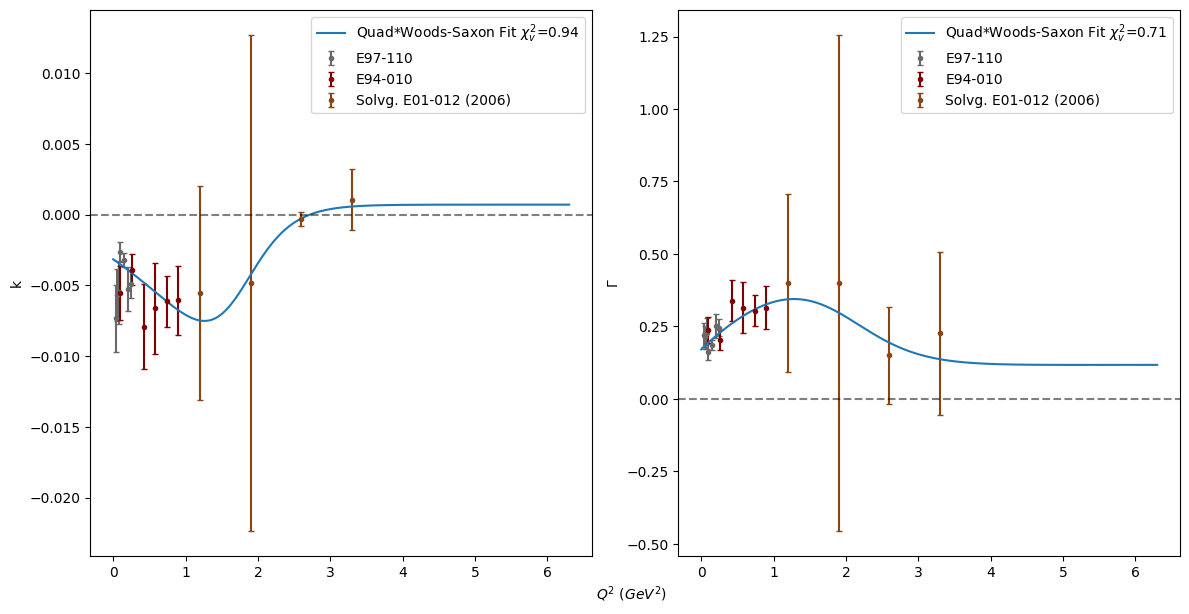

In [18]:
# # fit k and gamma with line
# print("K Linear Fit Params")
# k_lin_par, k_lin_cov, k_lin_err, k_lin_chi2 = fit(lin_curve, delta_par_df["Q2"],
#                                                   delta_par_df["k_constM"],
#                                                   delta_par_df["k_constM.err"],
#                                                   params_init=(0,0),
#                                                   param_names=["a", "b"])
# print("Gamma Linear Fit Params")
# gam_lin_par, gam_lin_cov, gam_lin_err, gam_lin_chi2 = fit(lin_curve, delta_par_df["Q2"],
#                                                           delta_par_df["gamma_constM"],
#                                                           delta_par_df["gamma_constM.err"],
#                                                           params_init=(0,0),
#                                                           param_names=["a", "b"])

# # fit k and gamma with quadratic curve
# print("K Quadratic Fit Params")
# k_quad_par, k_quad_cov, k_quad_err, k_quad_chi2 = fit(quad_curve, delta_par_df["Q2"],
#                                                       delta_par_df["k_constM"],
#                                                       delta_par_df["k_constM.err"],
#                                                       params_init=(0,0,0),
#                                                       param_names=["a", "b", "c"])
# print("Gamma Quadratic Fit Params")
# gam_quad_par, gam_quad_cov, gam_quad_err, gam_quad_chi2 = fit(quad_curve, delta_par_df["Q2"],
#                                                               delta_par_df["gamma_constM"],
#                                                               delta_par_df["gamma_constM.err"],
#                                                               params_init=(0,0,0),
#                                                               param_names=["a", "b", "c"])


# # fit k and gamma with cubic curve
# print("K Cubic Fit Params")
# k_cub_par, k_cub_cov, k_cub_err, k_cub_chi2 = fit(cubic_curve, delta_par_df["Q2"],
#                                                   delta_par_df["k_constM"], delta_par_df["k_constM.err"],
#                                                   params_init=(0,0,0,0),
#                                                   param_names=["a", "b", "c", "d"])
# print("Gamma Cubic Fit Params")
# gam_cub_par, gam_cub_cov, gam_cub_err, gam_cub_chi2 = fit(cubic_curve, delta_par_df["Q2"],
#                                                           delta_par_df["gamma_constM"],
#                                                           delta_par_df["gamma_constM.err"],
#                                                           params_init=(0,0,0,0),
#                                                           param_names=["a", "b", "c", "d"])

# # fit k and gamma with exponential curve
# print("K Exponential Fit Params")
# try:
#   k_exp_par, k_exp_cov, k_exp_err, k_exp_chi2 = fit(exp_curve, delta_par_df["Q2"],
#                                                     delta_par_df["k_constM"], delta_par_df["k_constM.err"],
#                                                     params_init=(0,0,0),
#                                                     param_names=["a", "b", "c"])
# except Exception:
#   print(" Fit failed")


# print("Gamma Exponential Fit Params")
# gam_exp_par, gam_exp_cov, gam_exp_err, gam_exp_chi2 = fit(exp_curve, delta_par_df["Q2"],
#                                                           delta_par_df["gamma_constM"],
#                                                           delta_par_df["gamma_constM.err"],
#                                                           params_init=(0,0,0),
#                                                           param_names=["a", "b", "c"])

# fit k with constrained quadratic * exp curve
# constraints = ([.4, -.01, -np.inf, -np.inf, -np.inf],
#                [.6, -.005, np.inf, np.inf, np.inf])
# print("k Quadratic-Exponential Fit Params")
# k_quadexp_par, k_quadexp_cov, k_quadexp_err, k_quadexp_chi2 = fit(quadconstr_exp_curve, delta_par_df["Q2"],
#                                                                   delta_par_df["k_constM"], delta_par_df["k_constM.err"],
#                                                                   params_init=(0.5,-.007,1,1,-1),
#                                                                   param_names=["x0", "y0", "c", "a", "b"])


# # fit k with cubic * exp curve
# print("k Cubic-Exponential Fit Params")
# k_cubexp_par, k_cubexp_cov, k_cubexp_err, k_cubexp_chi2 = fit(cub_exp_curve, delta_par_df["Q2"],
#                                                               delta_par_df["k_constM"], delta_par_df["k_constM.err"],
#                                                               params_init=(-.03,-.008,.006,-.001,.95,-1),
#                                                               param_names=["a0", "b0", "c0", "d0", "a1", "b1"])


# fit k and gamma with quadratic*nuclear potential function
print("K Quad-Nucl Potential Fit Params")
# bounds = Bounds(lb=[-np.inf, -np.inf, -np.inf, -np.inf],
#                 ub=[np.inf, np.inf, np.inf, np.inf])
bounds = Bounds(lb=[-np.inf, -np.inf, -np.inf, 0.0004],
                ub=[np.inf, np.inf, np.inf, 0.0008]) # bounds for a, b, c, y0
P0 = 0.7
P1 = 1.7
P2 = 0.3
Y1 = 0.0
k_P_vals = [P0, P1, P2, Y1]
k_nucl_par, k_nucl_cov, k_nucl_err, k_nucl_chi2 = fit(quad_nucl_curve_constp, delta_par_df["Q2"],
                                                      delta_par_df["k_constM"], delta_par_df["k_constM.err"],
                                                      params_init=(-.003, -.003, .002, 0.0007),
                                                      param_names=["a", "b", "c", "y0"],
                                                      constr=bounds)
print("Gamma Quad-Nucl Potential Fit Params")
# bounds = Bounds(lb=[-np.inf, -np.inf, -np.inf, -np.inf],
#                 ub=[np.inf, np.inf, np.inf, np.inf])
bounds = Bounds(lb=[-np.inf, -np.inf, -np.inf, 0.0],
                ub=[np.inf, np.inf, np.inf, 0.3]) # bounds for a, b, c, y0
P0 = 1.3
P1 = 2.0
P2 = 0.5
Y1 = 0.0
gam_P_vals = [P0, P1, P2, Y1]
gam_nucl_par, gam_nucl_cov, gam_nucl_err, gam_nucl_chi2 = fit(quad_nucl_curve_constp, delta_par_df["Q2"],
                                                              delta_par_df["gamma_constM"],
                                                              delta_par_df["gamma_constM.err"],
                                                              params_init=(0.17, 0.24, -.08, 0.1),
                                                              param_names=["a", "b", "c", "y0"],
                                                              constr=bounds)
# # try spline fit of the points for k and gamma
# N = len(k_unique)
# print(N-np.sqrt(2*N), N+np.sqrt(2*N)) #ideal s range
# sk = 4.0
# sg = 4.0
# tck_k = splrep(x=x, y=k_unique, w=1/np.array(k_err_unique), s=sk, k=3)
# tck_gamma = splrep(x=x, y=gam_unique, w=1/np.array(gam_err_unique), s=sg, k=3)

# Generate fitted curves using the fitted parameters
q2 = np.linspace(0, delta_par_df["Q2"].max()+3.0, 1000, dtype=np.double)

# k_lin = lin_curve(q2, k_lin_par[0], k_lin_par[1])
# gamma_lin = lin_curve(q2, gam_lin_par[0], gam_lin_par[1])

# k_quad = quad_curve(q2, k_quad_par[0], k_quad_par[1], k_quad_par[2])
# gamma_quad = quad_curve(q2, gam_quad_par[0], gam_quad_par[1], gam_quad_par[2])

# k_cub = cubic_curve(q2, k_cub_par[0], k_cub_par[1], k_cub_par[2], k_cub_par[3])
# gamma_cub = cubic_curve(q2, gam_cub_par[0], gam_cub_par[1], gam_cub_par[2], gam_cub_par[3])

# k_exp = exp_curve(q2, k_exp_par[0], k_exp_par[1], k_exp_par[2])
# gamma_exp = exp_curve(q2, gam_exp_par[0], gam_exp_par[1], gam_exp_par[2])

# k_cubexp = cub_exp_curve(q2, k_cubexp_par[0], k_cubexp_par[1], k_cubexp_par[2], k_cubexp_par[3], k_cubexp_par[4], k_cubexp_par[5])

# k_quadexp = quadconstr_exp_curve(q2, k_quadexp_par[0], k_quadexp_par[1], k_quadexp_par[2], k_quadexp_par[3], k_quadexp_par[4])

k_nucl_args = [q2] + [p for p in k_nucl_par] + [P for P in k_P_vals]
k_nucl = quad_nucl_curve(*k_nucl_args)
gam_nucl_args = [q2] + [p for p in gam_nucl_par] + [P for P in gam_P_vals]
gamma_nucl = quad_nucl_curve(*gam_nucl_args)

# plot the fits with the data
fig, axs = plt.subplots(1, 2, figsize=(12,6))

# plot all the parameters vs Q2
for i, label in enumerate(delta_par_df["Experiment"].unique()):
    axs[0].errorbar(delta_par_df[delta_par_df["Experiment"]==label]["Q2"],
                  delta_par_df[delta_par_df["Experiment"]==label]["k_constM"],
                  yerr=delta_par_df[delta_par_df["Experiment"]==label]["k_constM.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=label, capthick=cap_thick)

    axs[1].errorbar(delta_par_df[delta_par_df["Experiment"]==label]["Q2"],
                    delta_par_df[delta_par_df["Experiment"]==label]["gamma_constM"],
                    yerr=delta_par_df[delta_par_df["Experiment"]==label]["gamma_constM.err"], fmt=m_type,
                    color=colors[i], markersize=m_size, capsize=cap_size,
                    label=label, capthick=cap_thick)

# axs[0].plot(q2, k_lin, label="Linear Fit $\chi_v^2$=" + f"{k_lin_chi2:.2f}")
# axs[1].plot(q2, gamma_lin, label="Linear Fit $\chi_v^2$=" + f"{gam_lin_chi2:.2f}")

# axs[0].plot(q2, k_quad, label="Quadratic Fit $\chi_v^2$=" + f"{k_quad_chi2:.2f}")
# axs[1].plot(q2, gamma_quad, label="Quadratic Fit $\chi_v^2$=" + f"{gam_quad_chi2:.2f}")

# axs[0].plot(q2, k_cub, label="Cubic Fit $\chi_v^2$=" + f"{k_cub_chi2:.2f}")
# axs[1].plot(q2, gamma_cub, label="Cubic Fit $\chi_v^2$=" + f"{gam_cub_chi2:.2f}")

# axs[0].plot(q2, k_exp, label="Exponential Fit $\chi_v^2$=" + f"{k_exp_chi2:.2f}")
# axs[1].plot(q2, gamma_exp, label="Exponential Fit $\chi_v^2$=" + f"{gam_exp_chi2:.2f}")

# axs[0].plot(q2, k_quadexp, label="Quadratic-Exponential Fit $\chi_v^2$=" + f"{k_quadexp_chi2:.2f}")

axs[0].plot(q2, k_nucl, label="Quad*Woods-Saxon Fit $\chi_v^2$=" + f"{k_nucl_chi2:.2f}")
axs[1].plot(q2, gamma_nucl, label="Quad*Woods-Saxon Fit $\chi_v^2$=" + f"{gam_nucl_chi2:.2f}")

# # plot splines
# # q2 = np.linspace(0, delta_par_df["Q2"].max()+3.0, 1000, dtype=np.double)
# axs[0].plot(q2, BSpline(*tck_k)(q2), '-', label=f'Spline s={sk}')
# axs[1].plot(q2, BSpline(*tck_gamma)(q2), '-', label=f'Spline s={sg}')

fig.tight_layout()

axs[0].set_ylabel("k")
axs[1].set_ylabel("$\Gamma$")

axs[0].legend()
axs[1].legend()

# axs[1].set_ylim(-.25, 1.0)
axs[0].axhline(y=0,color="black", linestyle='--', alpha=0.5)
axs[1].axhline(y=0, color="black", linestyle='--', alpha=0.5)

fig.tight_layout()
fig.text(0.53, 0.001, "$Q^2\ ({GeV}^2)$", ha='center', va='center')

Use these functions for k and gamma to plot the delta peaks of the data

Text(0.0001, 0.5, '$g_1^{3He}/F_1^{3He}$')

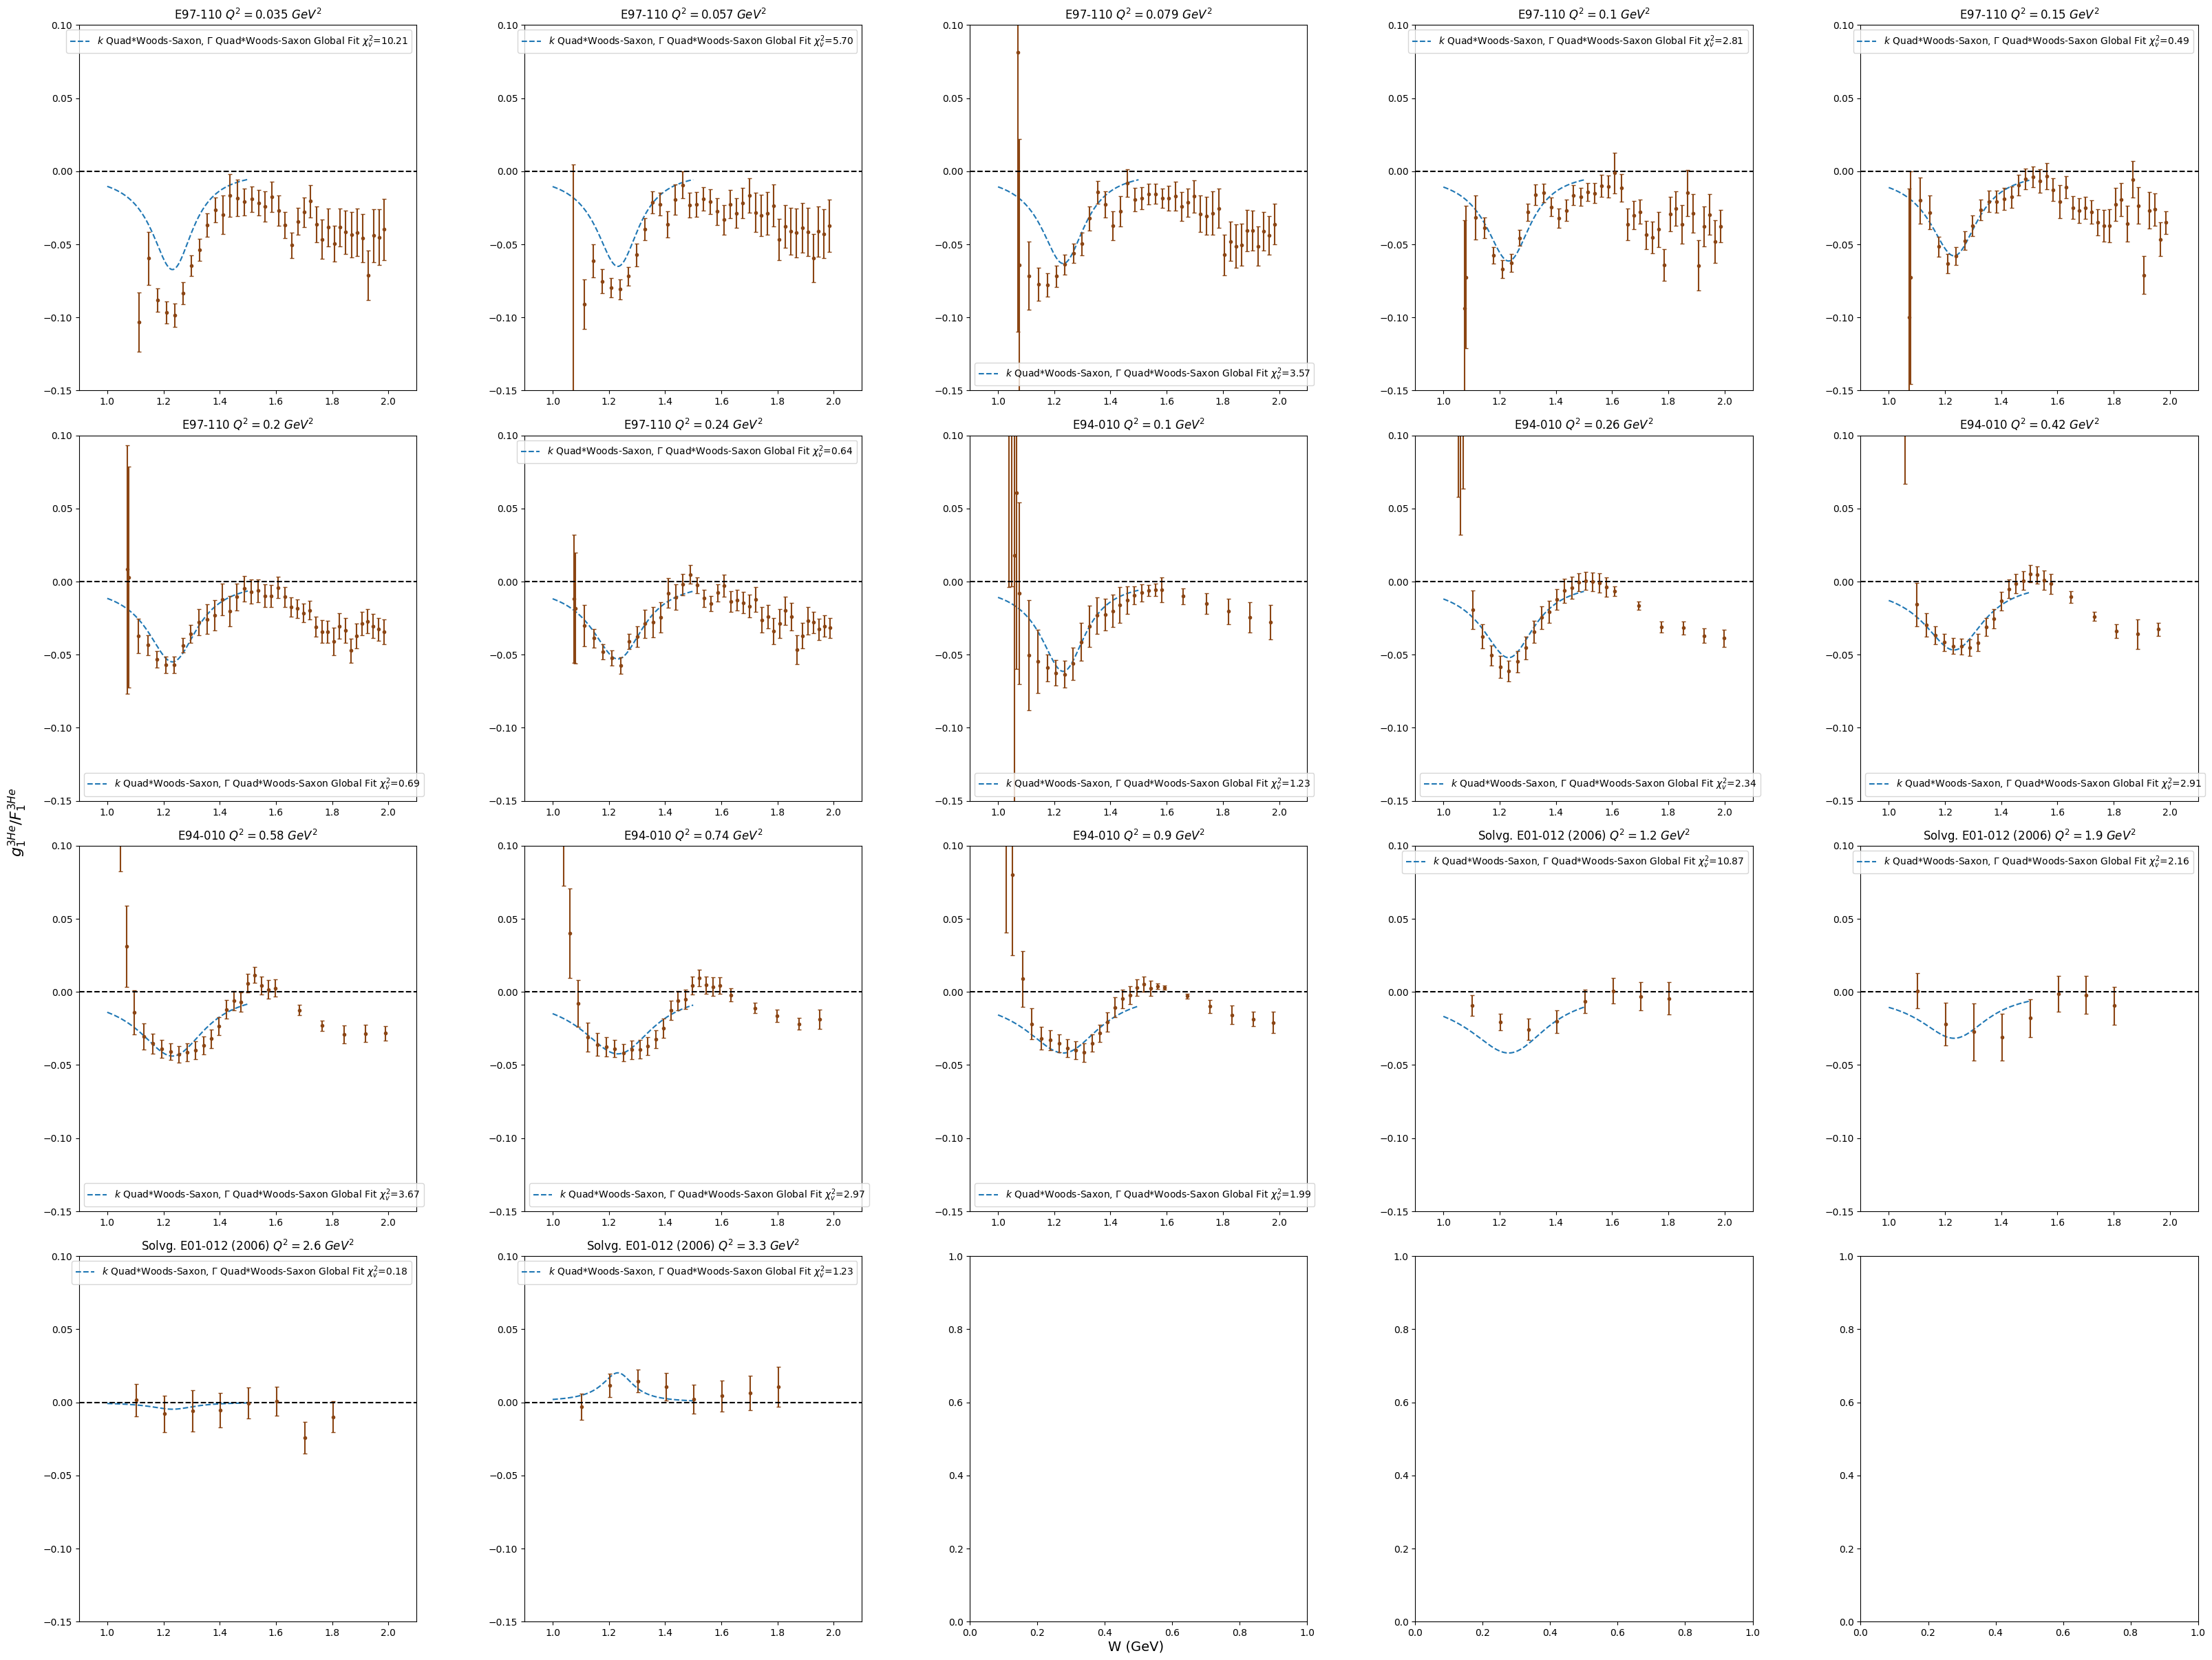

In [22]:

colors = ("saddlebrown", "red", "darkorange", "darkolivegreen")

# make figure
n_col = 5
num_plots = len(res_df['Q2_labels'].unique())
n_rows = num_plots//n_col + 1
fig, axs = plt.subplots(num_plots//n_col + 1, n_col, figsize=(n_col*6.5,n_rows*6))

w = np.linspace(1.0, 1.5, 1000, dtype=np.double)

# make fit curves and plot with data|
for i,l in enumerate(res_df['Q2_labels'].unique()):
  row = i//n_col
  col = i%n_col

  q2 = res_df['Q2'][res_df['Q2_labels']==l].unique()[0]
  k_fit_params = [k_nucl_par]
  gamma_fit_params = [gam_nucl_par]
  fit_funcs = [quad_nucl_curve]
  fit_names = ["Quad*Woods-Saxon"]

  # use the 4 following lines if you want to plot all the other types of fits I tried (don't forget to uncomment the other fits first!)
  # k_fit_params = [k_lin_par, k_quad_par, k_cub_par, k_nucl_par]
  # gamma_fit_params = [gam_lin_par, gam_quad_par, gam_cub_par, gam_nucl_par]
  # fit_funcs = [lin_curve, quad_curve, cubic_curve, quad_nucl_curve]
  # fit_names = ["Linear", "Quadratic", "Cubic", "Quad*Woods-Saxon"]


  # select desired k, gamma fits to be used by index
  # [(i, j),...] where i=index for k fit, j=index for gamma fit
  # 0 = linear, 1 = quadratic, 2 = cubic, 3=quad-nucl_potential
  chosen_fits=[(0,0), (1,0), (1,1)]

  # have a 3 fits for both k and gamma -> 9 possible combinations
  for i in range(len(k_fit_params)):

    k_params = k_fit_params[i]
    args = [q2]

    for j in range(len(gamma_fit_params)):

      if (i, j) not in chosen_fits:
        # skip combinations that aren't desired
        continue

      gam_params = gamma_fit_params[j]

      if i==1:
        # spline k
        k = fit_funcs[i](*k_params)(q2)
      else:
        k_args = args + [p for p in k_params]
        if i==0:
          # add constant parameters P0, P1, P2 for Woods-Saxon
          k_args += k_P_vals
        k = fit_funcs[i](*k_args)


      if j==1:
        # spline gamma
        gamma = fit_funcs[j](*gam_params)(q2)
      else:
        gamma_args = args + [p for p in gam_params]
        if j==0:
          # add constant parameters P0, P1, P2 for Woods-Saxon
          gamma_args += gam_P_vals
        gamma = fit_funcs[j](*gamma_args)

      # calculate fitted curve
      y = breit_wigner_res(w, 1.232, k, gamma)

      # try getting a chi squared for this curve for 1.0<W<1.5
      W = res_df['W'][res_df['Q2_labels']==l][res_df['W']<=1.5][res_df['W']>=1.0]
      y_cal = breit_wigner_res(W, 1.232, k, gamma)
      y_act = res_df['G1F1'][res_df['Q2_labels']==l][res_df['W']<=1.5][res_df['W']>=1.0]
      y_act_err = res_df['G1F1.err'][res_df['Q2_labels']==l][res_df['W']<=1.5][res_df['W']>=1.0]
      nu = len(y_act)-2 # n points minus 2 fitted parameters (k and gamma)
      chi2 = red_chi_sqr(y_cal, y_act, y_act_err, nu)

      axs[row, col].plot(w, y, markersize=m_size,
                        label=f"$k$ {fit_names[i]}, $\Gamma$ {fit_names[j]} Global Fit $\chi_v^2$={chi2:.2f}",
                         linestyle='dashed')


  # plot the data
  axs[row, col].errorbar(res_df['W'][res_df['Q2_labels']==l],
                res_df['G1F1'][res_df['Q2_labels']==l],
                yerr=res_df['G1F1.err'][res_df['Q2_labels']==l],
                fmt=m_type, color=colors[0], markersize=m_size, capsize=cap_size,
                capthick=cap_thick)

  axs[row,col].legend()
  # set axes limits
  axs[row,col].axhline(0, color="black", linestyle="--")
  axs[row,col].set_ylim(-.15,0.1)
  axs[row,col].set_xlim(0.9,2.1)
  axs[row,col].set_title(l)

fig.tight_layout()
fig.text(0.5, 0.001, "W (GeV)", ha='center', va='center', size = 14)
fig.text(0.0001, 0.5, "$g_1^{3He}/F_1^{3He}$", ha='center', va='center', rotation='vertical', size=16)
# plt.savefig(f"/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1_res_k_gamma_delta_curves_2.pdf", bbox_inches = "tight")

### Try extending DIS Fit to resonance region and see how it looks

Text(0.0001, 0.5, '$g_1^{3He}/F_1^{3He}$')

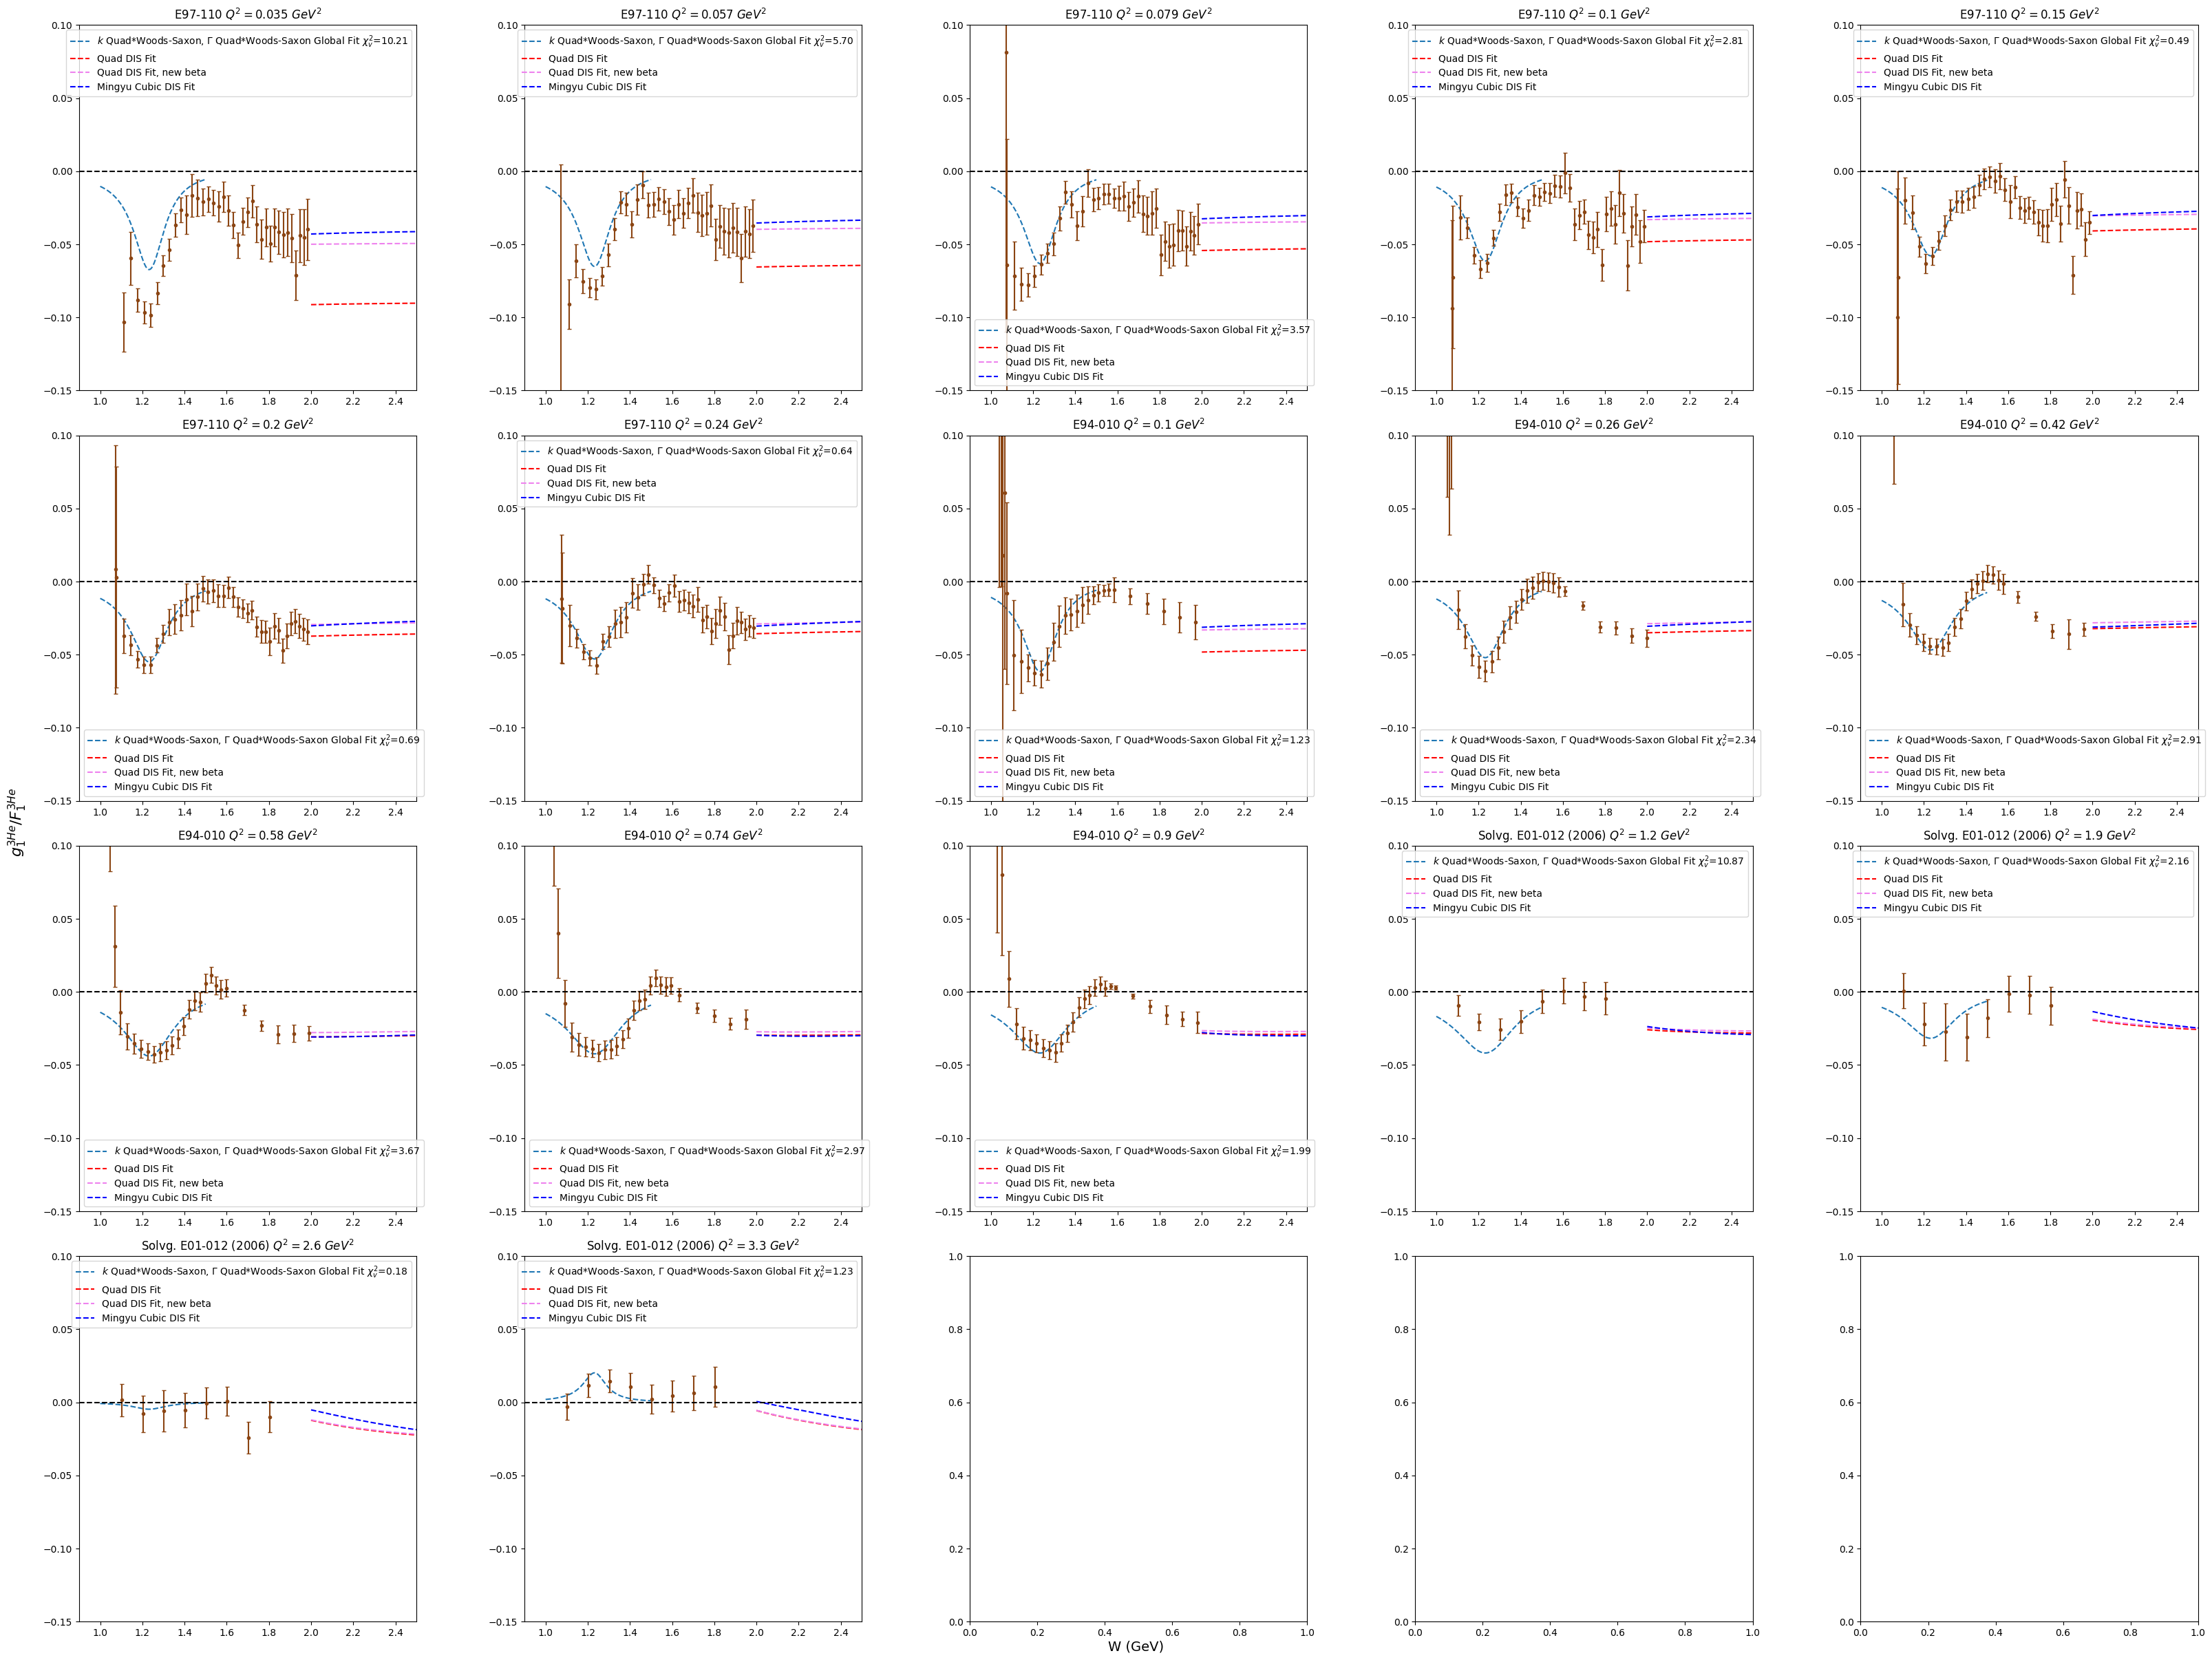

In [24]:
# make figure
n_col = 5
num_plots = len(res_df['Q2_labels'].unique())
n_rows = num_plots//n_col + 1
fig, axs = plt.subplots(num_plots//n_col + 1, n_col, figsize=(n_col*6.5,n_rows*6))

w = np.linspace(1.0, 1.5, 1000, dtype=np.double)


# make fit curves and plot with data
for i,l in enumerate(res_df['Q2_labels'].unique()):
  row = i//n_col
  col = i%n_col

  q2 = res_df['Q2'][res_df['Q2_labels']==l].unique()[0]
  k_fit_params = [k_nucl_par]
  gamma_fit_params = [gam_nucl_par]
  fit_funcs = [quad_nucl_curve]
  fit_names = ["Quad*Woods-Saxon"]



  # select desired k, gamma fits to be used by index
  # [(i, j),...] where i=index for k fit, j=index for gamma fit
  chosen_fits=[(0,0), (1,0), (1,1)]

  for i in range(len(k_fit_params)):

    k_params = k_fit_params[i]
    args = [q2]

    for j in range(len(gamma_fit_params)):

      if (i, j) not in chosen_fits:
        # skip combinations that aren't desired
        continue

      gam_params = gamma_fit_params[j]

      if i==1:
        # spline k
        k = fit_funcs[i](*k_params)(q2)
      else:
        k_args = args + [p for p in k_params]
        if i==0:
          # add constant parameters P0, P1, P2 for Woods-Saxon
          k_args += k_P_vals
        k = fit_funcs[i](*k_args)


      if j==1:
        # spline gamma
        gamma = fit_funcs[j](*gam_params)(q2)
      else:
        gamma_args = args + [p for p in gam_params]
        if j==0:
          # add constant parameters P0, P1, P2 for Woods-Saxon
          gamma_args += gam_P_vals
        gamma = fit_funcs[j](*gamma_args)

      # calculate fitted curve
      y = breit_wigner_res(w, 1.232, k, gamma)

      # try getting a chi squared for this curve for 1.0<W<1.5
      W = res_df['W'][res_df['Q2_labels']==l][res_df['W']<=1.5][res_df['W']>=1.0]
      y_cal = breit_wigner_res(W, 1.232, k, gamma)
      y_act = res_df['G1F1'][res_df['Q2_labels']==l][res_df['W']<=1.5][res_df['W']>=1.0]
      y_act_err = res_df['G1F1.err'][res_df['Q2_labels']==l][res_df['W']<=1.5][res_df['W']>=1.0]
      nu = len(y_act)-2 # n points minus 2 fitted parameters (k and gamma)
      chi2 = red_chi_sqr(y_cal, y_act, y_act_err, nu)

      axs[row, col].plot(w, y, markersize=m_size,
                        label=f"$k$ {fit_names[i]}, $\Gamma$ {fit_names[j]} Global Fit $\chi_v^2$={chi2:.2f}",
                         linestyle='dashed')


  # extend DIS model to W=2 GeV and plot
  # original DIS fit params x0, y0, c, beta
  quad2_dis_par = [0.16424, -.02584, 0.16632, 0.11059]
  w_dis = np.linspace(2.0,3.0,1000)
  q2_array = np.ones(w_dis.size)*q2
  x_dis = W_to_x(w_dis, q2_array)
  y_dis = g1f1_quad2_DIS([x_dis, q2_array], quad2_dis_par[0], quad2_dis_par[1],
                        quad2_dis_par[2], quad2_dis_par[3])

  axs[row, col].plot(w_dis, y_dis, color="r", label="Quad DIS Fit", linestyle="--")

  # quadratic DIS fit using mingyu fit beta value
  quad2_dis_par = [0.16424, -.02584, 0.16632, 0.04469]
  y_dis_new = g1f1_quad2_DIS([x_dis, q2_array], quad2_dis_par[0], quad2_dis_par[1],
                        quad2_dis_par[2], quad2_dis_par[3])

  axs[row, col].plot(w_dis, y_dis_new, color="violet", label="Quad DIS Fit, new beta", linestyle="--")

  # mingyu cubic DIS fit params a, b, c, d, beta
  cube_dis_par = [-.0171, -.16611, 0.68161, -.56782, 0.04469]
  y_cube_dis = g1f1_cubic_DIS([x_dis, q2_array], cube_dis_par[0], cube_dis_par[1],
                        cube_dis_par[2], cube_dis_par[3], cube_dis_par[4])

  axs[row, col].plot(w_dis, y_cube_dis, color="b", label="Mingyu Cubic DIS Fit", linestyle="--")


  # plot the data
  axs[row, col].errorbar(res_df['W'][res_df['Q2_labels']==l],
                res_df['G1F1'][res_df['Q2_labels']==l],
                yerr=res_df['G1F1.err'][res_df['Q2_labels']==l],
                fmt=m_type, color=colors[0], markersize=m_size, capsize=cap_size,
                capthick=cap_thick)

  axs[row,col].legend()
  # set axes limits
  axs[row,col].axhline(0, color="black", linestyle="--")
  axs[row,col].set_ylim(-.15,0.1)
  axs[row,col].set_xlim(0.9,2.5)
  axs[row,col].set_title(l)

fig.tight_layout()
fig.text(0.5, 0.001, "W (GeV)", ha='center', va='center', size = 14)
fig.text(0.0001, 0.5, "$g_1^{3He}/F_1^{3He}$", ha='center', va='center', rotation='vertical', size=16)
# plt.savefig(f"/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1_res_k_gamma_delta_curves_2.pdf", bbox_inches = "tight")

## Fit $g_1/F_1$ DIS data with neutron form from Xiaochao's thesis
$g_1/F_1 = (a+bx+cx^2)(1+β/Q^2)$

Downward trend cubic form
$g_1/F_1 = (a+bx+cx^2+dx^3)(1+β/Q^2)$

In [ ]:
# combine Mingyu data and g1f1_df
temp_df = pd.DataFrame(
    {
        "Q2": mingyu_df["Q2"],
        "W": mingyu_df["W.cal"],
        "X": mingyu_df["x"],
        "G1F1": mingyu_df["g1F1_3He"],
        "G1F1.err": mingyu_df["g1f1.err"],
        "Label": ["Mingyu" for x in range(len(mingyu_df["Q2"]))],
    }
)

# temp_df.head()

dis_df = g1f1_df
dis_df = pd.concat([temp_df, g1f1_df], ignore_index=True) # add Mingyu data
print(dis_df.head(100))

       Q2         W         X      G1F1  G1F1.err    Label
0   6.410  3.119787  0.420000 -0.013650  0.009195   Mingyu
1   6.580  3.042320  0.440000 -0.000160  0.004083   Mingyu
2   6.870  2.990977  0.460000 -0.004690  0.004467   Mingyu
3   7.180  2.890368  0.490000  0.000910  0.004923   Mingyu
4   7.450  2.785334  0.520000  0.004780  0.003561   Mingyu
..    ...       ...       ...       ...       ...      ...
95  0.057  1.461800  0.043393 -0.009333  0.009025  E97-110
96  0.057  1.487300  0.041047 -0.023284  0.008383  E97-110
97  0.057  1.512300  0.038942 -0.022676  0.008499  E97-110
98  0.057  1.536900  0.037043 -0.018772  0.008005  E97-110
99  0.057  1.561200  0.035320 -0.020887  0.008589  E97-110

[100 rows x 6 columns]


In [ ]:
# make dataframe of DIS values (W>2 && Q2>1)
dis_df = dis_df[dis_df['W']>2.0]
dis_df = dis_df[dis_df['Q2']>1.0]

dis_df.head(100)

# from Xiaochao's thesis
def g1f1_quad_DIS(x_q2, a, b , c, beta):
  return (a+b*x_q2[0]+c*x_q2[0]*x_q2[0])*(1+(beta/x_q2[1]))

# different form for quad to constrain minimum
# y = c*(x-x0)^2 + y0 where (x0, y0) is the minimum
def g1f1_quad2_DIS(x_q2, x0, y0, c, beta):
  return (c*(x_q2[0]-x0)**2+y0)*(1+(beta/x_q2[1]))

# guess form for downward trend at high x
def g1f1_cubic_DIS(x_q2, a, b , c, d, beta):
  return (a + b*x_q2[0] + c*x_q2[0]*x_q2[0] + d*x_q2[0]*x_q2[0]*x_q2[0])*(1+(beta/x_q2[1]))

In [ ]:
# independent variable data to feed to curve fit, X and Q2
indep_data = [dis_df['X'], dis_df['Q2']]

# fit g1f1 DIS data with cubic form
# initial guess for a,b,c,d,beta
cubic_dis_init = (-.03, -.02, 0.3, -.22, 0.1)
par_cub, cov_cub, par_err_cub, chi2_cub = fit(g1f1_cubic_DIS, indep_data,
                                              dis_df['G1F1'],
                                              dis_df['G1F1.err'],
                                              cubic_dis_init,
                                              ["a", "b", "c", "d", "beta"])

# fit the g1f1 DIS data with constrained quadratic form
quad2_init = [0.18, -.03, 0, 0.04469]
quad2_constr = ([0.16, -.05,-np.inf, 0.043],
                [0.2, -.025, np.inf, 0.046]) # min and max bounds on x0, y0, c, and beta
par_quad, cov_quad, par_err_quad, chi2_quad = fit(g1f1_quad2_DIS, indep_data,
                                                  dis_df['G1F1'],
                                                  dis_df['G1F1.err'],
                                                  quad2_init,
                                                  ["x0", "y0", "c", "beta"],
                                                  constr=quad2_constr)


╒════════════════════╤════════════════════╤═══════════════════╤════════════════════╤═══════════════════╕
│ a                  │ b                  │ c                 │ d                  │ beta              │
╞════════════════════╪════════════════════╪═══════════════════╪════════════════════╪═══════════════════╡
│ -0.01710 ± 0.00317 │ -0.16611 ± 0.04787 │ 0.68161 ± 0.15048 │ -0.56782 ± 0.12568 │ 0.04469 ± 0.19626 │
╘════════════════════╧════════════════════╧═══════════════════╧════════════════════╧═══════════════════╛
$\chi_v^2$ = 0.99
╒═══════════════════╤════════════════════╤═══════════════════╤═══════════════════╕
│ x0                │ y0                 │ c                 │ beta              │
╞═══════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 0.16000 ± 0.05633 │ -0.02500 ± 0.00316 │ 0.12443 ± 0.03013 │ 0.04300 ± 0.28719 │
╘═══════════════════╧════════════════════╧═══════════════════╧═══════════════════╛
$\chi_v^2$ = 2.50


In [ ]:
# Generate fitted curve using the fitted parameters for constant q2
x = np.linspace(0,1.0,1000, dtype=np.double)
q2 = np.full(x.size, 5.0) # array of q2 = 5.0 GeV^2

args3 = [[x, q2]] + [p for p in par_cub]
args2 = [[x, q2]] + [p for p in par_quad]

cubic_fit_curve = g1f1_cubic_DIS(*args3)
quad_fit_curve = g1f1_quad2_DIS(*args2)

In [ ]:
# determine uncertainty in the fit
# partial functions for quadratic and cubic forms
# 2 means for quad form, 3 means for cubic form

def partial_a2(x, q2, par):
  """1 + beta/Q2"""
  return 1 + par[3]/q2

def partial_a3(x, q2, par):
  """1 + beta/Q2"""
  return 1 + par[4]/q2

def partial_b2(x, q2, par):
  """X*(1 + beta/Q2)"""
  return x*(1 + par[3]/q2)

def partial_b3(x, q2, par):
  """X*(1 + beta/Q2)"""
  return x*(1 + par[4]/q2)

def partial_c2(x, q2, par):
  """X^2*(1 + beta/Q2)"""
  return x*x*(1 + par[3]/q2)

def partial_c3(x, q2, par):
  """X^2*(1 + beta/Q2)"""
  return x*x*(1 + par[4]/q2)

def partial_beta2(x, q2, par):
  """1/Q^2*(a+bx+cx^2)"""
  return (1/q2)*(par[0]+par[1]*x+par[2]*x*x)

def partial_beta3(x, q2, par):
  """1/Q^2*(a+bx+cx^2)"""
  return (1/q2)*(par[0]+par[1]*x+par[2]*x*x+par[3]*x*x*x)

def partial_d3(x, q2, par):
  """x^3 * (1 + beta/Q2)"""
  return x*x*x*(1 + par[4]/q2)

# partials for constrained quadratic form
def partial_x0(x, q2, par):
  """[-2c * (x - x0)](1 + beta/Q2)"""
  return (-2*par[2] * (x - par[0]))*(1 + par[3]/q2)

def partial_y0(x, q2, par):
  """(1 + beta/Q2)"""
  return (1 + par[3]/q2)

def partial_c4(x, q2, par):
  """(x-x0)^2(1 + beta/Q2)"""
  return (x-par[0])**2 * (1 + par[3]/q2)

def partial_beta4(x, q2, par):
  """(c(x-x0)^2 + y0)(1/Q2)"""
  return (par[2]*(x-par[0])**2 + par[1]) * (1/q2)

# # list of partials for parameters (index 0 is for a -> index 3 is for beta)
partials2 = [partial_a2, partial_b2, partial_c2, partial_beta2]

# list of partials for parameters (index 0 is for a -> index 4 is for beta)
partials3 = [partial_a3, partial_b3, partial_c3, partial_d3, partial_beta3]

# list of partials for constrained quadratic form
partials4 = [partial_x0, partial_y0, partial_c4, partial_beta4]

def fit_error(x, q2, par, par_sigmas, pcov, partials):
  """
  Equation F.5 from Xiaochao's thesis
  x: X array
  q2: Q2 array
  par: fit parameters
  par_sigmas: list of errors in parameters
  pcov: covariance matrix
  partials: list of partial functions for the fit function
  return: array of errors in fitted points
  """
  # initialize fit variance array
  y_err = np.zeros(len(x))

  for i in range(len(par)):
    y_err += np.square(partials[i](x,q2,par)) * 1.0 * par_sigmas[i]**2

    for j in range(i+1, len(par)):
      # print(i, j)
      y_err += 2 * partials[i](x,q2,par) * partials[j](x,q2,par) * pcov[i][j]

  return np.sqrt(y_err)


In [ ]:
cubic_fit_err = fit_error(x, q2, par_cub, par_err_cub, cov_cub, partials3)

# quad_fit_err = fit_error(x, q2, par_quad, par_err_quad, cov_quad, partials2)
quad_fit_err = fit_error(x, q2, par_quad, par_err_quad, cov_quad, partials4)

Text(0.001, 0.56, '$g_1^{^{3}He}/F_1^{^{3}He}$')

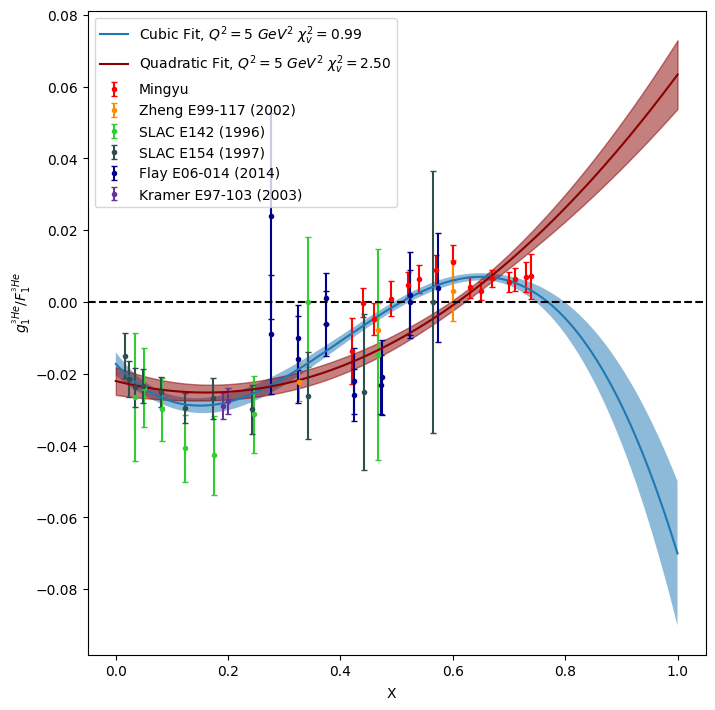

In [ ]:
# make figure
fig, (ax1) = plt.subplots(1, 1, figsize=(7,7))

# formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
colors = ("red", "darkorange", "limegreen",
          "darkslategray", "darkblue", "rebeccapurple",
          "darkmagenta")

# plot w/ labels
for i,l in enumerate(dis_df['Label'].unique()):
  ax1.errorbar(dis_df['X'][dis_df['Label']==l],
                dis_df['G1F1'][dis_df['Label']==l],
                yerr=dis_df['G1F1.err'][dis_df['Label']==l],
                fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
                label=l, capthick=cap_thick)


# plot fit and fit error
ax1.plot(x, cubic_fit_curve, label="Cubic Fit, $Q^2=5\ {GeV}^2$" + f" $\chi_v^2={chi2_cub:.2f}$")
ax1.fill_between(x, cubic_fit_curve-cubic_fit_err, cubic_fit_curve+cubic_fit_err, alpha=0.5)
ax1.plot(x, quad_fit_curve, label="Quadratic Fit, $Q^2=5\ {GeV}^2$" + f" $\chi_v^2={chi2_quad:.2f}$", color="darkred")
ax1.fill_between(x, quad_fit_curve-quad_fit_err, quad_fit_curve+quad_fit_err, alpha=0.5, color="darkred")
ax1.axhline(y=0, color="black", linestyle="dashed")

ax1.legend()
fig.tight_layout()
fig.text(0.53, 0.001, "X", ha='center', va='center')
fig.text(0.001, 0.56, '$g_1^{^{3}He}/F_1^{^{3}He}$', ha='center', va='center', rotation='vertical')
# plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1vx_dis_quadfit.png", bbox_inches = "tight")
# plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1vx_dis_quad&cubefit_mingyu.png", bbox_inches = "tight")
# plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1vx_dis_cubefit_mingyu.png", bbox_inches = "tight")

## Old Work when I tried fitting the other resonances...

### Fit and Plot 1440 MeV Resonance

Solvg. E01-012 (2006) $Q^2=1.2\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Solvg. E01-012 (2006) $Q^2=1.2\ GeV^2$ Fit Parameters
╒═══════════════════╤════════════════════╤═══════════════════╕
│ M                 │ k                  │ gamma             │
╞═══════════════════╪════════════════════╪═══════════════════╡
│ 1.29502 ± 0.02064 │ -0.00404 ± 0.00175 │ 0.29855 ± 0.07827 │
├───────────────────┼────────────────────┼───────────────────┤
│ 1.44              │ 0.00000 ± 0.00000  │ 0.00000 ± 0.00000 │
╘═══════════════════╧════════════════════╧═══════════════════╛
Solvg. E01-012 (2006) $Q^2=1.9\ GeV^2$ Fit Parameters
╒═══════════════════╤════════════════════╤═══════════════════╕
│ M                 │ k                  │ gamma             │
╞═══════════════════╪════════════════════╪═══════════════════╡
│ 1.34500 ± 0.02942 │ -0.00560 ± 0.00303 │ 0.30202 ± 0.10640 │
├───────────────────┼────────────────────┼─────────

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


E97-110 $Q^2=0.035\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
E97-110 $Q^2=0.035\ GeV^2$ Fit Parameters
╒═══════════════╤═══════════════════╤═══════════════════╕
│ M             │ k                 │ gamma             │
╞═══════════════╪═══════════════════╪═══════════════════╡
│ 0.96044 ± inf │ -0.02941 ± inf    │ 0.00003 ± inf     │
├───────────────┼───────────────────┼───────────────────┤
│ 1.44          │ 0.00000 ± 0.00000 │ 0.00000 ± 0.00000 │
╘═══════════════╧═══════════════════╧═══════════════════╛
E97-110 $Q^2=0.057\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
E97-110 $Q^2=0.057\ GeV^2$ Fit Parameters
╒═══════════════════╤════════════════════╤═══════════════════╕
│ M                 │ k                  │ gamma             │
╞═══════════════════╪════════════════════╪═══════════════════╡
│ 1.40395 ± 0.02581 │ -0.00173 ± 0.00204 │ 0.1789

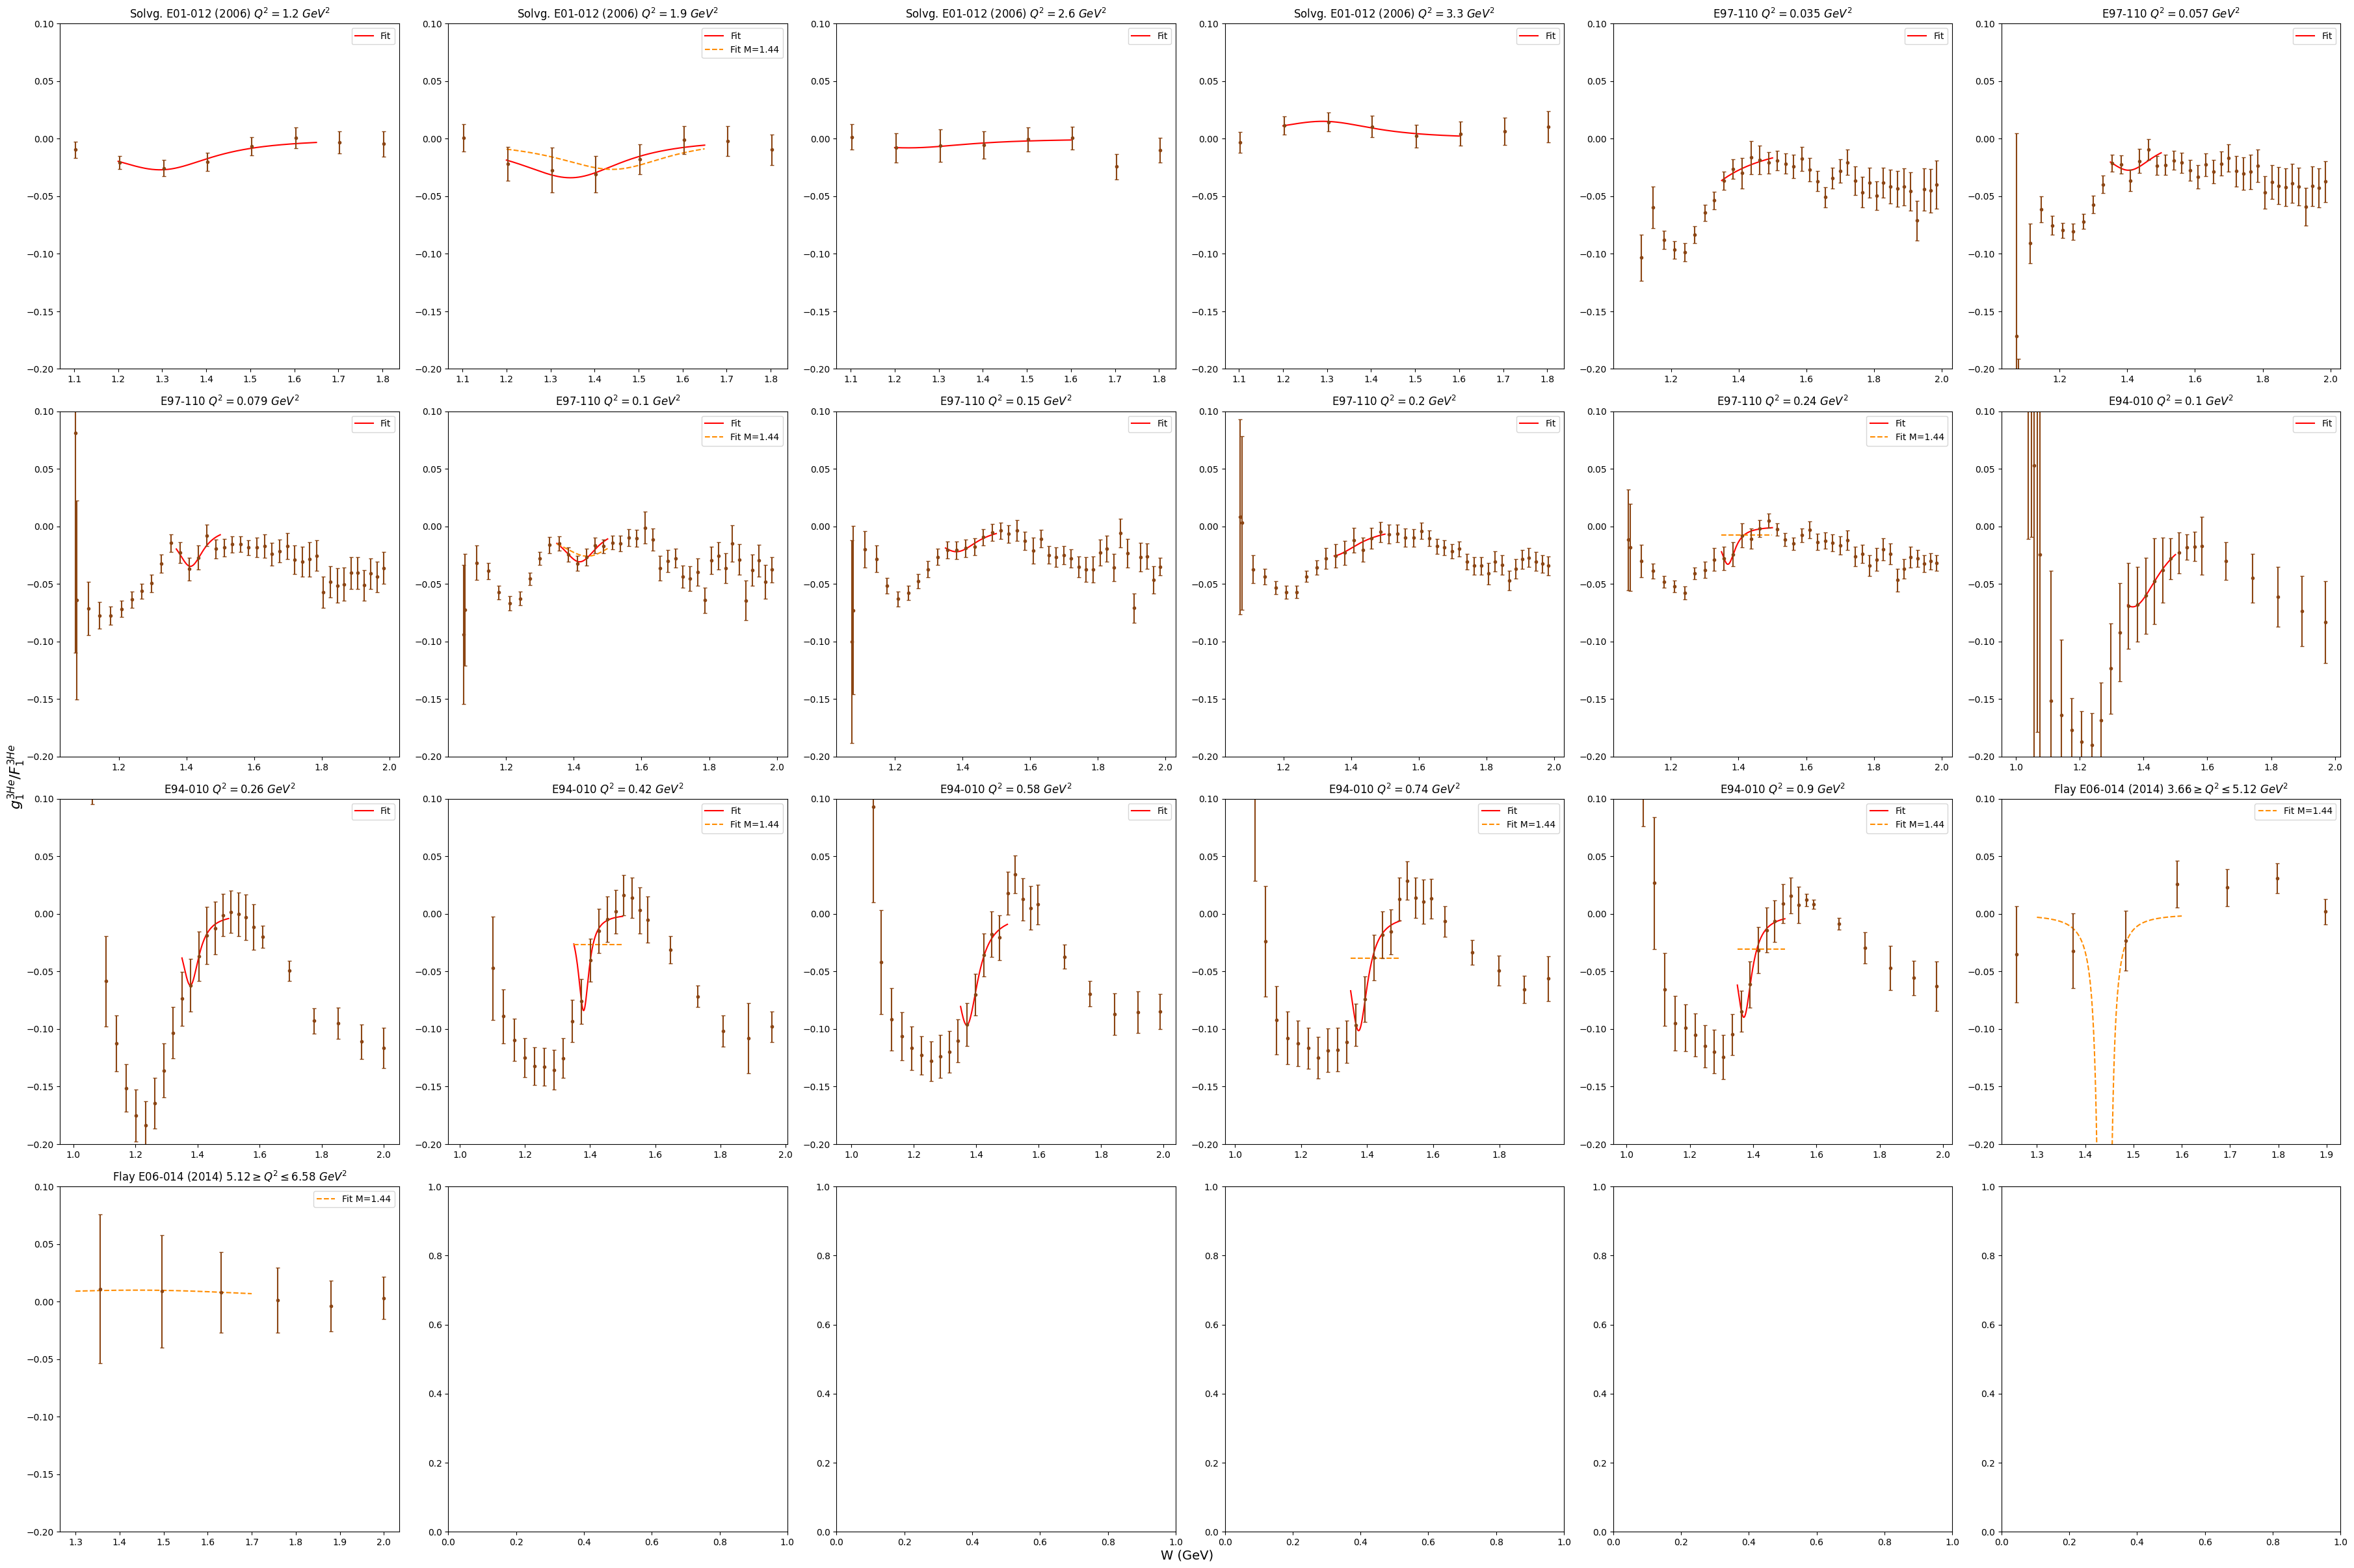

In [ ]:
## fit W=1.440 resonance
# initial guesses for k and M
k_init = [-.002, -.002, -.002, -.002,
          -.002, -.0005, -.002, -.002,
          -.002, -.002, -.002, -.002,
          -.002, -.002, -.002, -.002,
          -.002, -.002, -.002]

m_init = [1.45, 1.45, 1.4, 1.4,
          1.4, 1.41, 1.4, 1.4,
          1.4, 1.42, 1.4, 1.4,
          1.5, 1.5, 1.55, 1.55,
          1.5, 1.45, 1.45]

gamma_init = [0.05, 0.05, 0.05, 0.05,
          0.05, 0.1, 0.05, 0.05,
          0.05, 0.05, 0.05, 0.05,
          0.05, 0.05, 0.05, 0.05,
          0.05, 0.05, 0.05]

w_lims = [(1.2, 1.65), (1.2, 1.65), (1.2, 1.6), (1.2, 1.6),
          (1.35, 1.5), (1.35, 1.5), (1.37, 1.5), (1.35, 1.5),
          (1.35, 1.5), (1.35, 1.5), (1.35, 1.5), (1.35, 1.5),
          (1.35, 1.5), (1.35, 1.5), (1.35, 1.5), (1.35, 1.5),
          (1.35, 1.5), (1.3, 1.6), (1.3, 1.7)]

fit_breit_wigner(w_bounds=w_lims, M=1.440, region_name="1440MeV")

### Fit and Plot 1520/1535 MeV Resonance peak

Solvg. E01-012 (2006) $Q^2=1.2\ GeV^2$ Fit Parameters
╒═══════════════════╤═════════════════════════════╤════════════════════════════╕
│ M                 │ k                           │ gamma                      │
╞═══════════════════╪═════════════════════════════╪════════════════════════════╡
│ 1.43969 ± 0.04925 │ -0.00022 ± 0.00083          │ -0.00000 ± 1033.37424      │
├───────────────────┼─────────────────────────────┼────────────────────────────┤
│ 1.535             │ -289.06103 ± 67427380.23790 │ 122.24249 ± 14331640.43136 │
╘═══════════════════╧═════════════════════════════╧════════════════════════════╛
Solvg. E01-012 (2006) $Q^2=1.9\ GeV^2$ Fit Parameters
╒═══════════════╤════════════════════╤═══════════════════╕
│ M             │ k                  │ gamma             │
╞═══════════════╪════════════════════╪═══════════════════╡
│ 1.44703 ± inf │ -0.00048 ± inf     │ 0.00000 ± inf     │
├───────────────┼────────────────────┼───────────────────┤
│ 1.535         │ -0.00730 ± 0

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Solvg. E01-012 (2006) $Q^2=2.6\ GeV^2$ Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Solvg. E01-012 (2006) $Q^2=2.6\ GeV^2$ Fit Parameters
╒═══════════════════╤════════════════════════════════╤═════════════════════════════╕
│ M                 │ k                              │ gamma                       │
╞═══════════════════╪════════════════════════════════╪═════════════════════════════╡
│ 0.00000 ± 0.00000 │ 0.00000 ± 0.00000              │ 0.00000 ± 0.00000           │
├───────────────────┼────────────────────────────────┼─────────────────────────────┤
│ 1.535             │ -1324.38017 ± 2388845312.52964 │ 290.08580 ± 263103675.19233 │
╘═══════════════════╧════════════════════════════════╧═════════════════════════════╛
Solvg. E01-012 (2006) $Q^2=3.3\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Solvg. E01-012 (2006) $Q^2=3.3\ GeV^2$ Fit Parameters
╒═══════════

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Flay E06-014 (2014) $3.66 \geq Q^2 \leq 5.12\ GeV^2$ Fit Parameters
╒═══════════════╤═════════════════════════════╤═════════════════════════════╕
│ M             │ k                           │ gamma                       │
╞═══════════════╪═════════════════════════════╪═════════════════════════════╡
│ 1.64240 ± inf │ 0.00068 ± inf               │ -0.00000 ± inf              │
├───────────────┼─────────────────────────────┼─────────────────────────────┤
│ 1.535         │ 355.85742 ± 170757467.65548 │ -122.52128 ± 29618939.30041 │
╘═══════════════╧═════════════════════════════╧═════════════════════════════╛
Flay E06-014 (2014) $5.12 \geq Q^2 \leq 6.58\ GeV^2$ Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Flay E06-014 (2014) $5.12 \geq Q^2 \leq 6.58\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Flay E06-014 (2014) $5.12 \geq Q^2 \leq 6.58\ GeV^2$ Fit Parameters
╒════

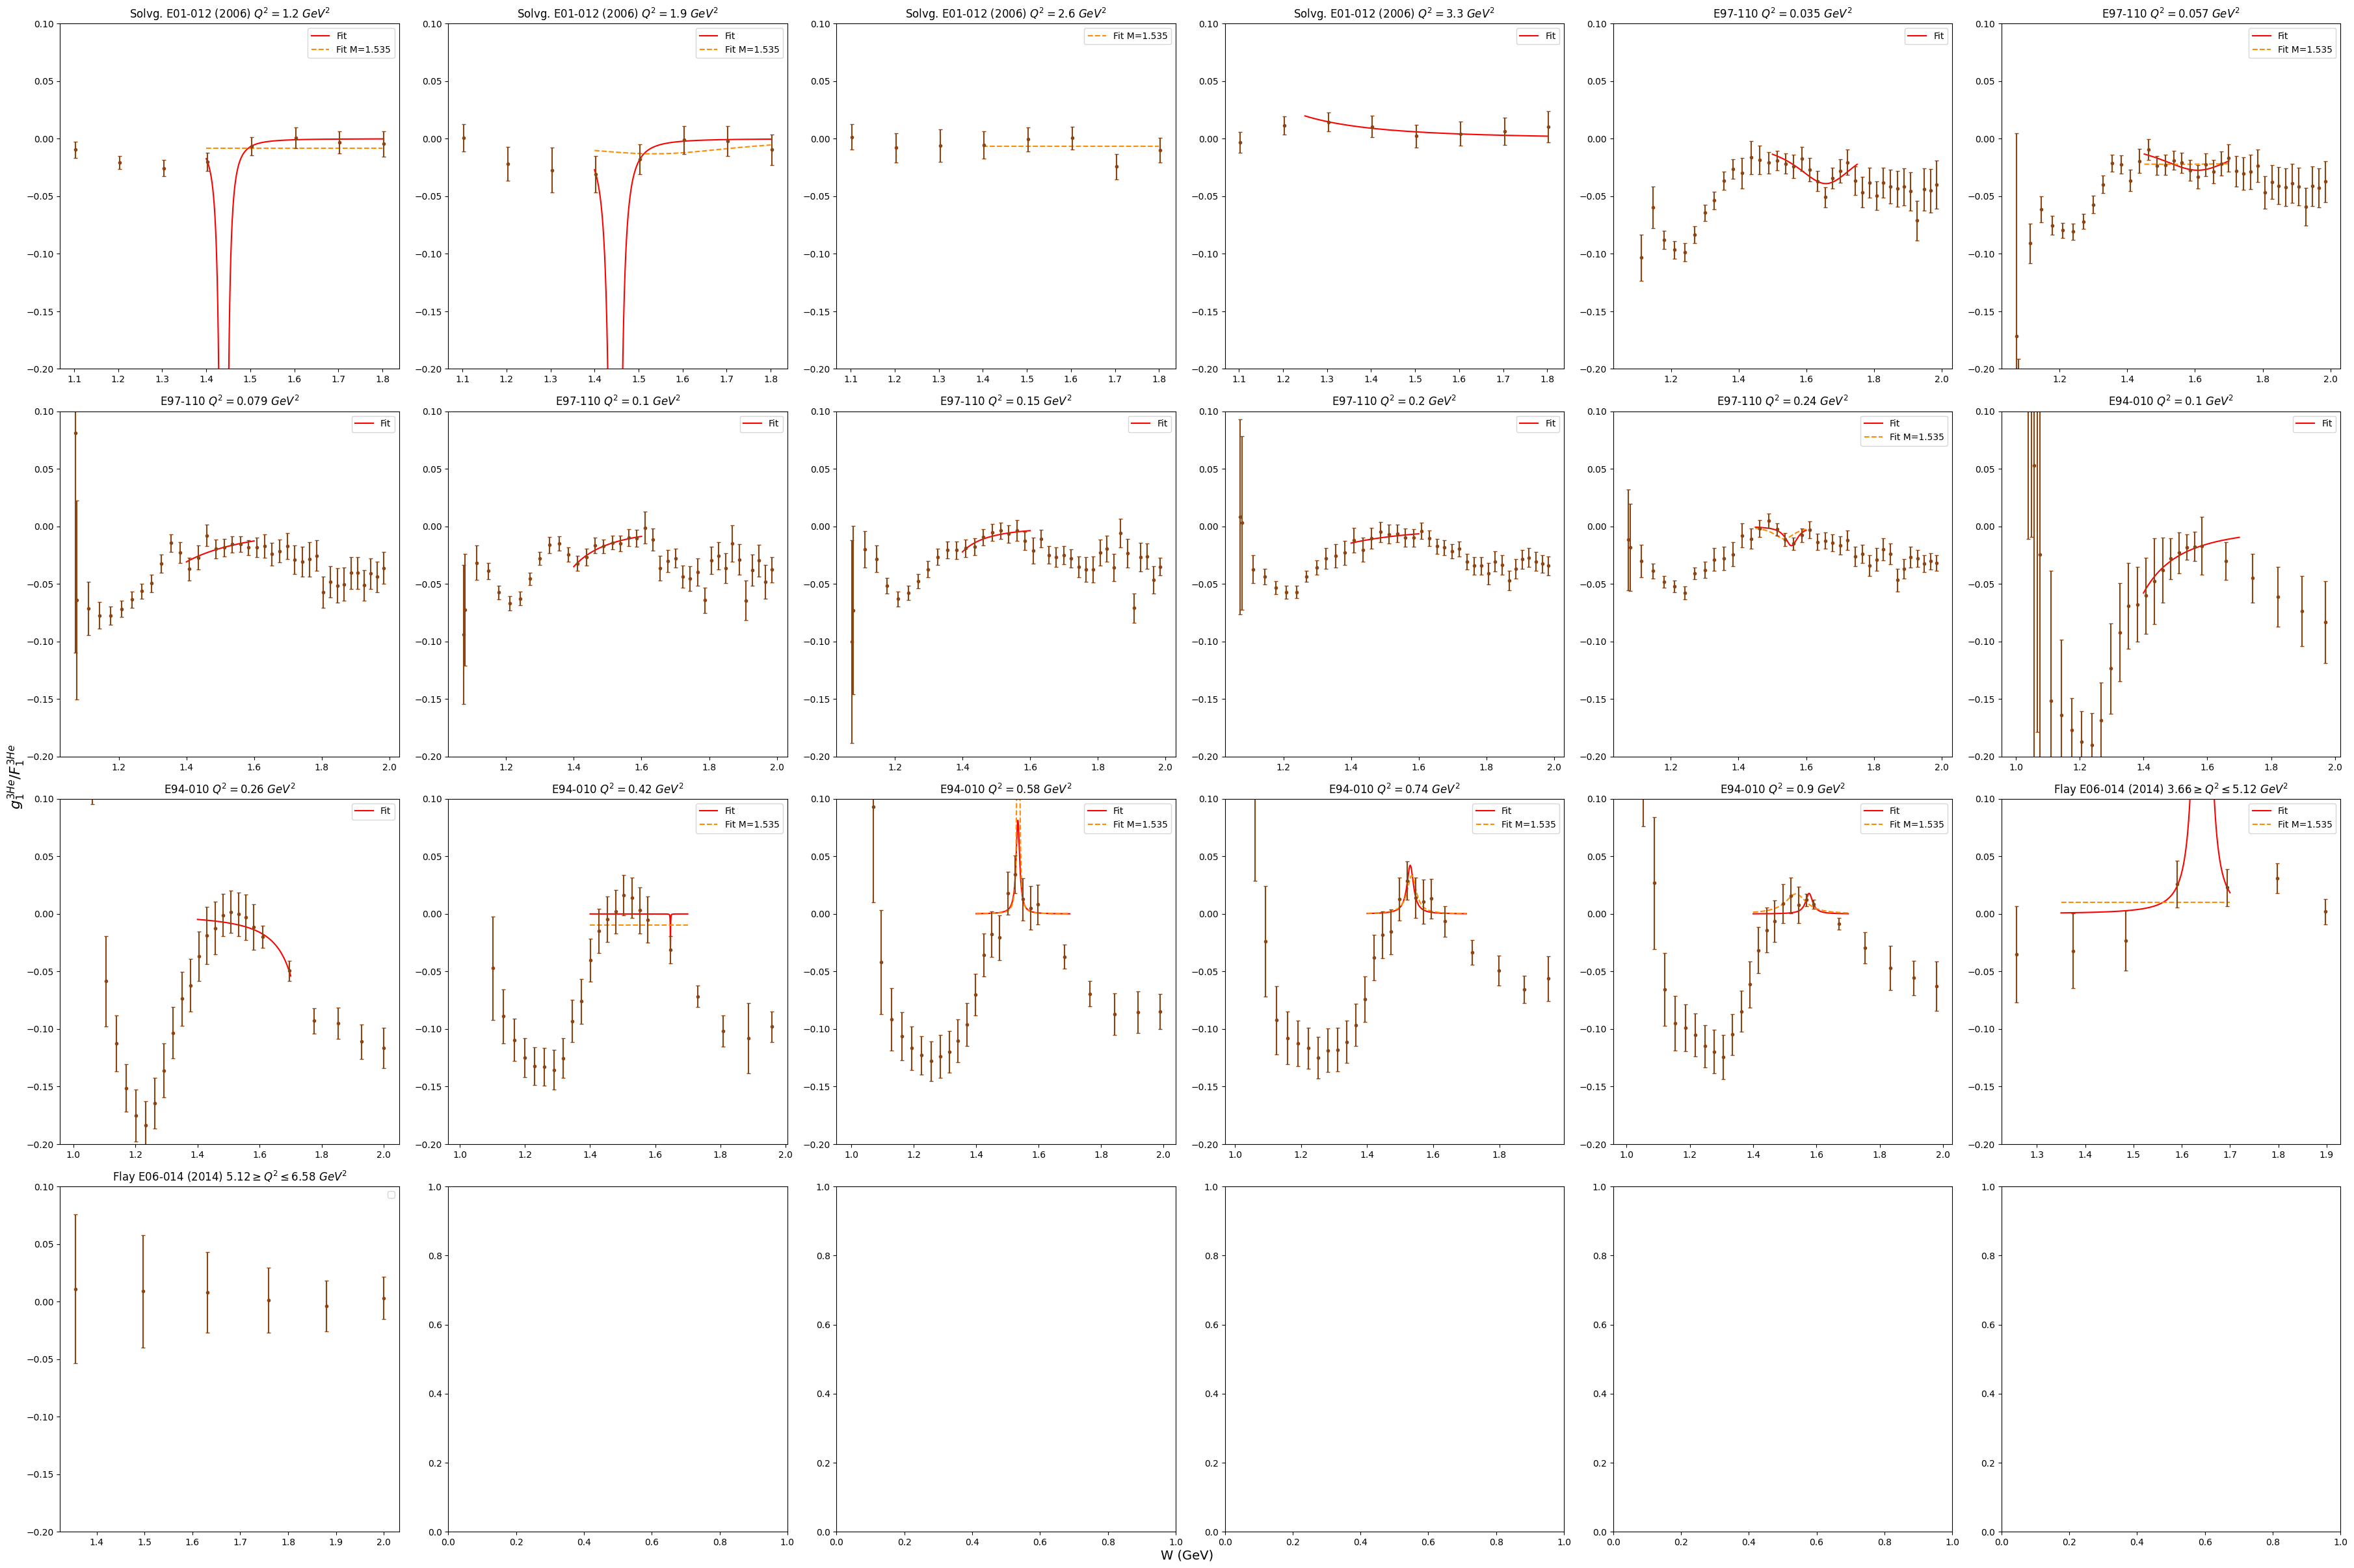

In [ ]:
## fit W=1.535 resonance
# initial guesses for k and M
k_init = [-.002, -.002, -.002, -.002,
          -.002, -.0005, -.002, -.002,
          -.002, -.002, -.002, -.002,
          -.002, -.002, -.002, -.002,
          -.002, -.002, -.002]

m_init = [1.53, 1.53, 1.53, 1.52,
          1.6, 1.6, 1.53, 1.53,
          1.53, 1.53, 1.58, 1.53,
          1.53, 1.53, 1.53, 1.53,
          1.53, 1.53, 1.53]

gamma_init = [0.05, 0.05, 0.05, 0.1,
          0.05, 0.1, 0.05, 0.05,
          0.05, 0.05, 0.05, 0.05,
          0.05, 0.05, 0.05, 0.05,
          0.05, 0.05, 0.05]

w_lims = [(1.4, 1.8), (1.4, 1.8), (1.4, 1.8), (1.25, 1.8),
          (1.5, 1.75), (1.45, 1.7), (1.4, 1.6), (1.4, 1.6),
          (1.4, 1.6), (1.4, 1.6), (1.45, 1.6), (1.4, 1.7),
          (1.4, 1.7), (1.4, 1.7), (1.4, 1.7), (1.4, 1.7),
          (1.4, 1.7), (1.35, 1.7), (1.35, 1.7)]

fit_breit_wigner(w_bounds=w_lims, M=1.535, region_name="1535MeV")

### Fit and Plot 1675/1680 MeV Resonance peak

Solvg. E01-012 (2006) $Q^2=1.2\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Solvg. E01-012 (2006) $Q^2=1.2\ GeV^2$ Fit Parameters
╒═══════════════════════╤════════════════════╤═══════════════════════════╕
│ M                     │ k                  │ gamma                     │
╞═══════════════════════╪════════════════════╪═══════════════════════════╡
│ -0.00010 ± 5243.38634 │ -0.02277 ± 0.12939 │ 5.68219 ± 477684270.91430 │
├───────────────────────┼────────────────────┼───────────────────────────┤
│ 1.68                  │ 0.00000 ± 0.00000  │ 0.00000 ± 0.00000         │
╘═══════════════════════╧════════════════════╧═══════════════════════════╛


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Solvg. E01-012 (2006) $Q^2=1.9\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Solvg. E01-012 (2006) $Q^2=1.9\ GeV^2$ Fit Parameters
╒═══════════════╤═══════════════════╤═══════════════════╕
│ M             │ k                 │ gamma             │
╞═══════════════╪═══════════════════╪═══════════════════╡
│ 0.00000 ± inf │ -0.05556 ± inf    │ 2.46652 ± inf     │
├───────────────┼───────────────────┼───────────────────┤
│ 1.68          │ 0.00000 ± 0.00000 │ 0.00000 ± 0.00000 │
╘═══════════════╧═══════════════════╧═══════════════════╛
Solvg. E01-012 (2006) $Q^2=2.6\ GeV^2$ Fit Parameters
╒═══════════════╤════════════════════╤═══════════════════╕
│ M             │ k                  │ gamma             │
╞═══════════════╪════════════════════╪═══════════════════╡
│ 1.74262 ± inf │ -0.00045 ± inf     │ 0.00000 ± inf     │
├───────────────┼────────────────────┼───────────────────┤
│ 1.68          │ -0.00017 ± 0.00038 │ 0.01

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Solvg. E01-012 (2006) $Q^2=3.3\ GeV^2$ Fit Parameters
╒═══════════════════╤═══════════════════╤═══════════════════╕
│ M                 │ k                 │ gamma             │
╞═══════════════════╪═══════════════════╪═══════════════════╡
│ 1.85975 ± 0.07281 │ 0.00463 ± 0.00249 │ 0.33802 ± 0.04558 │
├───────────────────┼───────────────────┼───────────────────┤
│ 1.68              │ 0.00394 ± 0.01022 │ 0.47011 ± 0.69735 │
╘═══════════════════╧═══════════════════╧═══════════════════╛
E97-110 $Q^2=0.035\ GeV^2$ Constant M Fit Failed
   Optimal parameters not found: Number of calls to function has reached maxfev = 600.
E97-110 $Q^2=0.035\ GeV^2$ Fit Parameters
╒═══════════════════╤════════════════════╤═══════════════════╕
│ M                 │ k                  │ gamma             │
╞═══════════════════╪════════════════════╪═══════════════════╡
│ 1.90983 ± 0.03787 │ -0.03607 ± 0.02059 │ 0.44699 ± 0.12720 │
├───────────────────┼────────────────────┼───────────────────┤
│ 1.68             

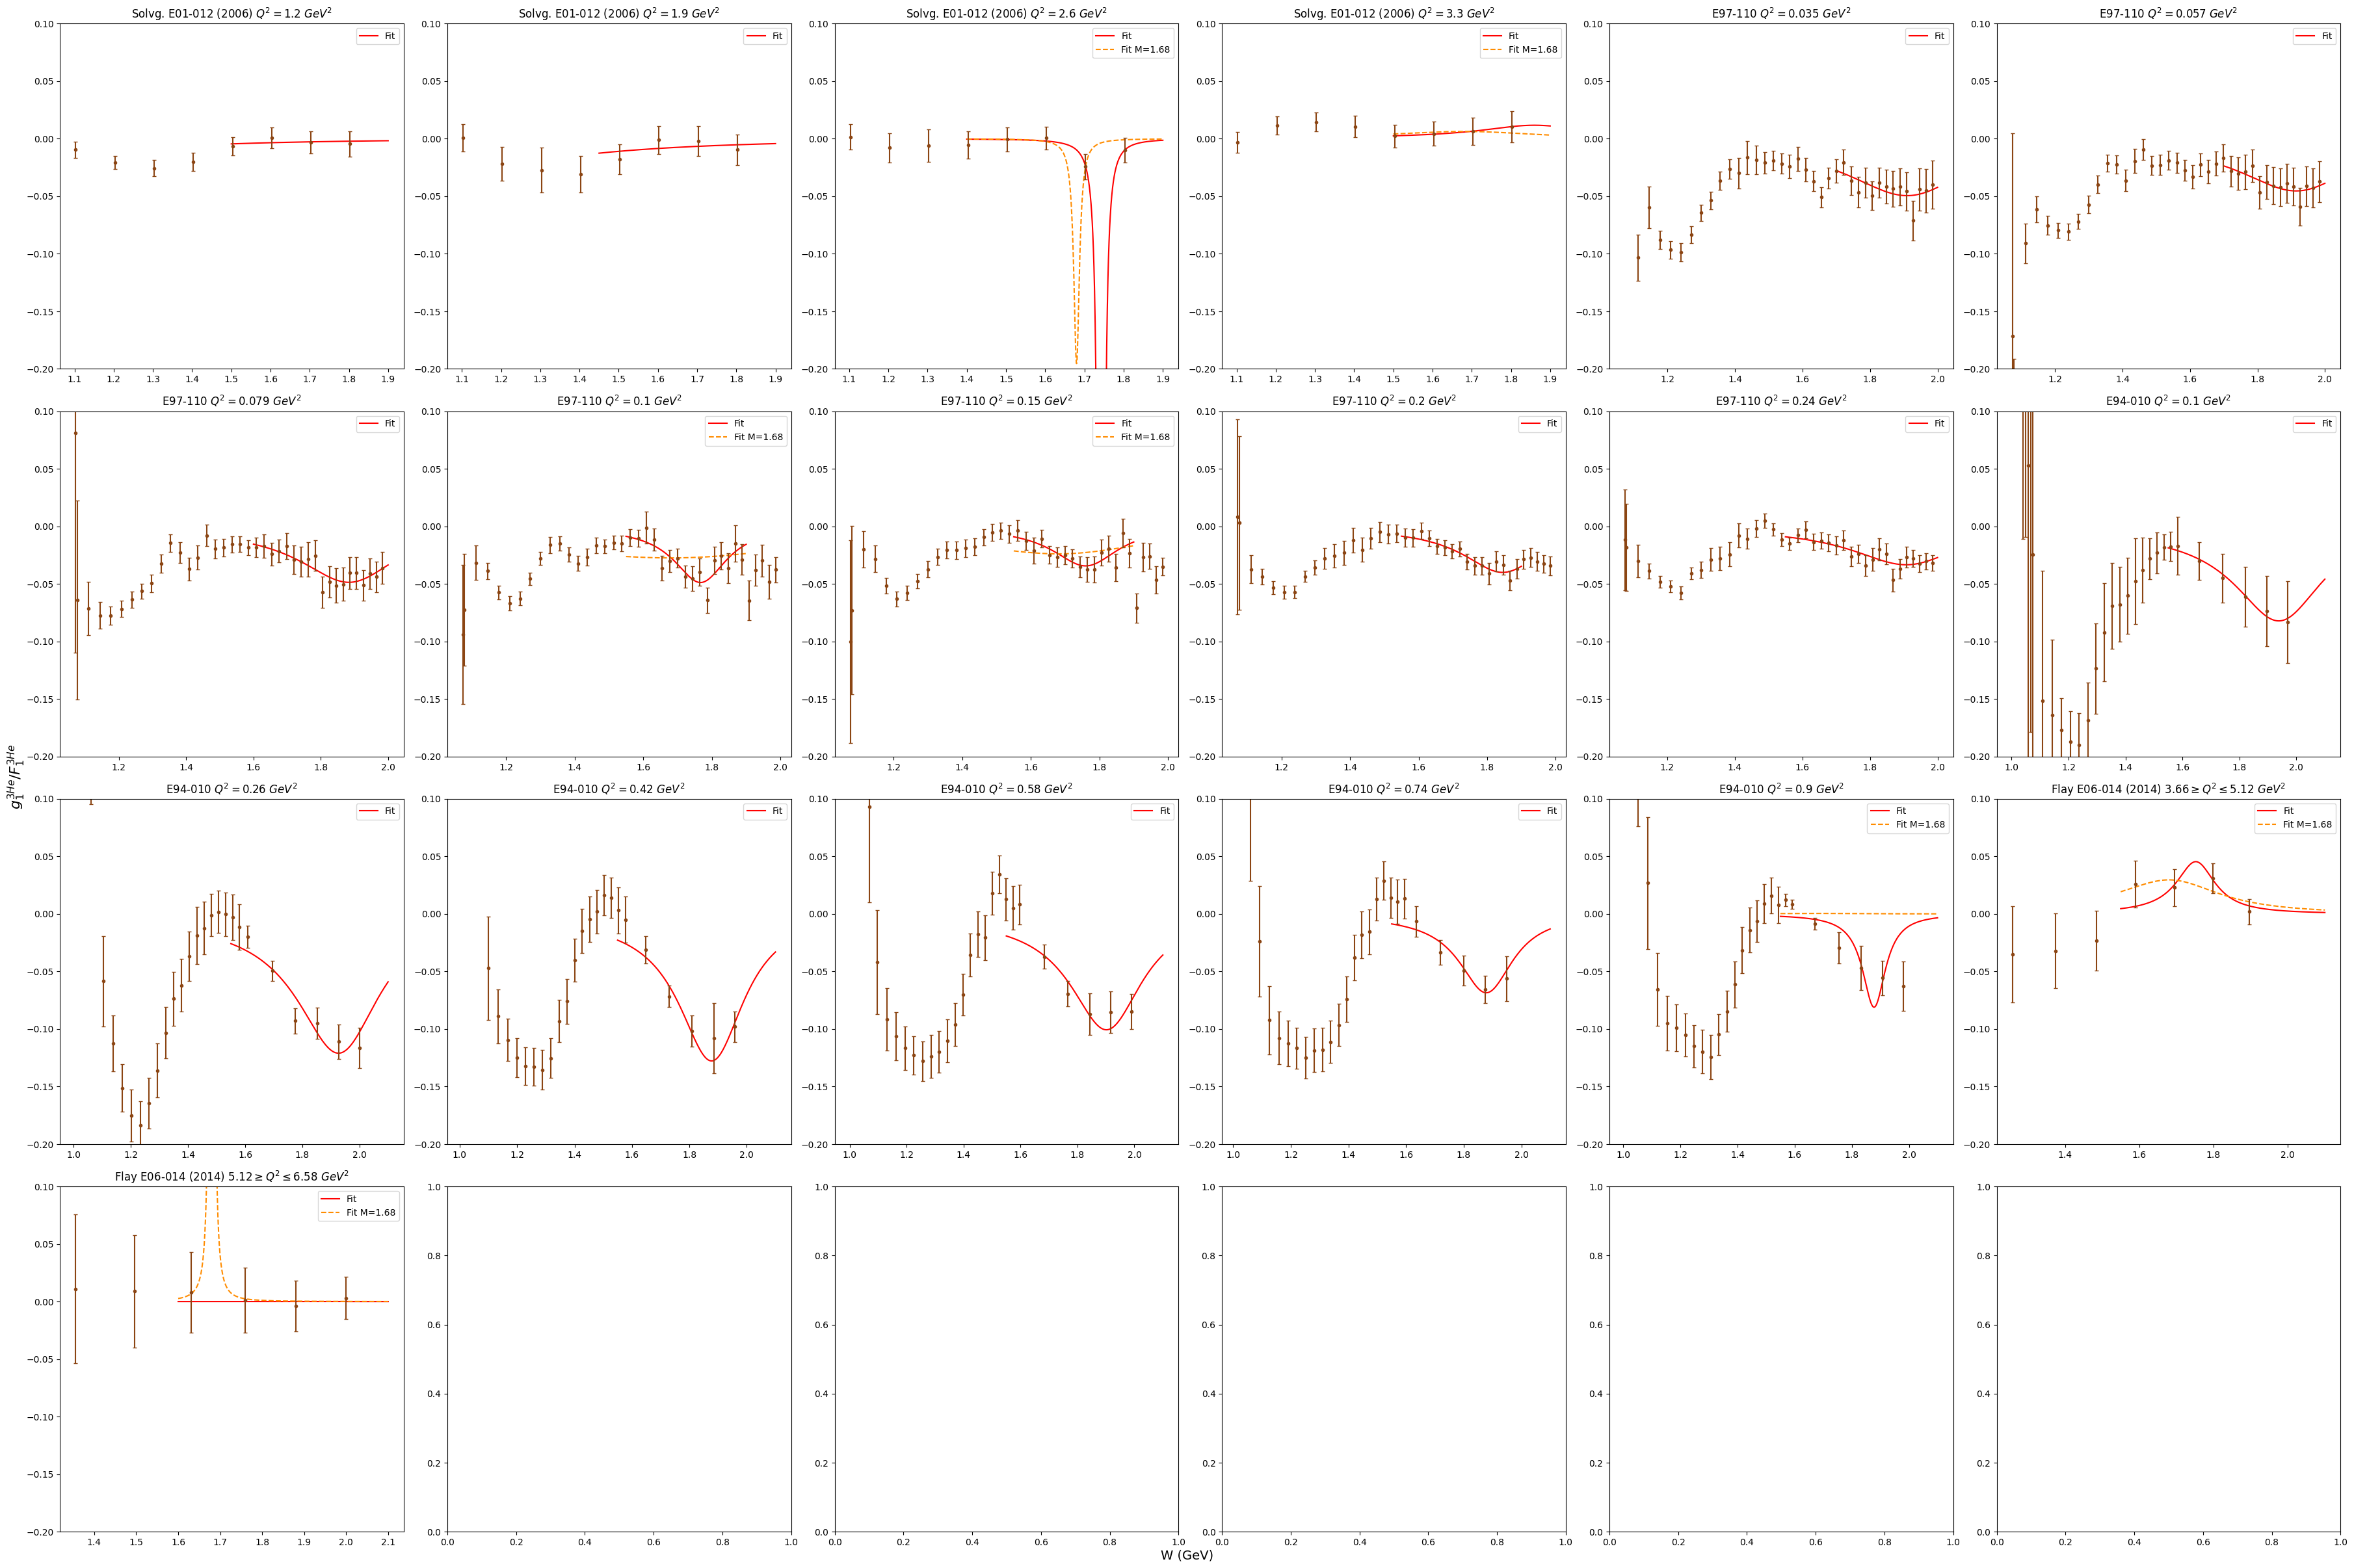

In [ ]:
## fit W=1.68 resonance
# initial guesses for k and M
k_init = [-.002, -.002, -.005, -.002,
          -.002, -.0005, -.002, -.002,
          -.002, -.002, -.002, -.002,
          -.002, -.002, -.002, -.002,
          -.002, -.002, -.002]

m_init = [1.7, 1.7, 1.7, 1.7,
          1.8, 1.8, 1.8, 1.7,
          1.7, 1.7, 1.8, 1.9,
          1.8, 1.8, 1.8, 1.8,
          1.8, 1.7, 1.75]

gamma_init = [0.05, 0.05, 0.2, 0.05,
          0.05, 0.05, 0.05, 0.05,
          0.05, 0.05, 0.05, 0.05,
          0.05, 0.05, 0.05, 0.05,
          0.05, 0.05, 0.05]

w_lims = [(1.5, 1.9), (1.45, 1.9), (1.4, 1.9), (1.5, 1.9),
          (1.7, 2.0), (1.7, 2.0), (1.6, 2.0), (1.55, 1.9),
          (1.55, 1.9), (1.55, 1.9), (1.55, 2.0), (1.55, 2.1),
          (1.55, 2.1), (1.55, 2.1), (1.55, 2.1), (1.55, 2.1),
          (1.55, 2.1), (1.55, 2.1), (1.6, 2.1)]

fit_breit_wigner(w_bounds=w_lims, M=1.680, region_name="1680MeV")

### Plot k and gamma versus Q2

KeyError: '1440MeV.k.fit'

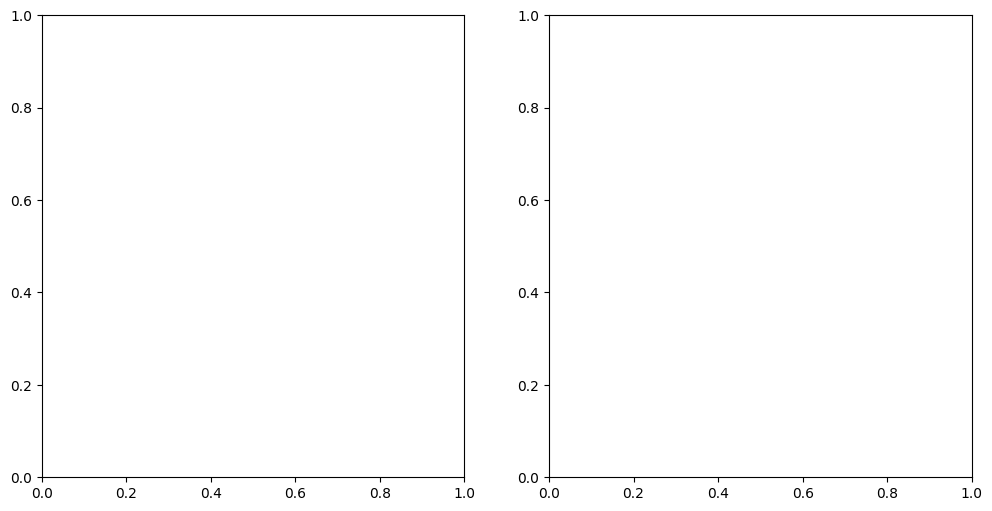

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
k_list = []
k_err_list = []
gamma_list = []
gamma_err_list = []
q2_list = []
label_list = []

# maintain distinct colors between plots by keeping track of the index in the color map
color_index = 0

# def append_params(q2, k, k_err, gamma, gamma_err, label):
#   q2_list += list(q2)
#   k_list += list(k)
#   k_err_list += list(k_err)
#   gamma_list += list(gamma)
#   gamma_err_list += list(gamma_err)
#   label_list += [label for x in range(len(q2))]


# go through each experiment and plot the fit parameters k and gamma from the constant M fit
# versus Q2 for the 1232 MeV region
for i,l in enumerate(res_df['Label'].unique()):
  if l != "Flay E06-014 (2014)":
    q2 = res_df['Q2'][res_df['Label'] == l][res_df['1232MeV.k_constm.fit'] != 0].unique()
  else:
    q2 = []
    for name in res_df['Q2_labels'][res_df['Label'] == l].unique():
      q2.append(res_df['Q2'][res_df['Q2_labels'] == name][res_df['1232MeV.k_constm.fit'] != 0].mean())

  k = res_df['1232MeV.k_constm.fit'][res_df['Label'] == l][res_df['1232MeV.k_constm.fit'] != 0].unique()
  k_err = res_df['1232MeV.k_constm.fit.err'][res_df['Label'] == l][res_df['1232MeV.k_constm.fit'] != 0].unique()
  gamma = res_df['1232MeV.gamma_constm.fit'][res_df['Label'] == l][res_df['1232MeV.k_constm.fit'] != 0].unique()
  gamma_err = res_df['1232MeV.gamma_constm.fit.err'][res_df['Label'] == l][res_df['1232MeV.k_constm.fit'] != 0].unique()

  # add the parameters to the lists
  # append_params(q2, k, k_err, gamma, gamma_err, f"{l} 1232 MeV Resonance")
  q2_list += list(q2)
  k_list += list(k)
  k_err_list += list(k_err)
  gamma_list += list(gamma)
  gamma_err_list += list(gamma_err)
  label_list += [f"{l} 1232 MeV Resonance" for x in range(len(q2))]




# go through each experiment and plot the fit parameters k and gamma versus Q2 for the 1440 MeV region
# only using fits for E97-110 bins that look good
good_fits = [0.057, 0.079, 0.1, 0.15, 0.24]
df = res_df[res_df['Label'] == "E97-110"] # pick out e97110
df = df[df['1440MeV.k.fit'] != 0] # remove the fits that failed
df = df[df['Q2'].isin(good_fits)] # remove rows for bins with bad fits

# add these values to the lists as well
# append_params(df['Q2'].unique(), df['1440MeV.k.fit'].unique(),
#               df['1440MeV.k.fit.err'].unique(),
#               df['1440MeV.gamma.fit'].unique(),
#               df['1440MeV.gamma.fit.err'].unique(),
#               "E97-110 1440 MeV Resonance")
q2_list += list(df['Q2'].unique())
k_list += list(df['1440MeV.k.fit'].unique())
k_err_list += list(df['1440MeV.k.fit.err'].unique())
gamma_list += list(df['1440MeV.gamma.fit'].unique())
gamma_err_list += list(df['1440MeV.gamma.fit.err'].unique())
label_list += [f"E97-110 1440 MeV Resonance" for x in range(len(df['Q2'].unique()))]




# plot the fit parameters k and gamma versus Q2 for the 1520/1535 region from E97-110
good_fits = [0.035, 0.057, 0.24]
df = res_df[res_df['Label'] == "E97-110"] # pick out e97110
df = df[df['1535MeV.k.fit'] != 0] # remove the fits that failed
df = df[df['Q2'].isin(good_fits)] # remove rows for bins with bad fits

# add these values to the lists as well
# append_params(df['Q2'].unique(), df['1535MeV.k.fit'].unique(),
#               df['1535MeV.k.fit.err'].unique(),
#               df['1535MeV.gamma.fit'].unique(),
#               df['1535MeV.gamma.fit.err'].unique(),
#               "E97-110 1535 MeV Resonance")
q2_list += list(df['Q2'].unique())
k_list += list(df['1535MeV.k.fit'].unique())
k_err_list += list(df['1535MeV.k.fit.err'].unique())
gamma_list += list(df['1535MeV.gamma.fit'].unique())
gamma_err_list += list(df['1535MeV.gamma.fit.err'].unique())
label_list += [f"E97-110 1535 MeV Resonance" for x in range(len(df['Q2'].unique()))]





# plot the fit parameters k and gamma versus Q2 for the 1675/1680 region from E97-110
good_fits = [0.035, 0.057, 0.079, 0.1, 0.15, 0.2, 0.24]
df = res_df[res_df['Label'] == "E97-110"] # pick out e97110
df = df[df['1680MeV.k.fit'] != 0] # remove the fits that failed
df = df[df['Q2'].isin(good_fits)] # remove rows for bins with bad fits

# add these values to the lists as well
# append_params(df['Q2'].unique(), df['1680MeV.k.fit'].unique(),
#               df['1680MeV.k.fit.err'].unique(),
#               df['1680MeV.gamma.fit'].unique(),
#               df['1680MeV.gamma.fit.err'].unique(),
#               "E97-110 1680 MeV Resonance")
q2_list += list(df['Q2'].unique())
k_list += list(df['1680MeV.k.fit'].unique())
k_err_list += list(df['1680MeV.k.fit.err'].unique())
gamma_list += list(df['1680MeV.gamma.fit'].unique())
gamma_err_list += list(df['1680MeV.gamma.fit.err'].unique())
label_list += [f"E97-110 1680 MeV Resonance" for x in range(len(df['Q2'].unique()))]



# get the fit parameters k and gamma versus Q2 for the 1675/1680 region from E94-010
good_fits = [0.1, 0.26, 0.42, 0.58, 0.74, 0.9]
df = res_df[res_df['Label'] == "E94-010"] # pick out e94010
df = df[df['1680MeV.k.fit'] != 0] # remove the fits that failed
df = df[df['Q2'].isin(good_fits)] # remove rows for bins with bad fits

# add these values to the lists as well
# append_params(df['Q2'].unique(), df['1680MeV.k.fit'].unique(),
#               df['1680MeV.k.fit.err'].unique(),
#               df['1680MeV.gamma.fit'].unique(),
#               df['1680MeV.gamma.fit.err'].unique(),
#               "E94-010 1680 MeV Resonance")
q2_list += list(df['Q2'].unique())
k_list += list(df['1680MeV.k.fit'].unique())
k_err_list += list(df['1680MeV.k.fit.err'].unique())
gamma_list += list(df['1680MeV.gamma.fit'].unique())
gamma_err_list += list(df['1680MeV.gamma.fit.err'].unique())
label_list += [f"E94-010 1680 MeV Resonance" for x in range(len(df['Q2'].unique()))]



# put the parameters into a separate dataframe
res_param_df = pd.DataFrame({"Q2": q2_list,
                             "k": k_list,
                             "k.err": k_err_list,
                             "gamma": gamma_list,
                             "gamma.err": gamma_err_list,
                             "label": label_list})


# plot all the parameters vs Q2
for i, label in enumerate(res_param_df["label"].unique()):
  axs[0].errorbar(res_param_df[res_param_df["label"]==label]["Q2"],
                  res_param_df[res_param_df["label"]==label]["k"],
                  yerr=res_param_df[res_param_df["label"]==label]["k.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=label, capthick=cap_thick)

  axs[1].errorbar(res_param_df[res_param_df["label"]==label]["Q2"],
                  res_param_df[res_param_df["label"]==label]["gamma"],
                  yerr=res_param_df[res_param_df["label"]==label]["gamma.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=label, capthick=cap_thick)

axs[0].set_ylabel("k")
axs[1].set_ylabel("$\Gamma$")

axs[0].legend()
axs[1].legend()

axs[1].set_ylim(-.25, 1.0)

fig.tight_layout()
fig.text(0.53, 0.001, "$Q^2\ ({GeV}^2)$", ha='center', va='center')
# plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/k_gamma_versusQ2.png", bbox_inches = "tight")

In [ ]:
def log_curve(x, a, b, c):
  return a*np.emath.logn(b, x) + c

def quad_curve(x, a, b, c):
  return a + b*x + c*np.square(x)

In [ ]:
# fit k with quadratic curve
quad_init = (0, -.3, 0.1)
params, covariance = curve_fit(quad_curve, res_param_df["Q2"], res_param_df["k"], p0=quad_init, sigma=res_param_df["k.err"])
# print(params)
# print(covariance)

param_sigmas = [np.sqrt(covariance[i][i]) for i in range(len(params))]

table = [
    [f"{params[i]:.5f} ± {param_sigmas[i]:.5f}" for i in range(len(params))]
    ]

# Define the headers for the table
headers = ["a", "b", "c"]

# Print the table
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒════════════════════╤═══════════════════╤════════════════════╕
│ a                  │ b                 │ c                  │
╞════════════════════╪═══════════════════╪════════════════════╡
│ -0.00085 ± 0.00060 │ 0.00276 ± 0.00270 │ -0.00091 ± 0.00093 │
╘════════════════════╧═══════════════════╧════════════════════╛


In [ ]:
# Generate fitted curve using the fitted parameters
q2 = np.linspace(0, res_param_df["Q2"].max(), 1000, dtype=np.double)
y = quad_curve(q2, params[0], params[1], params[2])

NameError: name 'res_param_df' is not defined

NameError: name 'res_param_df' is not defined

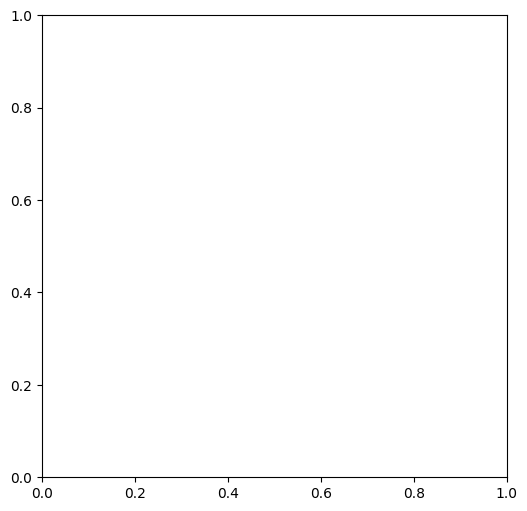

In [ ]:
# plot the fit with the data
fig, axs = plt.subplots(1, 1, figsize=(6,6))

# plot all the parameters vs Q2
for i, label in enumerate(res_param_df["label"].unique()):
  axs.errorbar(res_param_df[res_param_df["label"]==label]["Q2"],
                  res_param_df[res_param_df["label"]==label]["k"],
                  yerr=res_param_df[res_param_df["label"]==label]["k.err"], fmt=m_type,
                  color=colors[i], markersize=m_size, capsize=cap_size,
                  label=label, capthick=cap_thick)

axs.plot(q2, y, label="Quadratic Fit")
axs.legend()
axs.set_ylabel("k")
axs.set_xlabel("Q2 $({GeV}^2)$")
fig.tight_layout()

In [ ]:
log_init = (1, 2, 0)
params, covariance = curve_fit(log_curve, q2_list, k_list, p0=log_init, sigma=k_err_list)

TypeError: Cannot cast array data from dtype('complex128') to dtype('float64') according to the rule 'safe'

error: Result from function call is not a proper array of floats.

## Plot all g1/F1 and g2/F1 data

In [ ]:
# Plotting Code

# formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
colors = ("red", "darkorange", "limegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

def plot_dis_and_res(df, x_key, x_label, y_key, y_label, ax1_lims=[0,0], ax2_lims=[0,0]):
  """
  df: dataframe with data to plot in DIS and resonance regions
  x_key: string key for horizontal axis data to plot from the dataframe
  x_label: string label for horizontal axis of plot
  y_key: string key for data to plot from the dataframe
  y_label: string label for y axis of plot
  ax1_lims, ax2_lims: list arguments for bounds of x and y axes of both plots
      ex: [0,(0,1)] - restrict y axis to between 0 and 1
          [(-.2, .2), (0,1)] - restrict x axis to between -.2 and .2 and y axis to between 0 and 1
  """

  # make dataframe of Resonance values (1<W<2)
  res_df = df[df['W']<2.0]
  res_df = res_df[res_df['W']>1.0]

  # make dataframe of DIS values (W>2 && Q2>1)
  dis_df = df[df['W']>2.0]
  dis_df = dis_df[dis_df['Q2']>1.0]

  # make figure
  fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,5))

  # plot resonance w/ labels
  for i,l in enumerate(res_df['Label'].unique()):
    ax1.errorbar(res_df[x_key][res_df['Label']==l],
                 res_df[y_key][res_df['Label']==l],
                 yerr=res_df[y_key + '.err'][res_df['Label']==l],
                 fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
                 label=l, capthick=cap_thick)
  ax1.legend()

  # plot DIS w/ labels
  for i,l in enumerate(dis_df['Label'].unique()):
    ax2.errorbar(dis_df[x_key][dis_df['Label']==l],
                 dis_df[y_key][dis_df['Label']==l],
                 yerr=dis_df[y_key + '.err'][dis_df['Label']==l],
                 fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
                 label=l, capthick=cap_thick)
  ax2.legend()

  ## set axes labels
  ax1.set_xlabel(x_label)
  ax2.set_xlabel(x_label)
  ax1.set_ylabel(y_label)
  ax2.set_ylabel(y_label)

  ## set axes limits
  if ax1_lims[0]!=0:
    ax1.set_xlim(ax1_lims[0][0],ax1_lims[0][1])
  if ax1_lims[1]!=0:
    ax1.set_ylim(ax1_lims[1][0],ax1_lims[1][1])

  if ax2_lims[0]!=0:
    ax2.set_xlim(ax2_lims[0][0],ax2_lims[0][1])
  if ax2_lims[1]!=0:
    ax2.set_ylim(ax2_lims[1][0],ax2_lims[1][1])

  fig.tight_layout()

  # set axes labels
  fig.text(0.3, 1.01, 'Resonance ($1\ GeV < W < 2\ GeV$)', ha='center', va='center', fontsize=16)
  fig.text(0.8, 1.01, 'DIS ($W>2\ GeV$, $Q^2>1\ {GeV}^2$)', ha='center', va='center', fontsize=16)
  # fig.text(0.53, 0.001, x_label, ha='center', va='center')
  # fig.text(0.001, 0.5, y_label, ha='center', va='center', rotation='vertical')

  return fig

### Make combined g1f1 dataframe (zheng, e142, e154, e97110, e94010, psolv_g1g2, dflay_e06014, kramer_e97103)

In [ ]:
# combine g1f1 data into one dataframe
dfs = [zheng_df, e142_df, e154_df, e97110_df, e94010_df, psolvg1g2_df, e06014_df, e97103_df]
labels = ['Zheng E99-117 (2002)', 'SLAC E142 (1996)', 'SLAC E154 (1997)', 'E97-110', 'E94-010', 'Solvg. E01-012 (2006)', 'Flay E06-014 (2014)', 'Kramer E97-103 (2003)']

g1f1_dict = {'Q2': [],'W': [],'X': [],'G1F1': [],'G1F1.err': [], 'Label': []}

# try excepts for handling different column names
for i in range(len(dfs)):
  if i == 0:
    g1f1_dict['Q2'] = dfs[i]['Q2'].to_list()
    g1f1_dict['W'] = dfs[i]['W'].to_list()
    g1f1_dict['X'] = dfs[i]['X'].to_list()
    g1f1_dict['G1F1'] = dfs[i]['G1F1.mes'].to_list()
    g1f1_dict['G1F1.err'] = dfs[i]['G1F1.mes.err'].to_list()
    g1f1_dict['Label'] = [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]
  else:
    g1f1_dict['Q2'] = g1f1_dict['Q2'] + dfs[i]['Q2'].to_list()
    try:
      g1f1_dict['W'] = g1f1_dict['W'] + dfs[i]['W'].to_list()
    except Exception:
      g1f1_dict['W'] = g1f1_dict['W'] + dfs[i]['W.cal'].to_list()
    g1f1_dict['X'] = g1f1_dict['X'] + dfs[i]['X'].to_list()
    try:
      g1f1_dict['G1F1'] = g1f1_dict['G1F1'] + dfs[i]['G1F1.mes'].to_list()
    except Exception:
      g1f1_dict['G1F1'] = g1f1_dict['G1F1'] + dfs[i]['G1F1.cal'].to_list()
    try:
      g1f1_dict['G1F1.err'] = g1f1_dict['G1F1.err'] + dfs[i]['G1F1.mes.err'].to_list()
    except Exception:
      try:
        g1f1_dict['G1F1.err'] = g1f1_dict['G1F1.err'] + dfs[i]['G1F1.cal.err'].to_list()
      except Exception:
        g1f1_dict['G1F1.err'] = g1f1_dict['G1F1.err'] + dfs[i]['G1F1.err.total'].to_list()
    g1f1_dict['Label'] = g1f1_dict['Label'] + [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]
g1f1_df = pd.DataFrame.from_dict(g1f1_dict)
# g1f1_df.head(100)
g1f1_df.to_csv(dir + 'g1f1_comb.csv',index=False)

### Combine all g2F1 data from Zheng, SLAC e142, Solv. g1g2, E97-110, E94-010, E06-014

In [ ]:
# combine g2f1 data into one dataframe
dfs = [zheng_df, e142_df, e97110_df, e94010_df, psolvg1g2_df, e06014_df, e97103_df]
labels = ['Zheng E99-117 (2002)', 'SLAC E142 (1996)', 'E97-110', 'E94-010', 'Solvg. E01-012 (2006)', 'Flay E06-014 (2014)', 'Kramer E97-103 (2003)']

g2f1_dict = {'Q2': [],'W': [],'X': [],'G2F1': [],'G2F1.err': [], 'Label': []}

# try excepts for handling different column names
for i in range(len(dfs)):
  if i == 0:
    g2f1_dict['Q2'] = dfs[i]['Q2'].to_list()
    g2f1_dict['W'] = dfs[i]['W'].to_list()
    g2f1_dict['X'] = dfs[i]['X'].to_list()
    g2f1_dict['G2F1'] = dfs[i]['G2F1.mes'].to_list()
    g2f1_dict['G2F1.err'] = dfs[i]['G2F1.mes.err'].to_list()
    g2f1_dict['Label'] = [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]
  else:
    g2f1_dict['Q2'] = g2f1_dict['Q2'] + dfs[i]['Q2'].to_list()
    try:
      g2f1_dict['W'] = g2f1_dict['W'] + dfs[i]['W'].to_list()
    except Exception:
      g2f1_dict['W'] = g2f1_dict['W'] + dfs[i]['W.cal'].to_list()
    g2f1_dict['X'] = g2f1_dict['X'] + dfs[i]['X'].to_list()
    try:
      g2f1_dict['G2F1'] = g2f1_dict['G2F1'] + dfs[i]['G2F1.mes'].to_list()
    except Exception:
      g2f1_dict['G2F1'] = g2f1_dict['G2F1'] + dfs[i]['G2F1.cal'].to_list()
    try:
      g2f1_dict['G2F1.err'] = g2f1_dict['G2F1.err'] + dfs[i]['G2F1.mes.err'].to_list()
    except Exception:
      try:
        g2f1_dict['G2F1.err'] = g2f1_dict['G2F1.err'] + dfs[i]['G2F1.cal.err'].to_list()
      except Exception:
        g2f1_dict['G2F1.err'] = g2f1_dict['G2F1.err'] + dfs[i]['G2F1.err.total'].to_list()
    g2f1_dict['Label'] = g2f1_dict['Label'] + [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]

g2f1_df = pd.DataFrame.from_dict(g2f1_dict)
# g2f1_df.head(100)
g2f1_df.to_csv(dir + 'g2f1_comb.csv',index=False)

### Plots

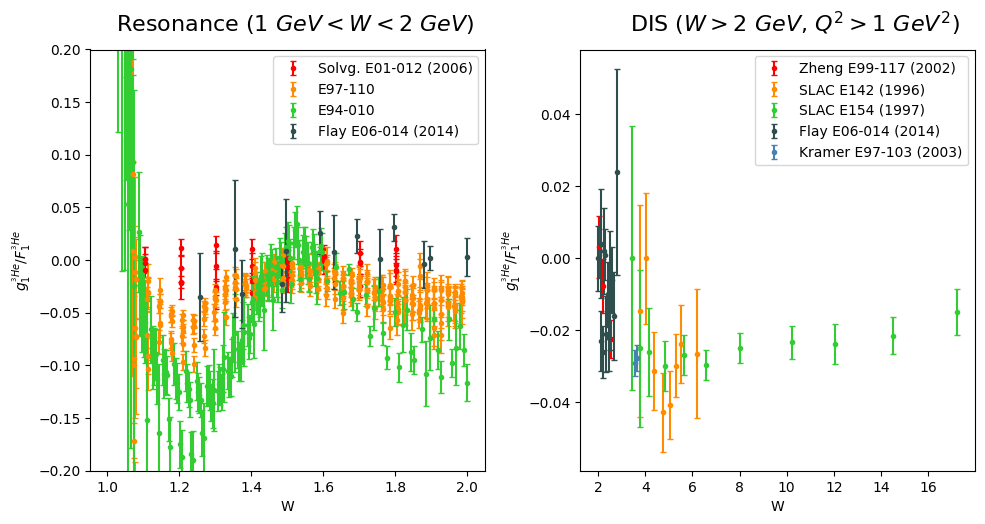

In [ ]:
# g1/F1
# fig = plot_dis_and_res(df=g1f1_df, x_key='X', x_label='X', y_key='G1F1', y_label='$g_1^{^{3}He}/F_1^{^{3}He}$', ax1_lims=[0,0], ax2_lims=[0,0])
fig = plot_dis_and_res(df=g1f1_df, x_key='W', x_label='W', y_key='G1F1', y_label='$g_1^{^{3}He}/F_1^{^{3}He}$', ax1_lims=[0,(-0.2,0.2)], ax2_lims=[0,0])
# plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1f1vw.png", bbox_inches = "tight")

# g2/F1
# fig = plot_dis_and_res(df=g2f1_df, x_key='W', x_label='W (GeV)', y_key='G2F1', y_label='$g_2^{^{3}He}/F_1^{^{3}He}$', ax1_lims=[0,0], ax2_lims=[0,(-.2,.2)])
# plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g2f1vw.png", bbox_inches = "tight")

## Plot all A1, A2 data

### Combine all A1 data from zheng_thesis, slac_e154, slac_e142, psolv_a1a2, hermes_2000, and dflay_e06014


In [ ]:
# combine A1 data into one dataframe
dfs = [zheng_df, e154_df, e142_df, psolva1a2_df, hermes_df, e06014_df]
labels = ['Zheng E99-117 (2002)', 'SLAC E154 (1997)', 'SLAC E142 (1996)', 'Solvg. E01-012 (2006)', 'HERMES (2000)', 'Flay E06-014 (2014)']

a1_dict = {'Q2': [],'W': [],'X': [],'A1': [],'A1.err': [], 'Label': []}

# try excepts for handling different column names
for i in range(len(dfs)):
  if i == 0:
    a1_dict['Q2'] = dfs[i]['Q2'].to_list()
    a1_dict['W'] = dfs[i]['W'].to_list()
    a1_dict['X'] = dfs[i]['X'].to_list()
    a1_dict['A1'] = dfs[i]['A1he3.mes'].to_list()
    a1_dict['A1.err'] = dfs[i]['A1he3.mes.err'].to_list()
    a1_dict['Label'] = [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]
  else:
    a1_dict['Q2'] = a1_dict['Q2'] + dfs[i]['Q2'].to_list()
    try:
      a1_dict['W'] = a1_dict['W'] + dfs[i]['W'].to_list()
    except Exception:
      a1_dict['W'] = a1_dict['W'] + dfs[i]['W.cal'].to_list()
    a1_dict['X'] = a1_dict['X'] + dfs[i]['X'].to_list()
    try:
      a1_dict['A1'] = a1_dict['A1'] + dfs[i]['A1he3.mes'].to_list()
    except Exception:
      a1_dict['A1'] = a1_dict['A1'] + dfs[i]['A1He3.mes'].to_list()
    try:
      a1_dict['A1.err'] = a1_dict['A1.err'] + dfs[i]['A1he3.mes.err'].to_list()
    except Exception:
      a1_dict['A1.err'] = a1_dict['A1.err'] + dfs[i]['A1He3.mes.err'].to_list()

    a1_dict['Label'] = a1_dict['Label'] + [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]

a1_df = pd.DataFrame.from_dict(a1_dict)
# a1_df.head(100)
a1_df.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/a1_comb.csv',index=False)

### Combine all A2 data from zheng_thesis, slac_e142, psolv_a1a2, dflay_e06014


In [ ]:
# combine A2 data into one dataframe
dfs = [zheng_df, e142_df, psolva1a2_df, e06014_df]
labels = ['Zheng E99-117 (2002)', 'SLAC E142 (1996)', 'Solvg. E01-012 (2006)',
          'Flay E06-014 (2014)']

a2_dict = {'Q2': [],'W': [],'X': [],'A2': [],'A2.err': [], 'Label': []}

# try excepts for handling different column names
for i in range(len(dfs)):
  if i == 0:
    a2_dict['Q2'] = dfs[i]['Q2'].to_list()
    a2_dict['W'] = dfs[i]['W'].to_list()
    a2_dict['X'] = dfs[i]['X'].to_list()
    a2_dict['A2'] = dfs[i]['A2he3.mes'].to_list()
    a2_dict['A2.err'] = dfs[i]['A2he3.mes.err'].to_list()
    a2_dict['Label'] = [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]
  else:
    a2_dict['Q2'] = a2_dict['Q2'] + dfs[i]['Q2'].to_list()
    try:
      a2_dict['W'] = a2_dict['W'] + dfs[i]['W'].to_list()
    except Exception:
      a2_dict['W'] = a2_dict['W'] + dfs[i]['W.cal'].to_list()
    a2_dict['X'] = a2_dict['X'] + dfs[i]['X'].to_list()
    try:
      a2_dict['A2'] = a2_dict['A2'] + dfs[i]['A2he3.mes'].to_list()
    except Exception:
      a2_dict['A2'] = a2_dict['A2'] + dfs[i]['A2He3.mes'].to_list()
    try:
      a2_dict['A2.err'] = a2_dict['A2.err'] + dfs[i]['A2he3.mes.err'].to_list()
    except Exception:
      a2_dict['A2.err'] = a2_dict['A2.err'] + dfs[i]['A2He3.mes.err'].to_list()

    a2_dict['Label'] = a2_dict['Label'] + [labels[i] for x in range(len(dfs[i]['Q2'].to_list()))]

a2_df = pd.DataFrame.from_dict(a2_dict)
# a2_df.head(100)
a2_df.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/a2_comb.csv',index=False)

### Plot

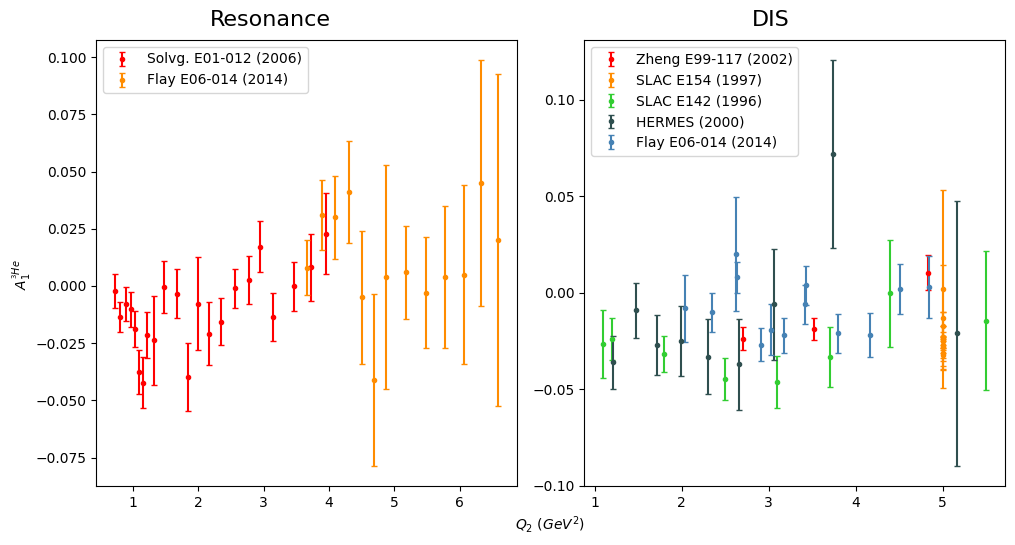

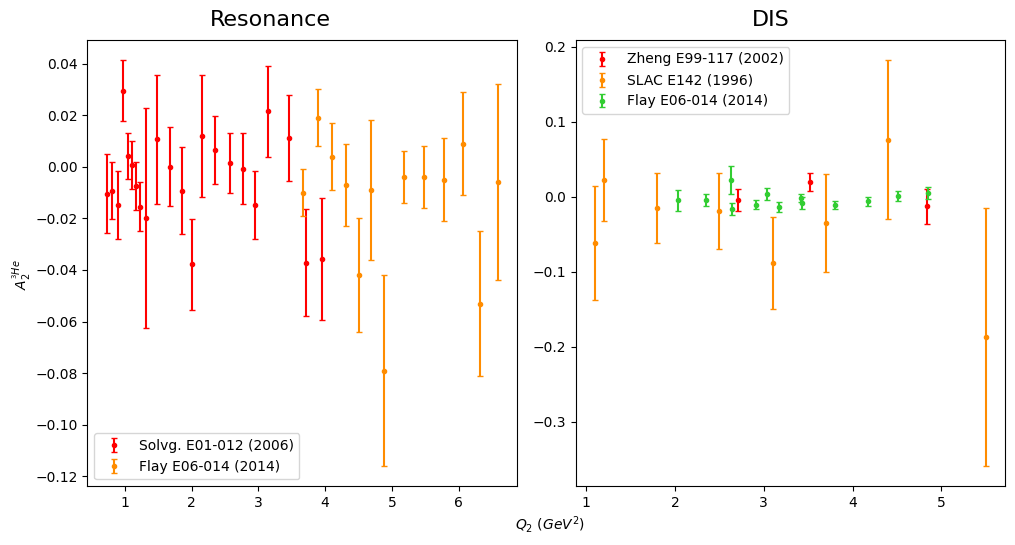

In [ ]:
# A1
fig = plot_dis_and_res(df=a1_df, x_key='Q2', x_label='$Q_2$ ($GeV^2$)', y_key='A1', y_label='$A_1^{^{3}He}$', ax1_lims=[0,0], ax2_lims=[0,0])
plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/a1vQ2.png", bbox_inches = "tight")

# A2
fig = plot_dis_and_res(df=a2_df, x_key='Q2', x_label='$Q_2$ ($GeV^2$)', y_key='A2', y_label='$A_2^{^{3}He}$', ax1_lims=[0,0], ax2_lims=[0,0])
plt.savefig("/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/a2vQ2.png", bbox_inches = "tight")

# $F_1$ Interpolation

In [ ]:
# caldata.drop(columns=['Unnamed: 0'])
# print(caldata.shape)
caldata.head(50)
# print(caldata['F1_IpQE'][caldata['Q2']==1.1][3.6<caldata['W']][caldata['W']<6.2], caldata['F1_QE'][caldata['Q2']==1.1][3.6<caldata['W']][caldata['W']<6.2])
# print(caldata['Q2'])

Q2      X  F2_Inelastic  FL_Inelastic  F1_Inelastic  G1_Inelastic  \
0   0.1  0.001      0.118436      0.021207     48.616881     -0.156546   
1   0.1  0.002      0.241712      0.042852     49.723530     -0.272142   
2   0.1  0.003      0.244626      0.043537     33.527730     -0.257698   
3   0.1  0.004      0.245905      0.048193     24.731317     -0.244399   
4   0.1  0.005      0.247777      0.053129     19.486625     -0.234140   
5   0.1  0.006      0.251462      0.054944     16.403050     -0.227682   
6   0.1  0.007      0.255512      0.055132     14.344310     -0.222675   
7   0.1  0.008      0.259223      0.055030     12.798629     -0.217926   
8   0.1  0.009      0.262554      0.054926     11.576488     -0.213283   
9   0.1  0.010      0.265567      0.054822     10.583999     -0.208751   
10  0.1  0.011      0.268309      0.054702      9.761340     -0.204340   
11  0.1  0.012      0.270841      0.054572      9.068444     -0.200057   
12  0.1  0.013      0.273196      0.054402      8.477673     -0.195902   
13  0.1  0.014      0.275412      0.054222      7.967565     -0.191867   
14  0.1  0.015      0.277535      0.054024      7.523691     -0.187953   
15  0.1  0.016      0.279592      0.053803      7.134679     -0.184160   
16  0.1  0.017      0.281626      0.053573      6.791753     -0.180470   
17  0.1  0.018      0.283670      0.053334      6.488137     -0.176890   
18  0.1  0.019      0.285755      0.053089      6.218379     -0.173412   
19  0.1  0.020      0.287926      0.052850      5.978292     -0.170039   
20  0.1  0.021      0.290186      0.052598      5.764162     -0.166770   
21  0.1  0.022      0.292594      0.052368      5.573025     -0.163614   
22  0.1  0.023      0.295136      0.052153      5.401756     -0.160618   
23  0.1  0.024      0.297836      0.051960      5.248275     -0.157872   
24  0.1  0.025      0.300662      0.051787      5.109847     -0.155464   
25  0.1  0.026      0.303599      0.051640      4.984358     -0.153580   
26  0.1  0.027      0.306605      0.051527      4.869422     -0.152612   
27  0.1  0.028      0.309607      0.051440      4.762770     -0.153170   
28  0.1  0.029      0.312567      0.051374      4.662921     -0.154872   
29  0.1  0.030      0.315385      0.051322      4.567641     -0.156599   
30  0.1  0.031      0.318052      0.051237      4.477060     -0.157259   
31  0.1  0.032      0.320510      0.051150      4.389342     -0.154718   
32  0.1  0.033      0.322793      0.051028      4.305214     -0.149096   
33  0.1  0.034      0.324925      0.050873      4.224691     -0.141688   
34  0.1  0.035      0.326966      0.050694      4.148236     -0.133208   
35  0.1  0.036      0.329064      0.050514      4.077333     -0.124626   
36  0.1  0.037      0.331288      0.050343      4.012370     -0.116280   
37  0.1  0.038      0.333886      0.050259      3.955329     -0.108664   
38  0.1  0.039      0.337007      0.050287      3.907313     -0.101693   
39  0.1  0.040      0.340824      0.050459      3.869599     -0.095577   
40  0.1  0.041      0.345583      0.050802      3.844353     -0.089802   
41  0.1  0.042      0.351357      0.051336      3.831506     -0.084471   
42  0.1  0.043      0.358214      0.051931      3.832636     -0.078729   
43  0.1  0.044      0.366134      0.052623      3.846275     -0.073094   
44  0.1  0.045      0.374665      0.053251      3.868113     -0.066775   
45  0.1  0.046      0.383336      0.053694      3.893538     -0.061282   
46  0.1  0.047      0.391344      0.053874      3.913960     -0.055973   
47  0.1  0.048      0.397699      0.053756      3.918851     -0.052351   
48  0.1  0.049      0.402169      0.053383      3.906011     -0.049967   
49  0.1  0.050      0.404360      0.052909      3.870488     -0.048878   

    G2_Inelastic     F2_QE     FL_QE     F1_QE     G1_QE     G2_QE   F2_IpQE  \
0      -0.380644  0.000000  0.000000  0.000000  0.000000  0.000000  0.118436   
1      -0.495709  0.000000  0.000000  0.000000  0.000000  0.000000  0.

In [ ]:
# calculate W for Saikat's table data
def W_cal(q2, x):
  # Mp = 2.8006735 # mass of He3 nucleus (GeV)
  Mp = 0.93870319 # average nucleon mass in 3He
  return np.sqrt(Mp*Mp + q2/x - q2)

Mp = 0.93870319 # average nucleon mass in 3He
caldata['W'] = np.nan_to_num(np.sqrt(Mp*Mp + caldata['Q2']/caldata['X'] - caldata['Q2']))
# caldata['F1_QEI_ratio'] = caldata['F1_QE']/caldata['F1_Inelastic']

# caldata.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/saikat_tables/XZ_table_3He_JAM_smeared_kpsv_onshell_ipol1_ipolres1_IA14_SF23_AC11.csv', index=False)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Kramer E97103

In [ ]:
# e97103_df = e97103_df.drop(columns=["W"])
e97103_df["W.cal"] = W_cal(e97103_df["Q2"], e97103_df["X"])
e97103_df.head(10)

# # write back to csv file
# e97103_df.to_csv(dir + 'kramer_e97103.csv', index=False)

In [ ]:
# check F1_inel >> F1_QE
W_min = e97103_df['W.cal'].min()
W_max = e97103_df['W.cal'].max()
Q2_min = e97103_df['Q2'].min()
Q2_max = e97103_df['Q2'].max()
inel_ratio = caldata['F1_QEI_ratio'][caldata['Q2']<Q2_max][caldata['Q2']>Q2_min][W_min<caldata['W']][caldata['W']<W_max]
print([r for r in inel_ratio if r>.001])

[]


In [ ]:
# interpolate F1 for the data and calculate G1/F1, G2/F1 and propagate their errors
f1t = caldata['F1_IpQE']
e97103_df['F1.cal'] = griddata((caldata['Q2'], caldata['X']), f1t, (e97103_df['Q2'], e97103_df['X']), method='linear', fill_value=0)
e97103_df['G1F1.cal'] = e97103_df['G1.mes']/e97103_df['F1.cal']
e97103_df['G1F1.cal.err'] = np.nan_to_num(np.sqrt((e97103_df['G1.mes.err']/e97103_df['F1.cal'])**2 + (0*e97103_df['G1.mes']/(e97103_df['F1.cal']**2))**2)) # propagation of error
e97103_df['G2F1.cal'] = e97103_df['G2.mes']/e97103_df['F1.cal']
e97103_df['G2F1.cal.err'] = np.nan_to_num(np.sqrt((e97103_df['G2.mes.err']/e97103_df['F1.cal'])**2 + (0*e97103_df['G2.mes']/(e97103_df['F1.cal']**2))**2)) # propagation of error
e97103_df.head(10)

Q2     X  G1.mes  G1.mes.err  G2.mes  G2.mes.err         W    F1.cal  \
0  0.57  0.16 -0.0754    0.008262  0.0650    0.013601  3.291849  2.348513   
1  0.78  0.18 -0.0684    0.010112  0.0720    0.016279  3.375960  2.175047   
2  0.94  0.19 -0.0643    0.007235  0.0706    0.011173  3.442549  2.084891   
3  1.13  0.19 -0.0612    0.007543  0.0457    0.010781  3.558250  2.108184   
4  1.34  0.20 -0.0560    0.007376  0.0422    0.010414  3.633699  2.024778   

   G1F1.cal  G1F1.cal.err  G2F1.cal  G2F1.cal.err  
0 -0.032105      0.003518  0.027677      0.005792  
1 -0.031448      0.004649  0.033103      0.007484  
2 -0.030841      0.003470  0.033863      0.005359  
3 -0.029030      0.003578  0.021677      0.005114  
4 -0.027657      0.003643  0.020842      0.005143

In [ ]:
# write back to csv file
e97103_df.to_csv(dir + 'kramer_e97103.csv', index=False)

## SLAC E142

In [ ]:
# e142_df = e142_df.drop(columns=['W.cal'])
e142_df['W.cal'] = W_cal(e142_df['Q2'], e142_df['X'])
e142_df.head(10)

Q2      X  A1he3.mes  A1he3.mes.err  A2he3.mes  A2he3.mes.err  G1.mes  \
0  1.1  0.035    -0.0264        0.01765    -0.0619       0.075710  -0.248   
1  1.2  0.050    -0.0238        0.01092     0.0222       0.054174  -0.168   
2  1.8  0.082    -0.0317        0.00942    -0.0158       0.046513  -0.146   
3  2.5  0.124    -0.0447        0.01073    -0.0193       0.050186  -0.141   
4  3.1  0.175    -0.0463        0.01358    -0.0885       0.061778  -0.105   
5  3.7  0.246    -0.0333        0.01563    -0.0349       0.065117  -0.051   
6  4.4  0.343    -0.0003        0.02793     0.0756       0.106038   0.000   
7  5.5  0.466    -0.0145        0.03608    -0.1875       0.171780  -0.007   

   G1.mes.err  G2.mes  G2.mes.err    F1.cal  G1F1.cal  G1F1.cal.err  G2F1.cal  \
0      0.1682  -9.314     10.9320  9.371025 -0.026465      0.017949 -0.993915   
1      0.0769   2.106      4.5028  7.053955 -0.023816      0.010902  0.298556   
2      0.0429  -0.648      1.8650  4.892290 -0.029843      0.008769 -0.132453   
3      0.0325  -0.256      1.0274  3.459161 -0.040761      0.009395 -0.074006   
4      0.0269  -0.764      0.7007  2.458494 -0.042709      0.010942 -0.310759   
5      0.0175  -0.088      0.3692  1.629189 -0.031304      0.010742 -0.054015   
6      0.0175   0.140      0.2587  0.964584  0.000000      0.018143  0.145140   
7      0.0141  -0.188      0.1738  0.478683 -0.014623      0.029456 -0.392745   

   G2F1.cal.err     W.cal  
0      1.166575  5.586567  
1      0.638337  4.866330  
2      0.381212  4.586108  
3      0.297008  4.306095  
4      0.285012  3.936426  
5      0.226616  3.495971  
6      0.268198  3.051090  
7      0.363080  2.680250

In [ ]:
# slac e142 - Q2 1.1->5.5 GeV2

# check F1_inel >> F1_QE
W_min = 3.75
W_max = 6.18
Q2_min = 1.0
Q2_max = 5.6
inel_ratio = caldata['F1_QEI_ratio'][caldata['Q2']<Q2_max][caldata['Q2']>Q2_min][W_min<caldata['W']][caldata['W']<W_max]
print([r for r in inel_ratio if r>.001])

# interpolate F1 for the data and calculate G1/F1, G2/F1 and propagate their errors
f1t = caldata['F1_IpQE']
# e142_df['F1.cal'] = griddata((caldata['Q2'], caldata['X']), f1t, (e142_df['Q2'], e142_df['X']), method='linear', fill_value=0)
e142_df['G1F1.cal'] = e142_df['G1.mes']/e142_df['F1.cal']
e142_df['G1F1.cal.err'] = np.nan_to_num(np.sqrt((e142_df['G1.mes.err']/e142_df['F1.cal'])**2 + (0*e142_df['G1.mes']/(e142_df['F1.cal']**2))**2)) # propagation of error
e142_df['G2F1.cal'] = e142_df['G2.mes']/e142_df['F1.cal']
e142_df['G2F1.cal.err'] = np.nan_to_num(np.sqrt((e142_df['G2.mes.err']/e142_df['F1.cal'])**2 + (0*e142_df['G2.mes']/(e142_df['F1.cal']**2))**2)) # propagation of error
e142_df.head(10)

[]


Q2    W.cal      X  A1he3.mes  A1he3.mes.err  A2he3.mes  A2he3.mes.err  \
0  1.1  6.17838  0.035    -0.0264        0.01765    -0.0619       0.075710   
1  1.2  5.53568  0.050    -0.0238        0.01092     0.0222       0.054174   
2  1.8  5.29103  0.082    -0.0317        0.00942    -0.0158       0.046513   
3  2.5  5.05025  0.124    -0.0447        0.01073    -0.0193       0.050186   
4  3.1  4.73899  0.175    -0.0463        0.01358    -0.0885       0.061778   
5  3.7  4.38000  0.246    -0.0333        0.01563    -0.0349       0.065117   
6  4.4  4.03383  0.343    -0.0003        0.02793     0.0756       0.106038   
7  5.5  3.76116  0.466    -0.0145        0.03608    -0.1875       0.171780   

   G1.mes  G1.mes.err  G2.mes  G2.mes.err    F1.cal  G1F1.cal  G1F1.cal.err  \
0  -0.248      0.1682  -9.314     10.9320  9.371025 -0.026465      0.017949   
1  -0.168      0.0769   2.106      4.5028  7.053955 -0.023816      0.010902   
2  -0.146      0.0429  -0.648      1.8650  4.892290 -0.029843      0.008769   
3  -0.141      0.0325  -0.256      1.0274  3.459161 -0.040761      0.009395   
4  -0.105      0.0269  -0.764      0.7007  2.458494 -0.042709      0.010942   
5  -0.051      0.0175  -0.088      0.3692  1.629189 -0.031304      0.010742   
6   0.000      0.0175   0.140      0.2587  0.964584  0.000000      0.018143   
7  -0.007      0.0141  -0.188      0.1738  0.478683 -0.014623      0.029456   

   G2F1.cal  G2F1.cal.err  
0 -0.993915      1.166575  
1  0.298556      0.638337  
2 -0.132453      0.381212  
3 -0.074006      0.297008  
4 -0.310759      0.285012  
5 -0.054015      0.226616  
6  0.145140      0.268198  
7 -0.392745      0.363080

In [ ]:
# write back to csv file
e142_df.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/slac_e142.csv', index=False)

## SLAC E154

In [ ]:
# e154_df = e154_df.drop(columns=["W.cal"])
e154_df["W.cal"] = W_cal(e154_df['Q2'], e154_df['X'])
e154_df.head(10)

Q2      X  A1he3.mes  A1he3.mes.err  G1.mes  G1.mes.err     F1.cal  \
0  5.0  0.017     -0.017         0.0071  -0.447      0.1890  29.899399   
1  5.0  0.024     -0.023         0.0057  -0.434      0.1029  20.234946   
2  5.0  0.035     -0.023         0.0058  -0.317      0.0731  13.341005   
3  5.0  0.049     -0.025         0.0045  -0.217      0.0434   9.300374   
4  5.0  0.081     -0.027         0.0042  -0.138      0.0230   5.516191   
5  5.0  0.123     -0.031         0.0042  -0.106      0.0150   3.577570   
6  5.0  0.173     -0.028         0.0058  -0.066      0.0139   2.456273   
7  5.0  0.242     -0.032         0.0072  -0.049      0.0112   1.638860   
8  5.0  0.342     -0.024         0.0139  -0.025      0.0117   0.959049   
9  5.0  0.441     -0.013         0.0272  -0.014      0.0122   0.560175   

   G1F1.cal  G1F1.cal.err      W.cal  
0 -0.014950      0.006321  17.029351  
1 -0.021448      0.005085  14.290364  
2 -0.023761      0.005479  11.778723  
3 -0.023332      0.004666   9.895554  
4 -0.025017      0.004170   7.590096  
5 -0.029629      0.004193   6.044135  
6 -0.026870      0.005659   4.978242  
7 -0.029899      0.006834   4.067225  
8 -0.026067      0.012200   3.240532  
9 -0.024992      0.021779   2.686826

In [ ]:
# slac e154 - Q2 5 GeV2

# check F1_inel >> F1_QE
W_min = 3.3
W_max = 17.3
Q2_min = 4.9
Q2_max = 5.1
inel_ratio = caldata['F1_QEI_ratio'][caldata['Q2']<Q2_max][caldata['Q2']>Q2_min][W_min<caldata['W']][caldata['W']<W_max]
print([r for r in inel_ratio if r>.001])

# interpolate F1 and calculate G1F1 and its error
f1t = caldata['F1_IpQE']
e154_df['F1.cal'] = griddata((caldata['Q2'], caldata['X']), f1t, (e154_df['Q2'], e154_df['X']), method='linear', fill_value=0)
e154_df['G1F1.cal'] = e154_df['G1.mes']/e154_df['F1.cal']
e154_df['G1F1.cal.err'] = np.nan_to_num(np.sqrt((e154_df['G1.mes.err']/e154_df['F1.cal'])**2 + (0*e154_df['G1.mes']/(e154_df['F1.cal']**2))**2)) # propagation of error
e154_df.head(20)

[]


Q2     W.cal      X  A1he3.mes  A1he3.mes.err  G1.mes  G1.mes.err  \
0   5.0  17.23257  0.017     -0.017         0.0071  -0.447      0.1890   
1   5.0  14.53193  0.024     -0.023         0.0057  -0.434      0.1029   
2   5.0  12.07066  0.035     -0.023         0.0058  -0.317      0.0731   
3   5.0  10.24132  0.049     -0.025         0.0045  -0.217      0.0434   
4   5.0   8.03568  0.081     -0.027         0.0042  -0.138      0.0230   
5   5.0   6.59501  0.123     -0.031         0.0042  -0.106      0.0150   
6   5.0   5.63432  0.173     -0.028         0.0058  -0.066      0.0139   
7   5.0   4.84819  0.242     -0.032         0.0072  -0.049      0.0112   
8   5.0   4.17895  0.342     -0.024         0.0139  -0.025      0.0117   
9   5.0   3.76585  0.441     -0.013         0.0272  -0.014      0.0122   
10  5.0   3.42184  0.564      0.002         0.0514   0.000      0.0100   

       F1.cal  G1F1.cal  G1F1.cal.err  
0   29.899399 -0.014950      0.006321  
1   20.234946 -0.021448      0.005085  
2   13.341005 -0.023761      0.005479  
3    9.300374 -0.023332      0.004666  
4    5.516191 -0.025017      0.004170  
5    3.577570 -0.029629      0.004193  
6    2.456273 -0.026870      0.005659  
7    1.638860 -0.029899      0.006834  
8    0.959049 -0.026067      0.012200  
9    0.560175 -0.024992      0.021779  
10   0.273149  0.000000      0.000000

In [ ]:
e154_df['G1F1.cal.err'] = np.nan_to_num(np.sqrt((e154_df['G1.mes.err']/e154_df['F1.cal'])**2 + (0*e154_df['G1.mes']/(e154_df['F1.cal']**2))**2)) # propagation of error
e154_df.head(20)

Q2     W.cal      X  A1he3.mes  A1he3.mes.err  G1.mes  G1.mes.err  \
0   5.0  17.23257  0.017     -0.017         0.0071  -0.447      0.1890   
1   5.0  14.53193  0.024     -0.023         0.0057  -0.434      0.1029   
2   5.0  12.07066  0.035     -0.023         0.0058  -0.317      0.0731   
3   5.0  10.24132  0.049     -0.025         0.0045  -0.217      0.0434   
4   5.0   8.03568  0.081     -0.027         0.0042  -0.138      0.0230   
5   5.0   6.59501  0.123     -0.031         0.0042  -0.106      0.0150   
6   5.0   5.63432  0.173     -0.028         0.0058  -0.066      0.0139   
7   5.0   4.84819  0.242     -0.032         0.0072  -0.049      0.0112   
8   5.0   4.17895  0.342     -0.024         0.0139  -0.025      0.0117   
9   5.0   3.76585  0.441     -0.013         0.0272  -0.014      0.0122   
10  5.0   3.42184  0.564      0.002         0.0514   0.000      0.0100   

       F1.cal  G1F1.cal  G1F1.cal.err  
0   29.899399 -0.014950      0.006321  
1   20.234946 -0.021448      0.005085  
2   13.341005 -0.023761      0.005479  
3    9.300374 -0.023332      0.004666  
4    5.516191 -0.025017      0.004170  
5    3.577570 -0.029629      0.004193  
6    2.456273 -0.026870      0.005659  
7    1.638860 -0.029899      0.006834  
8    0.959049 -0.026067      0.012200  
9    0.560175 -0.024992      0.021779  
10   0.273149  0.000000      0.036610

In [ ]:
# write back to csv file
e154_df.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/slac_e154.csv', index=False)

## Solvignon E01-012 G1 G2

In [ ]:
psolvg1g2_df = psolvg1g2_df.drop(columns=['Unnamed: 7', 'Unnamed: 8'])
psolvg1g2_df.head(10)

Q2      W       X   G1.mes  G1.mes.err   G2.mes  G2.mes.err    F1.cal  \
0  1.2  1.103  0.7820 -0.00257    0.001908 -0.00128    0.001210  0.271786   
1  1.2  1.203  0.6799 -0.00941    0.002546  0.00378    0.001963  0.458383   
2  1.2  1.303  0.5954 -0.01340    0.003773  0.01103    0.003924  0.523350   
3  1.2  1.403  0.5249 -0.01138    0.004378  0.00947    0.005548  0.562264   
4  1.2  1.503  0.4657 -0.00468    0.005784  0.01144    0.009707  0.728429   
5  1.2  1.603  0.4156  0.00072    0.007711  0.01463    0.017559  0.870077   
6  1.2  1.703  0.3729 -0.00318    0.010065  0.00410    0.027081  1.040092   
7  1.2  1.803  0.3363 -0.00496    0.012573 -0.03792    0.038025  1.138003   
8  1.9  1.103  0.8500  0.00012    0.001991 -0.00397    0.002166  0.165919   
9  1.9  1.203  0.7706 -0.00437    0.002930  0.00081    0.002949  0.199184   

   G1F1.cal  G1F1.cal.err  G2F1.cal  G2F1.cal.err  
0 -0.009456      0.007019 -0.004710      0.004452  
1 -0.020529      0.005554  0.008246      0.004282  
2 -0.025604      0.007210  0.021076      0.007498  
3 -0.020240      0.007787  0.016843      0.009868  
4 -0.006425      0.007941  0.015705      0.013327  
5  0.000828      0.008862  0.016815      0.020181  
6 -0.003057      0.009677  0.003942      0.026037  
7 -0.004359      0.011049 -0.033322      0.033414  
8  0.000723      0.012000 -0.023927      0.013056  
9 -0.021940      0.014708  0.004067      0.014805

In [ ]:
# psolvg1g2 - 1.2<Q2<3.3 GeV2

# check F1_inel >> F1_QE
W_min = 1.0
W_max = 1.9
Q2_min = 1.1
Q2_max = 3.4
inel_ratio = caldata['F1_QEI_ratio'][caldata['Q2']<Q2_max][caldata['Q2']>Q2_min][W_min<caldata['W']][caldata['W']<W_max]
print([r for r in inel_ratio if r>.001])

[]


In [ ]:
# interpolate F1 and calculate G1F1 and its error
f1t = caldata['F1_IpQE']
psolvg1g2_df['F1.cal'] = griddata((caldata['Q2'], caldata['X']), f1t, (psolvg1g2_df['Q2'], psolvg1g2_df['X']), method='linear', fill_value=0)
psolvg1g2_df['G1F1.cal'] = psolvg1g2_df['G1.mes']/psolvg1g2_df['F1.cal']
psolvg1g2_df['G1F1.cal.err'] = np.nan_to_num(np.sqrt((psolvg1g2_df['G1.mes.err']/psolvg1g2_df['F1.cal'])**2 + (0*psolvg1g2_df['G1.mes']/(psolvg1g2_df['F1.cal']**2))**2)) # propagation of error
psolvg1g2_df['G2F1.cal'] = psolvg1g2_df['G2.mes']/psolvg1g2_df['F1.cal']
psolvg1g2_df['G2F1.cal.err'] = np.nan_to_num(np.sqrt((psolvg1g2_df['G2.mes.err']/psolvg1g2_df['F1.cal'])**2 + (0*psolvg1g2_df['G2.mes']/(psolvg1g2_df['F1.cal']**2))**2)) # propagation of error
psolvg1g2_df.head(10)

Q2      W       X   G1.mes  G1.mes.err   G2.mes  G2.mes.err    F1.cal  \
0  1.2  1.103  0.7820 -0.00257    0.001908 -0.00128    0.001210  0.271786   
1  1.2  1.203  0.6799 -0.00941    0.002546  0.00378    0.001963  0.458383   
2  1.2  1.303  0.5954 -0.01340    0.003773  0.01103    0.003924  0.523350   
3  1.2  1.403  0.5249 -0.01138    0.004378  0.00947    0.005548  0.562264   
4  1.2  1.503  0.4657 -0.00468    0.005784  0.01144    0.009707  0.728429   
5  1.2  1.603  0.4156  0.00072    0.007711  0.01463    0.017559  0.870077   
6  1.2  1.703  0.3729 -0.00318    0.010065  0.00410    0.027081  1.040092   
7  1.2  1.803  0.3363 -0.00496    0.012573 -0.03792    0.038025  1.138003   
8  1.9  1.103  0.8500  0.00012    0.001991 -0.00397    0.002166  0.165919   
9  1.9  1.203  0.7706 -0.00437    0.002930  0.00081    0.002949  0.199184   

   G1F1.cal  G1F1.cal.err  G2F1.cal  G2F1.cal.err  
0 -0.009456      0.007019 -0.004710      0.004452  
1 -0.020529      0.005554  0.008246      0.004282  
2 -0.025604      0.007210  0.021076      0.007498  
3 -0.020240      0.007787  0.016843      0.009868  
4 -0.006425      0.007941  0.015705      0.013327  
5  0.000828      0.008862  0.016815      0.020181  
6 -0.003057      0.009677  0.003942      0.026037  
7 -0.004359      0.011049 -0.033322      0.033414  
8  0.000723      0.012000 -0.023927      0.013056  
9 -0.021940      0.014708  0.004067      0.014805

In [ ]:
# write back to csv file
psolvg1g2_df.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/psolv_e01012_g1g2.csv', index=False)

## E97110

In [ ]:
e97110_df.head(10)

Q2   Nu       W         X      Eb     Ep  Theta    G1.mes  G1.mes.err  \
0  0.035  165  1.0747  0.113038  1147.0  982.0   15.5 -0.047170    0.012988   
1  0.035  170  1.0791  0.109714  1147.0  977.0   15.5 -0.050328    0.013073   
2  0.035  210  1.1133  0.088816  1147.0  937.0   15.5 -0.061664    0.012035   
3  0.035  250  1.1465  0.074605  1147.0  897.0   15.5 -0.081924    0.024735   
4  0.035  290  1.1788  0.064315  1147.0  857.0   15.5 -0.236353    0.021438   
5  0.035  330  1.2102  0.056519  1147.0  817.0   15.5 -0.369310    0.028735   
6  0.035  370  1.2408  0.050409  1147.0  777.0   15.5 -0.368647    0.029251   
7  0.035  410  1.2707  0.045491  1147.0  737.0   15.5 -0.266344    0.023817   
8  0.035  450  1.2999  0.041447  1147.0  697.0   15.5 -0.171476    0.018897   
9  0.035  490  1.3285  0.038064  1147.0  657.0   15.5 -0.129725    0.018313   

     G2.mes  ...  F1.mes  F2.mes    G1.cal    G1.dff    G2.cal    G2.dff  \
0  0.010942  ...     0.0     0.0  0.029493 -0.076663 -0.014153  0.025095   
1  0.012311  ...     0.0     0.0  0.045132 -0.095460 -0.023036  0.035347   
2  0.043360  ...     0.0     0.0  0.073608 -0.135272 -0.010475  0.053835   
3  0.095928  ...     0.0     0.0  0.012807 -0.094731  0.054441  0.041487   
4  0.220603  ...     0.0     0.0 -0.161540 -0.074813  0.214982  0.005621   
5  0.311029  ...     0.0     0.0 -0.313134 -0.056176  0.351713 -0.040684   
6  0.389019  ...     0.0     0.0 -0.280713 -0.087934  0.330595  0.058424   
7  0.324978  ...     0.0     0.0 -0.172691 -0.093653  0.246896  0.078082   
8  0.194734  ...     0.0     0.0 -0.091902 -0.079574  0.188017  0.006717   
9  0.099929  ...     0.0     0.0 -0.046088 -0.083637  0.165566 -0.065637   

     F1.cal  F1.dff    F2.cal  F2.dff  
0  0.145344     0.0  0.016137     0.0  
1  0.177784     0.0  0.017796     0.0  
2  0.596722     0.0  0.060927     0.0  
3  1.375033     0.0  0.134722     0.0  
4  2.683702     0.0  0.243733     0.0  
5  3.820501     0.0  0.336762     0.0  
6  3.742863     0.0  0.297899     0.0  
7  3.191827     0.0  0.246027     0.0  
8  2.660218     0.0  0.179624     0.0  
9  2.420874     0.0  0.170613     0.0  

[10 rows x 21 columns]

In [ ]:
# e97110_df['W'] = e97110_df['W']/1000
e97110_df['G1F1.cal'] = e97110_df['G1.mes']/e97110_df['F1.cal']
e97110_df['G1F1.cal.err'] = np.nan_to_num(np.sqrt((e97110_df['G1.mes.err']/e97110_df['F1.cal'])**2 + (0*e97110_df['G1.mes']/(e97110_df['F1.cal']**2))**2)) # propagation of error
e97110_df['G2F1.cal'] = e97110_df['G2.mes']/e97110_df['F1.cal']
e97110_df['G2F1.cal.err'] = np.nan_to_num(np.sqrt((e97110_df['G2.mes.err']/e97110_df['F1.cal'])**2 + (0*e97110_df['G2.mes']/(e97110_df['F1.cal']**2))**2)) # propagation of error
e97110_df.head(10)

Q2   Nu       W         X      Eb     Ep  Theta    G1.mes  G1.mes.err  \
0  0.035  165  1.0747  0.113038  1147.0  982.0   15.5 -0.047170    0.012988   
1  0.035  170  1.0791  0.109714  1147.0  977.0   15.5 -0.050328    0.013073   
2  0.035  210  1.1133  0.088816  1147.0  937.0   15.5 -0.061664    0.012035   
3  0.035  250  1.1465  0.074605  1147.0  897.0   15.5 -0.081924    0.024735   
4  0.035  290  1.1788  0.064315  1147.0  857.0   15.5 -0.236353    0.021438   
5  0.035  330  1.2102  0.056519  1147.0  817.0   15.5 -0.369310    0.028735   
6  0.035  370  1.2408  0.050409  1147.0  777.0   15.5 -0.368647    0.029251   
7  0.035  410  1.2707  0.045491  1147.0  737.0   15.5 -0.266344    0.023817   
8  0.035  450  1.2999  0.041447  1147.0  697.0   15.5 -0.171476    0.018897   
9  0.035  490  1.3285  0.038064  1147.0  657.0   15.5 -0.129725    0.018313   

     G2.mes  ...    G2.cal    G2.dff    F1.cal  F1.dff    F2.cal  F2.dff  \
0  0.010942  ... -0.014153  0.025095  0.145344     0.0  0.016137     0.0   
1  0.012311  ... -0.023036  0.035347  0.177784     0.0  0.017796     0.0   
2  0.043360  ... -0.010475  0.053835  0.596722     0.0  0.060927     0.0   
3  0.095928  ...  0.054441  0.041487  1.375033     0.0  0.134722     0.0   
4  0.220603  ...  0.214982  0.005621  2.683702     0.0  0.243733     0.0   
5  0.311029  ...  0.351713 -0.040684  3.820501     0.0  0.336762     0.0   
6  0.389019  ...  0.330595  0.058424  3.742863     0.0  0.297899     0.0   
7  0.324978  ...  0.246896  0.078082  3.191827     0.0  0.246027     0.0   
8  0.194734  ...  0.188017  0.006717  2.660218     0.0  0.179624     0.0   
9  0.099929  ...  0.165566 -0.065637  2.420874     0.0  0.170613     0.0   

   G1F1.cal  G1F1.cal.err  G2F1.cal  G2F1.cal.err  
0 -0.324539      0.089360  0.075283      0.074464  
1 -0.283086      0.073533  0.069247      0.063077  
2 -0.103338      0.020169  0.072664      0.026579  
3 -0.059580      0.017989  0.069764      0.015283  
4 -0.088070      0.007988  0.082201      0.012336  
5 -0.096665      0.007521  0.081411      0.010680  
6 -0.098493      0.007815  0.103936      0.013618  
7 -0.083446      0.007462  0.101816      0.016696  
8 -0.064459      0.007104  0.073202      0.020677  
9 -0.053586      0.007565  0.041278      0.026357  

[10 rows x 25 columns]

In [ ]:
# write back to csv file
e97110_df.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/e97110.csv', index=False)

## E94010

In [ ]:
e94010_df.head(10)

Q2   Nu       W         X     Eb     Ep  Theta   G1.mes  G1.mes.err  \
0  0.1   30  0.9147  1.776314  862.0  832.0   15.5 -0.09585      0.0345   
1  0.1   40  0.9249  1.332236  862.0  822.0   15.5 -0.15450      0.0367   
2  0.1   50  0.9350  1.065789  862.0  812.0   15.5 -0.14070      0.0382   
3  0.1   60  0.9450  0.888157  862.0  802.0   15.5 -0.07450      0.0453   
4  0.1   70  0.9548  0.761278  862.0  792.0   15.5  0.10740      0.0550   
5  0.1   80  0.9646  0.666118  862.0  782.0   15.5  0.17820      0.0600   
6  0.1   90  0.9743  0.592105  862.0  772.0   15.5  0.18360      0.0588   
7  0.1  100  0.9839  0.532894  862.0  762.0   15.5  0.20790      0.0520   
8  0.1  110  0.9934  0.484449  862.0  752.0   15.5  0.17880      0.0444   
9  0.1  120  1.0028  0.444079  862.0  742.0   15.5  0.14300      0.0434   

     G2.mes  ...        G2.cal    G2.dff        F1.cal  F1.dff        F2.cal  \
0  0.000529  ...  3.161410e-50  0.000529 -1.912413e-32     0.0 -2.153913e-33   
1 -0.008174  ...  3.386719e-20 -0.008174 -5.757799e-17     0.0 -7.625904e-18   
2 -0.032610  ...  5.028400e-16 -0.032610  1.478000e-13     0.0  1.286316e-13   
3 -0.072780  ... -1.170150e-06 -0.072779 -1.322789e-05     0.0  6.473627e-06   
4 -0.084730  ... -7.524461e-06 -0.084722 -1.637198e-05     0.0  2.267421e-05   
5 -0.079490  ... -2.660132e-05 -0.079463  2.979917e-04     0.0  8.180648e-05   
6 -0.078260  ... -1.615574e-05 -0.078244  8.520449e-04     0.0  1.952986e-04   
7 -0.058890  ...  6.327383e-05 -0.058953  1.828632e-03     0.0  3.604509e-04   
8 -0.044460  ...  2.038708e-04 -0.044664  3.159193e-03     0.0  6.677974e-04   
9 -0.018940  ...  3.586631e-04 -0.019299  4.993872e-03     0.0  9.513443e-04   

   F2.dff      G1F1.cal  G1F1.cal.err      G2F1.cal  G2F1.cal.err  
0     0.0  5.011992e+30  1.804003e+30 -2.764047e+28  1.380455e+29  
1     0.0  2.683317e+15  6.373963e+14  1.419640e+14  8.840184e+13  
2     0.0 -9.519620e+11  2.584574e+11 -2.206360e+11  6.441136e+10  
3     0.0  5.632041e+03  3.424583e+03  5.502013e+03  1.171767e+03  
4     0.0 -6.559988e+03  3.359398e+03  5.175305e+03  1.129979e+03  
5     0.0  5.980032e+02  2.013479e+02 -2.667524e+02  6.946502e+01  
6     0.0  2.154816e+02  6.901045e+01 -9.184962e+01  2.652442e+01  
7     0.0  1.136916e+02  2.843656e+01 -3.220441e+01  1.214023e+01  
8     0.0  5.659673e+01  1.405422e+01 -1.407321e+01  6.457346e+00  
9     0.0  2.863509e+01  8.690651e+00 -3.792648e+00  4.185129e+00  

[10 rows x 25 columns]

In [ ]:
# e94010_df['W'] = e94010_df['W']/1000

# convert g1, g2 to per nucleon
e94010_df['G1.mes'] = e94010_df['G1.mes']/3 # factor of 3 to be per nucleon
e94010_df['G2.mes'] = e94010_df['G2.mes']/3 # factor of 3 to be per nucleon
e94010_df['G1.mes.err'] = e94010_df['G1.mes.err']/3
e94010_df['G2.mes.err'] = e94010_df['G2.mes.err']/3

e94010_df['G1F1.cal'] = e94010_df['G1.mes']/e94010_df['F1.cal']
e94010_df['G1F1.cal.err'] = np.nan_to_num(np.sqrt((e94010_df['G1.mes.err']/e94010_df['F1.cal'])**2 + (0*e94010_df['G1.mes']/(e94010_df['F1.cal']**2))**2)) # propagation of error
e94010_df['G2F1.cal'] = e94010_df['G2.mes']/e94010_df['F1.cal']
e94010_df['G2F1.cal.err'] = np.nan_to_num(np.sqrt((e94010_df['G2.mes.err']/e94010_df['F1.cal'])**2 + (0*e94010_df['G2.mes']/(e94010_df['F1.cal']**2))**2)) # propagation of error
e94010_df.head(10)

Q2   Nu       W         X     Eb     Ep  Theta    G1.mes  G1.mes.err  \
0  0.1   30  0.9147  1.776314  862.0  832.0   15.5 -0.031950    0.011500   
1  0.1   40  0.9249  1.332236  862.0  822.0   15.5 -0.051500    0.012233   
2  0.1   50  0.9350  1.065789  862.0  812.0   15.5 -0.046900    0.012733   
3  0.1   60  0.9450  0.888157  862.0  802.0   15.5 -0.024833    0.015100   
4  0.1   70  0.9548  0.761278  862.0  792.0   15.5  0.035800    0.018333   
5  0.1   80  0.9646  0.666118  862.0  782.0   15.5  0.059400    0.020000   
6  0.1   90  0.9743  0.592105  862.0  772.0   15.5  0.061200    0.019600   
7  0.1  100  0.9839  0.532894  862.0  762.0   15.5  0.069300    0.017333   
8  0.1  110  0.9934  0.484449  862.0  752.0   15.5  0.059600    0.014800   
9  0.1  120  1.0028  0.444079  862.0  742.0   15.5  0.047667    0.014467   

     G2.mes  ...        G2.cal    G2.dff        F1.cal  F1.dff        F2.cal  \
0  0.000176  ...  3.161410e-50  0.000529 -1.912413e-32     0.0 -2.153913e-33   
1 -0.002725  ...  3.386719e-20 -0.008174 -5.757799e-17     0.0 -7.625904e-18   
2 -0.010870  ...  5.028400e-16 -0.032610  1.478000e-13     0.0  1.286316e-13   
3 -0.024260  ... -1.170150e-06 -0.072779 -1.322789e-05     0.0  6.473627e-06   
4 -0.028243  ... -7.524461e-06 -0.084722 -1.637198e-05     0.0  2.267421e-05   
5 -0.026497  ... -2.660132e-05 -0.079463  2.979917e-04     0.0  8.180648e-05   
6 -0.026087  ... -1.615574e-05 -0.078244  8.520449e-04     0.0  1.952986e-04   
7 -0.019630  ...  6.327383e-05 -0.058953  1.828632e-03     0.0  3.604509e-04   
8 -0.014820  ...  2.038708e-04 -0.044664  3.159193e-03     0.0  6.677974e-04   
9 -0.006313  ...  3.586631e-04 -0.019299  4.993872e-03     0.0  9.513443e-04   

   F2.dff      G1F1.cal  G1F1.cal.err      G2F1.cal  G2F1.cal.err  
0     0.0  1.670664e+30  6.013345e+29 -9.213490e+27  4.601516e+28  
1     0.0  8.944390e+14  2.124654e+14  4.732132e+13  2.946728e+13  
2     0.0 -3.173207e+11  8.615245e+10 -7.354533e+10  2.147045e+10  
3     0.0  1.877347e+03  1.141528e+03  1.834004e+03  3.905890e+02  
4     0.0 -2.186663e+03  1.119799e+03  1.725102e+03  3.766598e+02  
5     0.0  1.993344e+02  6.711596e+01 -8.891746e+01  2.315501e+01  
6     0.0  7.182720e+01  2.300348e+01 -3.061654e+01  8.841475e+00  
7     0.0  3.789719e+01  9.478854e+00 -1.073480e+01  4.046742e+00  
8     0.0  1.886558e+01  4.684741e+00 -4.691072e+00  2.152449e+00  
9     0.0  9.545031e+00  2.896884e+00 -1.264216e+00  1.395043e+00  

[10 rows x 25 columns]

In [ ]:
# write back to csv file
e94010_df.to_csv('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/data/e94010.csv', index=False)

# $A_1$ Plotting
Files with A1 data: e06014.csv, e01012.csv

## E06-014 and E01-012 - plot different beam energies

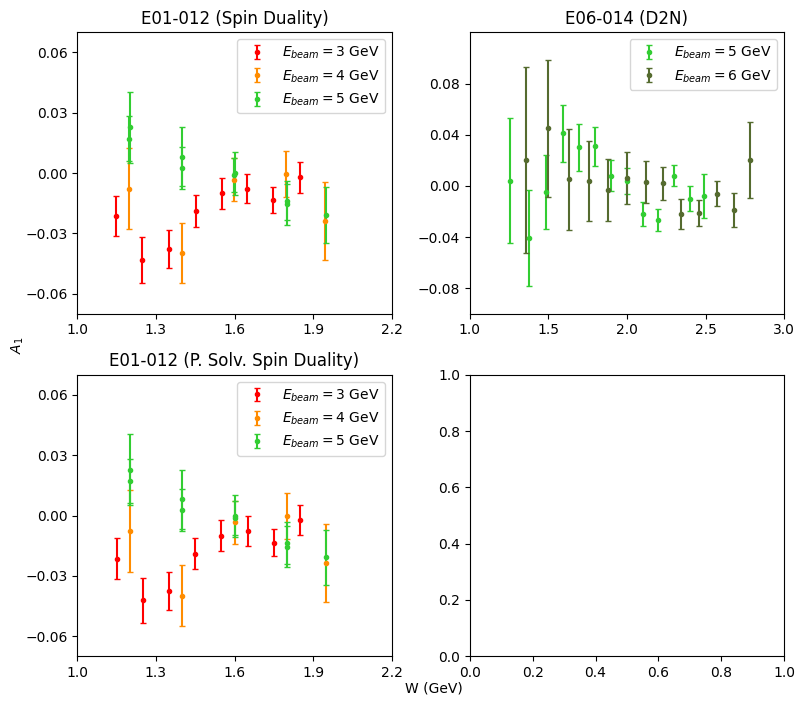

In [ ]:
# make subplot
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8,7))

## formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
# colors = colormaps['Set1'](np.linspace(0, 1, 10))
colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")
## plot data

# e01012 - E beam = 3028 MeV, 4018 MeV, 5009 MeV
beam_energies = e01012_df['Eb'].unique()
for i,Eb in enumerate(beam_energies):
  ax1.errorbar(e01012_df['W'][e01012_df['Eb']==Eb]/1000,
             e01012_df['A1he3.mes'][e01012_df['Eb']==Eb],
             yerr=e01012_df['A1he3.mes.err'][e01012_df['Eb']==Eb],
             fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{round(Eb/1000)} GeV")
ax1.set_title("E01-012 (Spin Duality)")
ax1.legend()

# e06014 - E beam = 4760 MeV, 5890 MeV
beam_energies = e06014_df['Eb'].unique()

for i,Eb in enumerate(beam_energies):
  ax2.errorbar(e06014_df['W'][e06014_df['Eb']==Eb]/1000,
             e06014_df['A1he3.mes'][e06014_df['Eb']==Eb],
             yerr=e06014_df['A1he3.mes.err'][e06014_df['Eb']==Eb],
             fmt=m_type, color=colors[i+2], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{round(Eb/1000)} GeV")
ax2.set_title("E06-014 (D2N)")
ax2.legend()

# psolv e01012 - E beam = 3028 MeV, 4018 MeV, 5009 MeV
beam_energies = psolv_df['Eb'].unique()

for i,Eb in enumerate(beam_energies):
  ax3.errorbar(psolv_df['W'][psolv_df['Eb']==Eb],
             psolv_df['A1he3.mes'][psolv_df['Eb']==Eb],
             yerr=psolv_df['A1he3.mes.err'][psolv_df['Eb']==Eb],
             fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{round(Eb/1000)} GeV")
ax3.set_title("E01-012 (P. Solv. Spin Duality)")
ax3.legend()


## set axes limits
ax1.set_xlim(1, 2.1)
ax1.set_ylim(-0.07, 0.07)

ax2.set_xlim(1.0, 3.0)
ax2.set_ylim(-0.1, 0.12)

ax3.set_xlim(1, 2.1)
ax3.set_ylim(-0.07, 0.07)

## set axes labels
f.text(0.53, 0.01, 'W (GeV)', ha='center', va='center')
f.text(0.01, 0.5, '$A_1$', ha='center', va='center', rotation='vertical')

## set ticks of x and y axes
ax1.set_xticks(np.linspace(1.0,2.2,5));
ax1.set_yticks(np.linspace(-0.06,0.06,5));

ax2.set_xticks(np.linspace(1.0,3.0,5));
ax2.set_yticks(np.linspace(-0.08,0.08,5));

ax3.set_xticks(np.linspace(1.0,2.2,5));
ax3.set_yticks(np.linspace(-0.06,0.06,5));

# better subplot spacing
f.tight_layout()

## remove space between subplots
# f.subplots_adjust(wspace=0, hspace=0)

## save plot
# plt.savefig('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/A1vW.png')

## E01-012 - plot different Q2

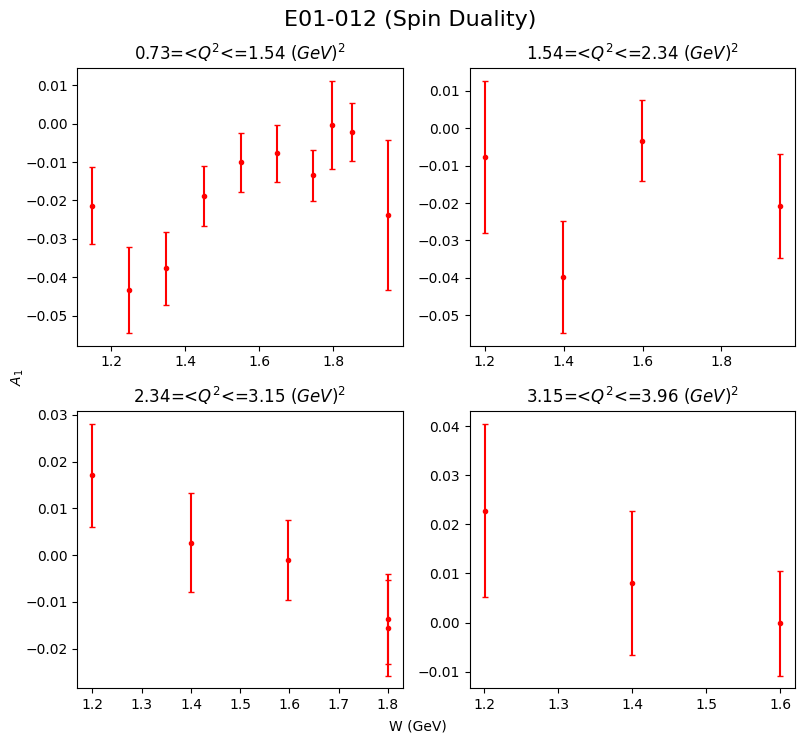

In [ ]:
## formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
x_min = 1.0
x_max = 3.0
y_min = -0.8
y_max = 0.8

# colors = colormaps['Set1'](np.linspace(0, 1, 10))
colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

# N Q2 buckets
N=4

## make subplot
fig = plt.figure(figsize=(8,(math.ceil(N/2)/2)*7))

# e01012 - E beam = 3028 MeV, 4018 MeV, 5009 MeV

# plot different Q^2 ranges (N buckets)
Q2_ranges = np.linspace(e01012_df['Q2'].min(), e01012_df['Q2'].max(), N+1)
for i,Q2 in enumerate(Q2_ranges):
  if i<(Q2_ranges.size-1):
    # add a subplot
    ax = fig.add_subplot(math.ceil(N/2),2,i+1)

    W = e01012_df['W'][e01012_df['Q2']>=Q2_ranges[i]][e01012_df['Q2']<=Q2_ranges[i+1]]/1000
    a1 = e01012_df['A1he3.mes'][e01012_df['Q2']>=Q2_ranges[i]][e01012_df['Q2']<=Q2_ranges[i+1]]
    err = e01012_df['A1he3.mes.err'][e01012_df['Q2']>=Q2_ranges[i]][e01012_df['Q2']<=Q2_ranges[i+1]]

    ax.errorbar(W, a1, err, fmt=m_type, color=colors[i-i], markersize=m_size,
                capsize=cap_size, capthick=cap_thick)

    ax.set_title(f"{Q2_ranges[i]:.2f}=<$Q^2$<={Q2_ranges[i+1]:.2f} $(GeV)^2$")
    # ax.legend()

## set ax1 limits and ticks
# ax1.set_xlim(1.0, 3.0)
# ax1.set_ylim(-0.08, 0.08)
# ax1.set_xticks(np.linspace(1.0, 3.0,5));
# ax1.set_yticks(np.linspace(-0.08, 0.08,5));




# set axes labels
fig.text(0.51, 0.00, 'W (GeV)', ha='center', va='center')
fig.text(0.01, 0.5, '$A_1$', ha='center', va='center', rotation='vertical')
fig.text(0.50, 1.01, 'E01-012 (Spin Duality)', ha='center', va='center', fontsize=16)


fig.tight_layout()
# remove space between subplots
# f.subplots_adjust(wspace=0, hspace=0)

# save plot
# plt.savefig('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1F1vW.png')

## E06-014 - plot different Q2

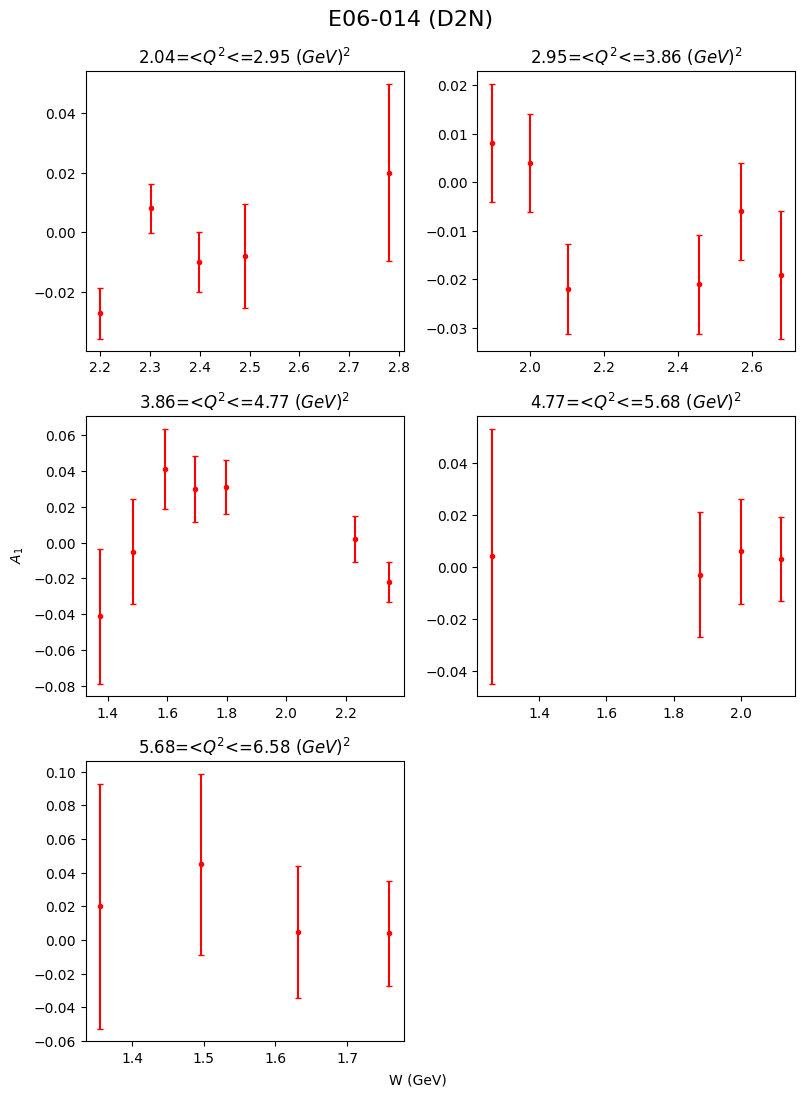

In [ ]:
## formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
x_min = 1.0
x_max = 3.0
y_min = -0.8
y_max = 0.8

# colors = colormaps['Set1'](np.linspace(0, 1, 10))
colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

# N Q2 buckets
N = 5

## make subplot
fig = plt.figure(figsize=(8,(math.ceil(N/2)/2)*7))

# e01012 - E beam = 3028 MeV, 4018 MeV, 5009 MeV

# plot different Q^2 ranges (N buckets)
Q2_ranges = np.linspace(e06014_df['Q2'].min(), e06014_df['Q2'].max(), N+1)
for i,Q2 in enumerate(Q2_ranges):
  if i<(Q2_ranges.size-1):
    # add a subplot
    ax = fig.add_subplot(math.ceil(N/2),2,i+1)

    W = e06014_df['W'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]/1000
    a1 = e06014_df['A1he3.mes'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]
    err = e06014_df['A1he3.mes.err'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]

    ax.errorbar(W, a1, err, fmt=m_type, color=colors[i-i], markersize=m_size,
                capsize=cap_size, capthick=cap_thick)

    ax.set_title(f"{Q2_ranges[i]:.2f}=<$Q^2$<={Q2_ranges[i+1]:.2f} $(GeV)^2$")
    # ax.legend()

## set ax1 limits and ticks
# ax1.set_xlim(1.0, 3.0)
# ax1.set_ylim(-0.08, 0.08)
# ax1.set_xticks(np.linspace(1.0, 3.0,5));
# ax1.set_yticks(np.linspace(-0.08, 0.08,5));




# set axes labels
fig.text(0.51, 0.00, 'W (GeV)', ha='center', va='center')
fig.text(0.01, 0.5, '$A_1$', ha='center', va='center', rotation='vertical')
fig.text(0.50, 1.01, 'E06-014 (D2N)', ha='center', va='center', fontsize=16)


fig.tight_layout()
# remove space between subplots
# f.subplots_adjust(wspace=0, hspace=0)

# save plot
# plt.savefig('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1F1vW.png')

# $A_2$ Plotting
files: psolv_e01012_a1a2.csv

## psolv E01-012 - plot by beam energy and Q2 buckets

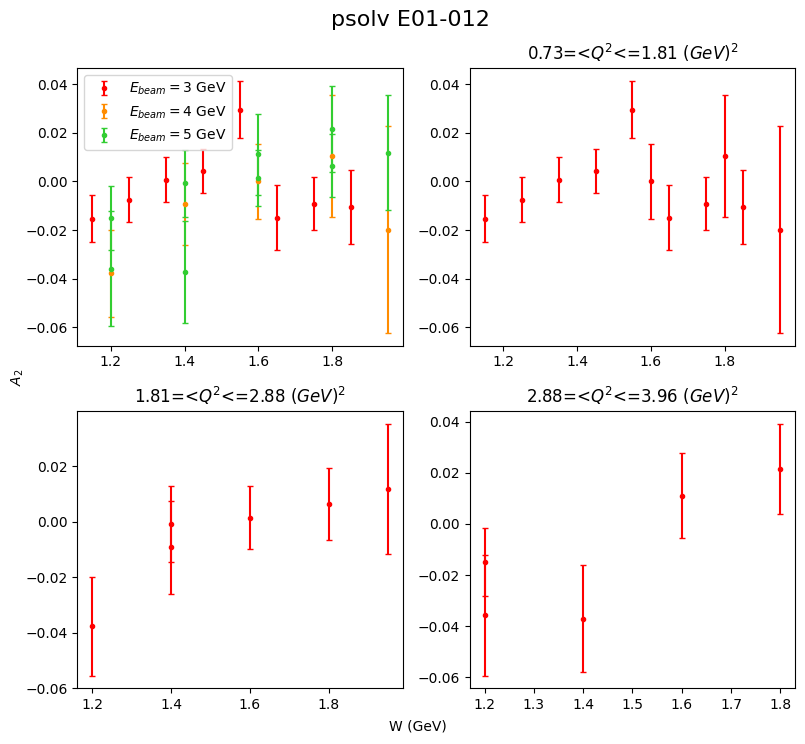

In [ ]:
## formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
x_min = 1.0
x_max = 3.0
y_min = -0.8
y_max = 0.8

# N number buckets for Q2
N = 3

# colors = colormaps['Set1'](np.linspace(0, 1, 10))
colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

## make subplot
fig = plt.figure(figsize=(8,(math.ceil(N/2)/2)*7))


## plot data
beam_energies = psolv_df['Eb'].unique()

# plot each beam energy in same subplot
ax1 = fig.add_subplot(math.ceil((N+1)/2),2,1)
for i,Eb in enumerate(beam_energies):
  ax1.errorbar(psolv_df['W'][psolv_df['Eb']==Eb],
             psolv_df['A2he3.mes'][psolv_df['Eb']==Eb],
             psolv_df['A2he3.mes.err'][psolv_df['Eb']==Eb],
             fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{round(Eb/1000)} GeV")
ax1.legend()

# plot different Q^2 ranges (N buckets)
Q2_ranges = np.linspace(psolv_df['Q2'].min(), psolv_df['Q2'].max(), N+1)
for i,Q2 in enumerate(Q2_ranges):
  if i<(Q2_ranges.size-1):
    # add a subplot
    ax = fig.add_subplot(math.ceil((N+1)/2),2, 2+i)

    # index values between Q2 range limits
    W = psolv_df['W'][psolv_df['Q2']>=Q2_ranges[i]][psolv_df['Q2']<=Q2_ranges[i+1]]
    a2 = psolv_df['A2he3.mes'][psolv_df['Q2']>=Q2_ranges[i]][psolv_df['Q2']<=Q2_ranges[i+1]]
    err = psolv_df['A2he3.mes.err'][psolv_df['Q2']>=Q2_ranges[i]][psolv_df['Q2']<=Q2_ranges[i+1]]

    ax.errorbar(W, a2, err, fmt=m_type, color=colors[i-i], markersize=m_size,
                capsize=cap_size, capthick=cap_thick)

    ax.set_title(f"{Q2_ranges[i]:.2f}=<$Q^2$<={Q2_ranges[i+1]:.2f} $(GeV)^2$")

# set axes labels
fig.text(0.51, 0.00, 'W (GeV)', ha='center', va='center')
fig.text(0.01, 0.5, '$A_2$', ha='center', va='center', rotation='vertical')
fig.text(0.50, 1.01, 'psolv E01-012', ha='center', va='center', fontsize=16)


fig.tight_layout()

# save plot
# plt.savefig('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1F1vW.png')

# $g_1/F_1$ Plotting
Files with g1/F1 data: e06014.csv

Files with g1 measured and F1 cal data: e97110.csv, e94010.csv

Files with g1 cal and F1 cal data: e01012.csv, psolv_e01012_a1a2.csv

## E06-014 (D2N) - plot by beam energy and Q2 buckets

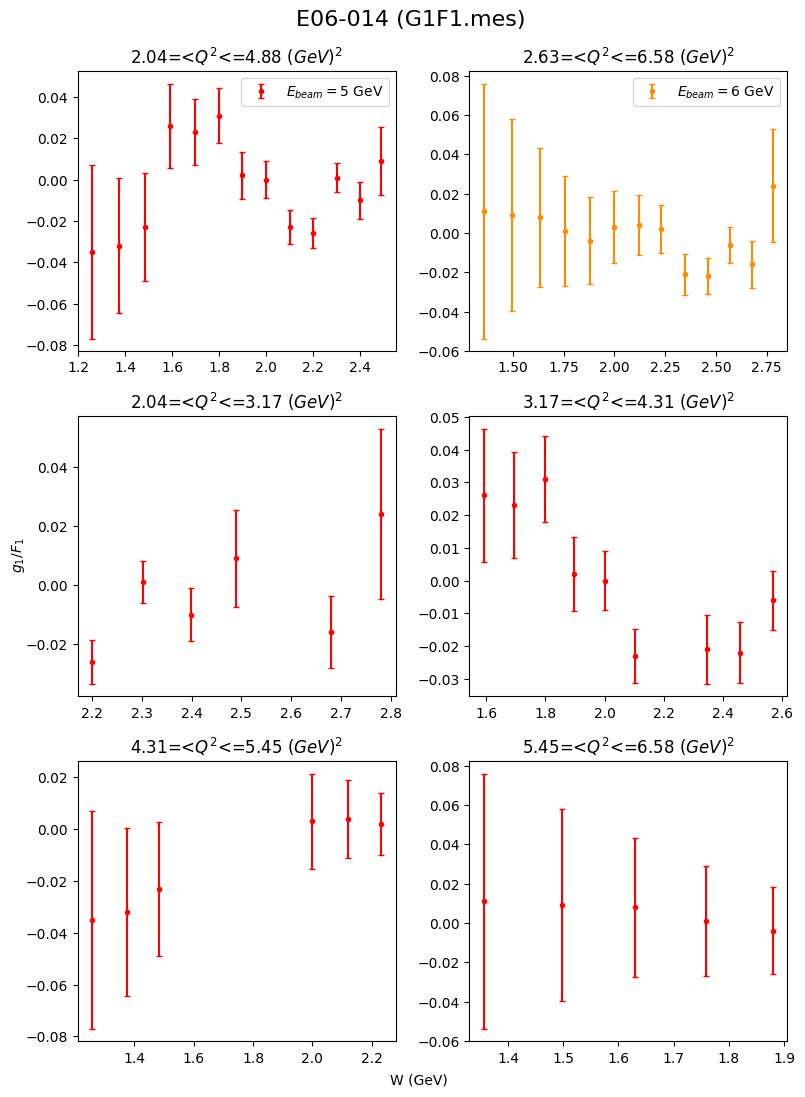

In [ ]:
## formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
x_min = 1.0
x_max = 3.0
y_min = -0.8
y_max = 0.8

# colors = colormaps['Set1'](np.linspace(0, 1, 10))
colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

# N Q2 buckets
N=4

## make subplot
fig = plt.figure(figsize=(8,(math.ceil((N+2)/2)/2)*7))


## plot data
# e06014 - measured g1f1 and error - E beam = 4760 MeV, 5890 MeV
beam_energies = e06014_df['Eb'].unique()

# plot each beam energy in different subplots
for i,Eb in enumerate(beam_energies):
  # add a subplot
  ax = fig.add_subplot(math.ceil((N+2)/2),2, 1+i)
  ax.errorbar(e06014_df['W'][e06014_df['Eb']==Eb]/1000,
             e06014_df['G1F1.mes'][e06014_df['Eb']==Eb],
             yerr=e06014_df['G1F1.mes.err'][e06014_df['Eb']==Eb],
             fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{round(Eb/1000)} GeV")
  # get min and max values of Q2 for subplot title
  q2_min = e06014_df['Q2'][e06014_df['Eb']==Eb].min()
  q2_max = e06014_df['Q2'][e06014_df['Eb']==Eb].max()
  ax.set_title(f"{q2_min:.2f}=<$Q^2$<={q2_max:.2f} $(GeV)^2$")
  ax.legend()

# plot different Q^2 ranges (4 buckets)
Q2_ranges = np.linspace(e06014_df['Q2'].min(), e06014_df['Q2'].max(), 5)
for i,Q2 in enumerate(Q2_ranges):
  if i<(Q2_ranges.size-1):
    # add a subplot
    ax = fig.add_subplot(math.ceil((N+2)/2),2, 3+i)

    W = e06014_df['W'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]/1000
    g1f1 = e06014_df['G1F1.mes'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]
    err = e06014_df['G1F1.mes.err'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]

    ax.errorbar(W, g1f1, err, fmt=m_type, color=colors[i-i], markersize=m_size,
                capsize=cap_size, capthick=cap_thick)

    ax.set_title(f"{Q2_ranges[i]:.2f}=<$Q^2$<={Q2_ranges[i+1]:.2f} $(GeV)^2$")
    # ax.legend()

## set ax1 limits and ticks
# ax1.set_xlim(1.0, 3.0)
# ax1.set_ylim(-0.08, 0.08)
# ax1.set_xticks(np.linspace(1.0, 3.0,5));
# ax1.set_yticks(np.linspace(-0.08, 0.08,5));




# set axes labels
fig.text(0.51, 0.00, 'W (GeV)', ha='center', va='center')
fig.text(0.01, 0.5, '$g_1/F_1$', ha='center', va='center', rotation='vertical')
fig.text(0.50, 1.01, 'E06-014 (G1F1.mes)', ha='center', va='center', fontsize=16)


fig.tight_layout()
# remove space between subplots
# f.subplots_adjust(wspace=0, hspace=0)

# save plot
# plt.savefig('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1F1vW.png')

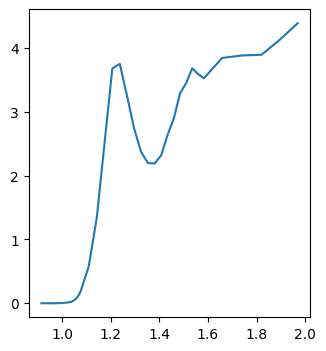

In [ ]:
## make subplot
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(1,2,1)
ax.plot(e94010_df['W'][e94010_df['Q2']==0.1]/1000,e94010_df['F1.cal'][e94010_df['Q2']==0.1])

## E97-110 - plot different beam energies (Q2 are constant)

Text(0.001, 0.5, '$g_1/F_1$')

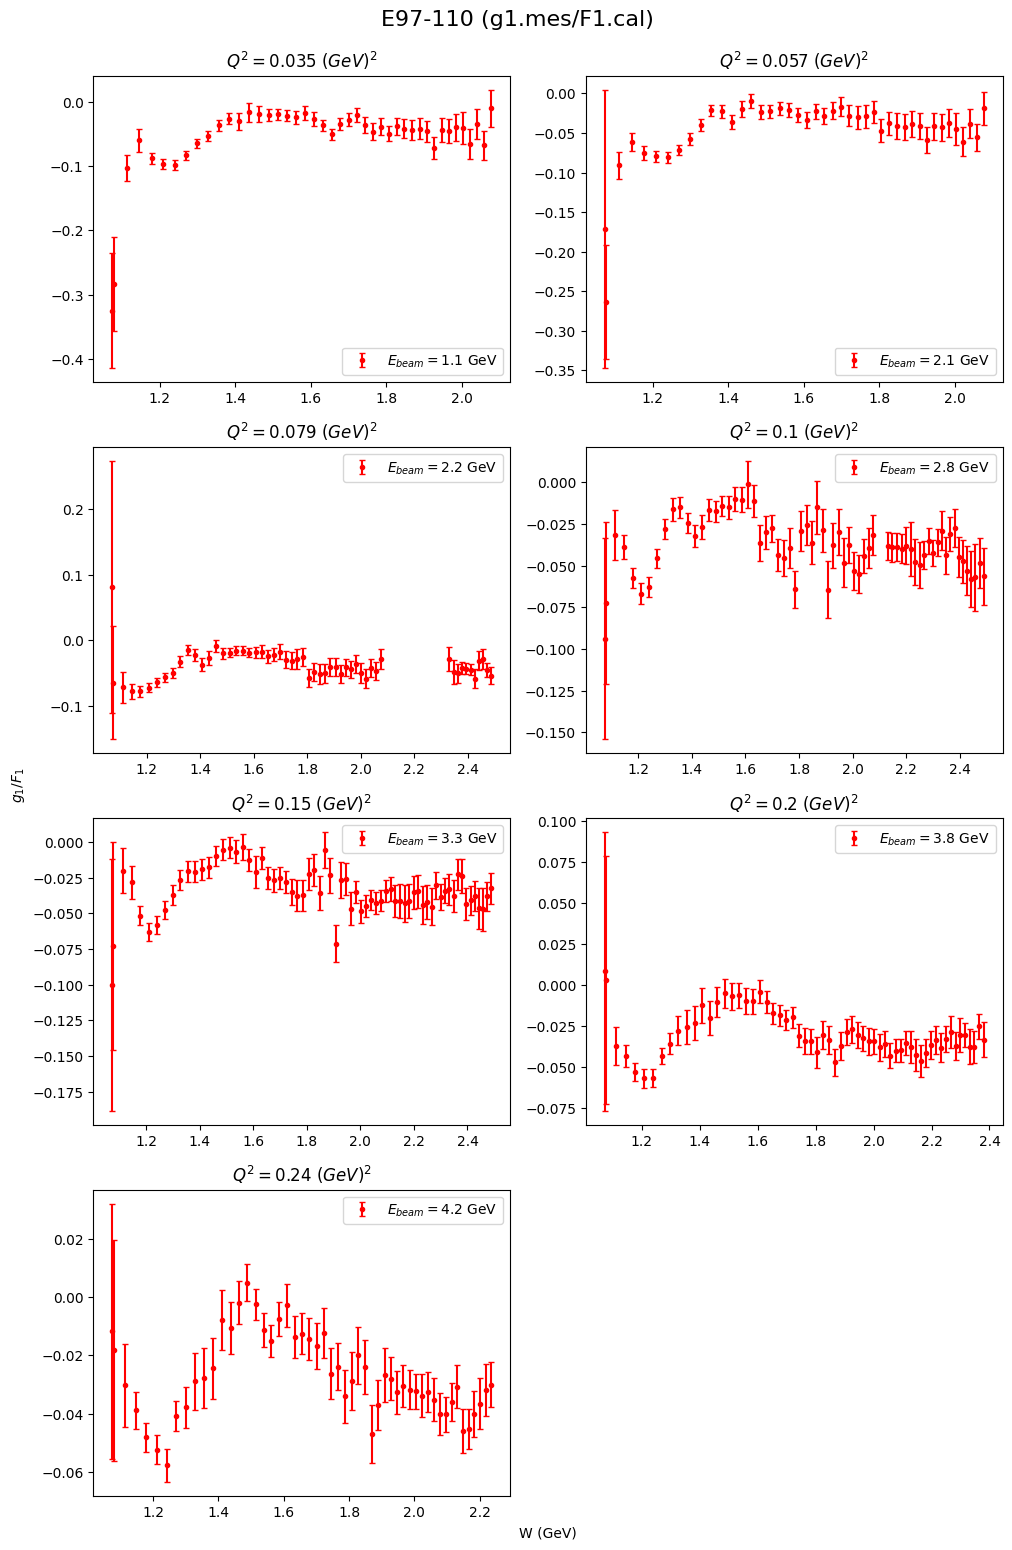

In [ ]:
# e97110 - measured g1 and error, calculated F1
e97110_df['g1f1'] = e97110_df['G1.mes']/e97110_df['F1.cal']

# calculate error from error propagation - add this column to dataframe
e97110_df['g1f1.err'] = np.abs(e97110_df['g1f1'] * np.sqrt((e97110_df['G1.mes.err']/e97110_df['G1.mes'])**2 + (e97110_df['F1.dff']/e97110_df['F1.cal'])**2))

# formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

# lists of tuples for axes ranges
x_lim = [(1.0,2.2),(1.0,2.2),(1.0,2.6),(1.0,2.6),(1.0,2.6),(1.0,2.6),(0.8,2.4)]
y_lim = [(-.1,.1),(-.1,.1),(-.1,.1),(-.1,.1),(-.1,.1),(-.1,.1),(-.1,.1)]

# make figure
fig = plt.figure(figsize=(10,15))

# list of beam energies
beam_energies = e97110_df['Eb'].unique()

# plot each Q2/Eb
for i, Eb in enumerate(beam_energies):
  ax = fig.add_subplot(4,2, 1+i)
  ax.errorbar(e97110_df['W'][e97110_df['Eb']==Eb]/1000,
             e97110_df['g1f1'][e97110_df['Eb']==Eb],
             yerr=e97110_df['g1f1.err'][e97110_df['Eb']==Eb],
             fmt=m_type, color=colors[0], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{(Eb/1000):.1f} GeV")
  # ax.set_xlim(x_lim[i][0], x_lim[i][1])
  # ax.set_ylim(y_lim[i][0], y_lim[i][1])
  # ax.set_xticks(np.linspace(x_lim[i][0], x_lim[i][1],5));
  # ax.set_yticks(np.linspace(y_lim[i][0], y_lim[i][1],5));
  ax.set_title(f"$Q^2={e97110_df['Q2'][e97110_df['Eb']==Eb].unique()[0]}$" + " " + "$({GeV})^2$")
  ax.legend()

# get all the axes to adjust axes
allaxes = fig.get_axes()

# adjust

# better plot layout
fig.tight_layout()

# set axes labels
fig.text(0.50, 1.01, 'E97-110 (g1.mes/F1.cal)', ha='center', va='center', fontsize=16)
fig.text(0.53, 0.001, 'W (GeV)', ha='center', va='center')
fig.text(0.001, 0.5, '$g_1/F_1$', ha='center', va='center', rotation='vertical')

## E94-010 - plot different beam energies (Q2 are constant)

Text(0.001, 0.5, '$g_1/F_1$')

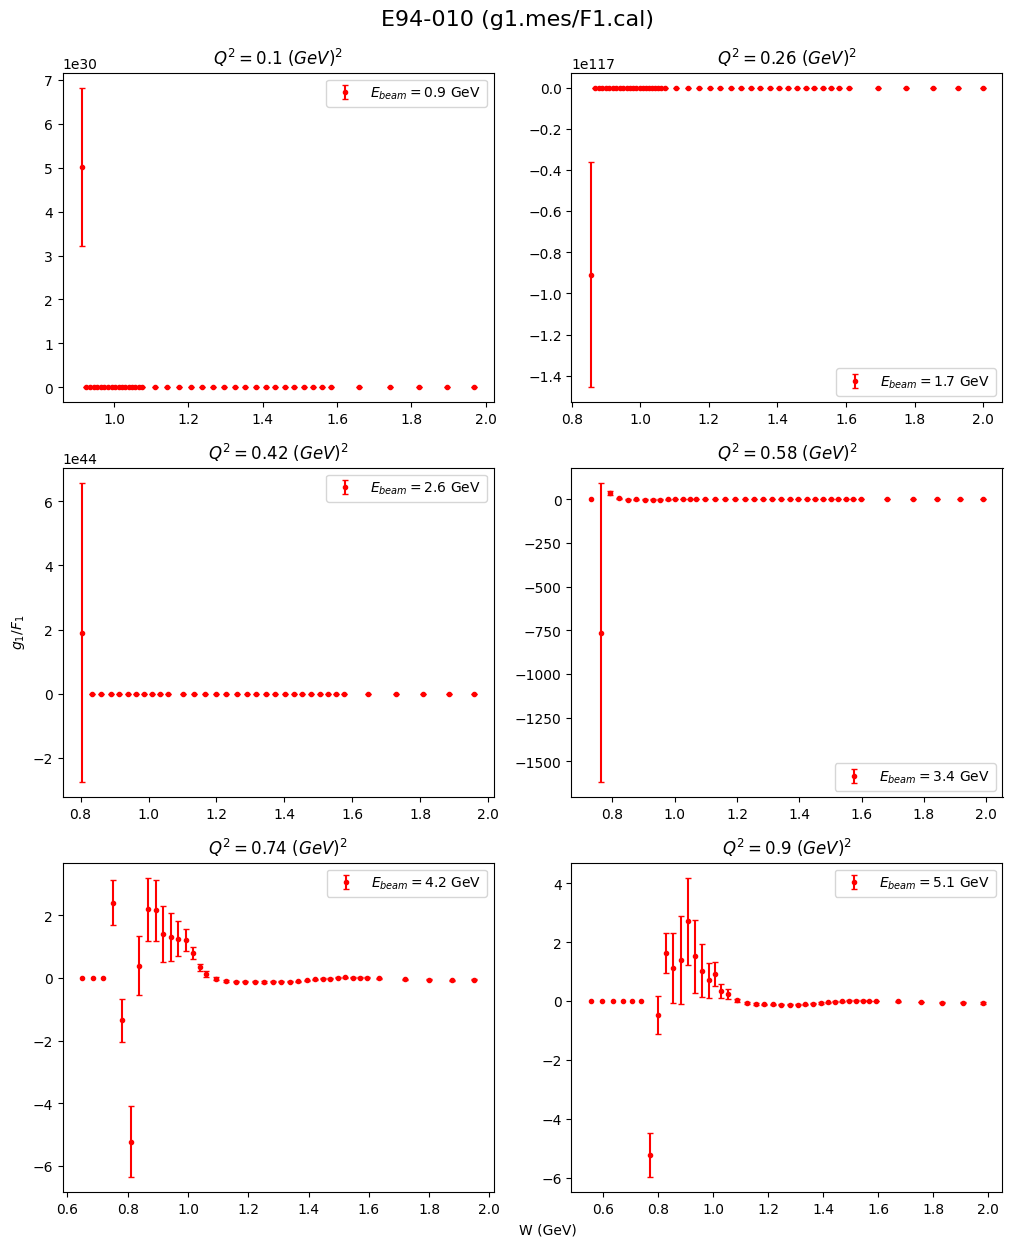

In [ ]:
# e94010 - measured g1 and error, calculated F1
e94010_df['g1f1'] = e94010_df['G1.mes']/e94010_df['F1.cal']

# calculate error from error propagation - add this column to dataframe
e94010_df['g1f1.err'] = np.abs(e94010_df['g1f1'] * np.sqrt((e94010_df['G1.mes.err']/e94010_df['G1.mes'])**2+ (e94010_df['F1.dff']/e94010_df['F1.cal'])**2))

# formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

# lists of tuples for axes ranges
x_lim = [(0.8,2.2),(0.8,2.2),(0.7,2.1),(0.6,2.2),(0.6,2.2),(0.5,2.1)]
y_lim = [(-.15,.15),(-.25,.15),(-.2,.2),(-.2,.2),(-.2,.2),(-.2,.2)]

# make figure
fig = plt.figure(figsize=(10,12))

# list of beam energies
beam_energies = e94010_df['Eb'].unique()

# plot each Q2/Eb
for i, Eb in enumerate(beam_energies):
  ax = fig.add_subplot(3,2, 1+i)
  ax.errorbar(e94010_df['W'][e94010_df['Eb']==Eb]/1000,
             e94010_df['g1f1'][e94010_df['Eb']==Eb],
             yerr=e94010_df['g1f1.err'][e94010_df['Eb']==Eb],
             fmt=m_type, color=colors[0], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{(Eb/1000):.1f} GeV")
  # ax.set_xlim(x_lim[i][0], x_lim[i][1])
  # ax.set_ylim(y_lim[i][0], y_lim[i][1])
  # ax.set_xticks(np.linspace(x_lim[i][0], x_lim[i][1],5));
  # ax.set_yticks(np.linspace(y_lim[i][0], y_lim[i][1],5));
  ax.set_title(f"$Q^2={e94010_df['Q2'][e94010_df['Eb']==Eb].unique()[0]}$" + " " + "$({GeV})^2$")
  ax.legend()

# get all the axes to adjust axes
allaxes = fig.get_axes()

# adjust

# better plot layout
fig.tight_layout()

# set axes labels
fig.text(0.50, 1.01, 'E94-010 (g1.mes/F1.cal)', ha='center', va='center', fontsize=16)
fig.text(0.53, 0.001, 'W (GeV)', ha='center', va='center')
fig.text(0.001, 0.5, '$g_1/F_1$', ha='center', va='center', rotation='vertical')

Gaussian(?) dip at 1.2 GeV, exponential rise before it and a sort of exp decay after

# $A_{||}$
files: dflay_e06014_aphysical.csv

In [ ]:
## formatting variables
m_size = 6
cap_size = 2
cap_thick = 1
m_type = '.'
x_min = 1.0
x_max = 3.0
y_min = -0.8
y_max = 0.8

colors = ("red", "darkorange", "limegreen", "darkolivegreen",
          "darkslategray", "steelblue", "darkblue", "rebeccapurple",
          "darkmagenta")

# N Q2 buckets
N=4

## make subplot
fig = plt.figure(figsize=(8,(math.ceil((N+2)/2)/2)*7))


## plot data
# e06014 - measured g1f1 and error - E beam = 4760 MeV, 5890 MeV
beam_energies = e06014_df['Eb'].unique()

# plot each beam energy in different subplots
for i,Eb in enumerate(beam_energies):
  # add a subplot
  ax = fig.add_subplot(math.ceil((N+2)/2),2, 1+i)
  ax.errorbar(e06014_df['W'][e06014_df['Eb']==Eb]/1000,
             e06014_df['G1F1.mes'][e06014_df['Eb']==Eb],
             yerr=e06014_df['G1F1.mes.err'][e06014_df['Eb']==Eb],
             fmt=m_type, color=colors[i], markersize=m_size, capsize=cap_size,
             capthick=cap_thick, label="$E_{beam} =$" + f"{round(Eb/1000)} GeV")
  # get min and max values of Q2 for subplot title
  q2_min = e06014_df['Q2'][e06014_df['Eb']==Eb].min()
  q2_max = e06014_df['Q2'][e06014_df['Eb']==Eb].max()
  ax.set_title(f"{q2_min:.2f}=<$Q^2$<={q2_max:.2f} $(GeV)^2$")
  ax.legend()

# plot different Q^2 ranges (4 buckets)
Q2_ranges = np.linspace(e06014_df['Q2'].min(), e06014_df['Q2'].max(), 5)
for i,Q2 in enumerate(Q2_ranges):
  if i<(Q2_ranges.size-1):
    # add a subplot
    ax = fig.add_subplot(math.ceil((N+2)/2),2, 3+i)

    W = e06014_df['W'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]/1000
    g1f1 = e06014_df['G1F1.mes'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]
    err = e06014_df['G1F1.mes.err'][e06014_df['Q2']>=Q2_ranges[i]][e06014_df['Q2']<=Q2_ranges[i+1]]

    ax.errorbar(W, g1f1, err, fmt=m_type, color=colors[i-i], markersize=m_size,
                capsize=cap_size, capthick=cap_thick)

    ax.set_title(f"{Q2_ranges[i]:.2f}=<$Q^2$<={Q2_ranges[i+1]:.2f} $(GeV)^2$")




# set axes labels
fig.text(0.51, 0.00, 'W (GeV)', ha='center', va='center')
fig.text(0.01, 0.5, '$g_1/F_1$', ha='center', va='center', rotation='vertical')
fig.text(0.50, 1.01, 'E06-014 (G1F1.mes)', ha='center', va='center', fontsize=16)


fig.tight_layout()
# remove space between subplots
# f.subplots_adjust(wspace=0, hspace=0)

# save plot
# plt.savefig('/mnt/drive/MyDrive/Research/Xiaochao_Summer_24/plots/g1F1vW.png')